<a href="https://colab.research.google.com/github/xazhu9/AIPI-590/blob/main/Assignment%203/Assignment%203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AIPI 590 - XAI \ Assignment #03

Description: Apply linear, logistic, and GAM regression on Churn problem,make comparision for their strength and weakness, and pick one that is fit for understanding churning problem.

https://github.com/xazhu9/AIPI-590/blob/main/Assignment%203/Assignment%203.ipynb

In [ ]:
pip install pygam

Load Package

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
import statsmodels.api as sm
from pygam import LinearGAM, LogisticGAM, s, f
from scipy.stats import skew, kurtosis
from statsmodels.stats.stattools import durbin_watson


Functions

In [ ]:
def logit(p):
    return np.log(p / (1 - p))

def check_linearity_numerical(df, col, target='Churn'):
    df['bin'] = pd.qcut(df[col], q=10, duplicates='drop')
    bin_mean = df.groupby('bin')[target].mean()
    bin_mean = bin_mean[(bin_mean > 0) & (bin_mean < 1)]
    log_odds = logit(bin_mean)

    plt.figure(figsize=(10, 6))
    bin_centers = df.groupby('bin')[col].mean()
    plt.plot(bin_centers, log_odds, marker='o')
    plt.title(f'Logit(p) vs {col}')
    plt.xlabel(col)
    plt.ylabel('Logit(p)')
    plt.show()

def check_linearity_categorical(df, col, target='Churn'):
    cat_mean = df.groupby(col)[target].mean()
    cat_mean = cat_mean[(cat_mean > 0) & (cat_mean < 1)]
    log_odds = logit(cat_mean)

    plt.figure(figsize=(10, 6))
    plt.bar(cat_mean.index.astype(str), log_odds)
    plt.title(f'Logit(p) vs {col}')
    plt.xlabel(col)
    plt.ylabel('Logit(p)')
    plt.xticks(rotation=45)
    plt.show()

1.EDA

Data analysis(Asked ChatGPT about EDA and assumption for different models, especially for GAM)

Missing Values:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Missing Values after imputation:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


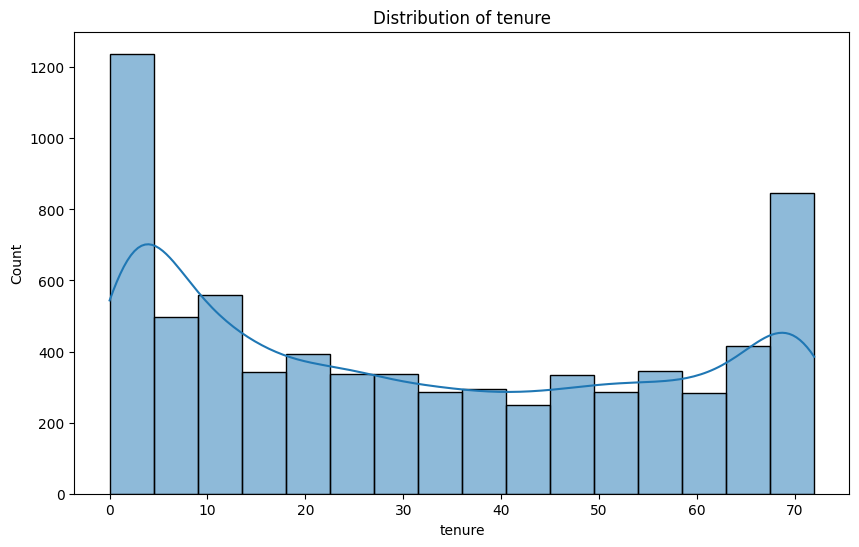

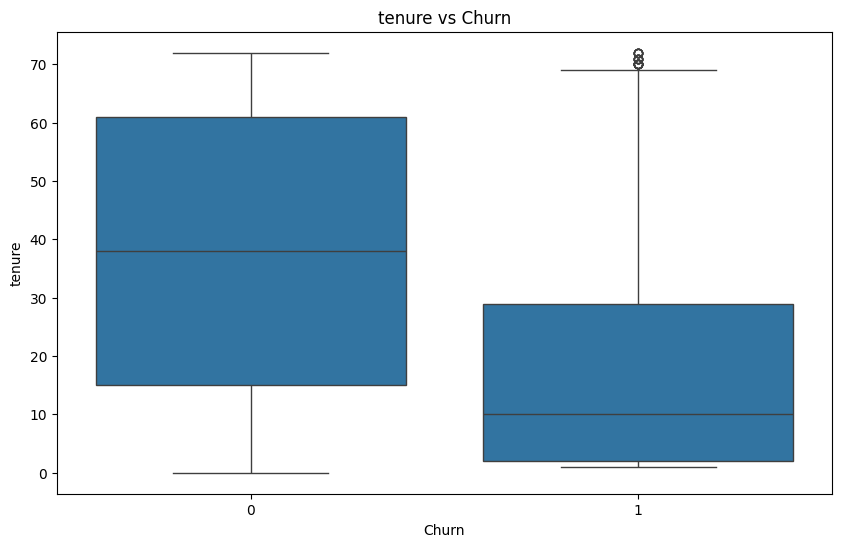

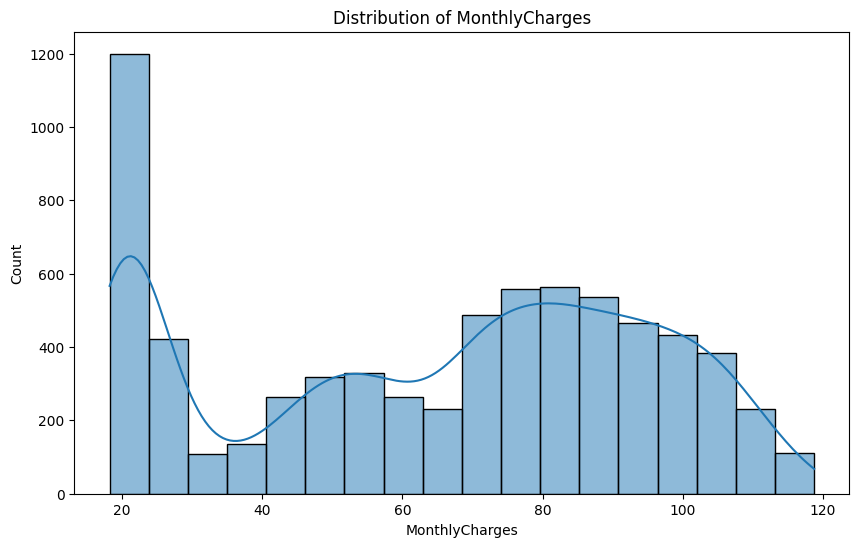

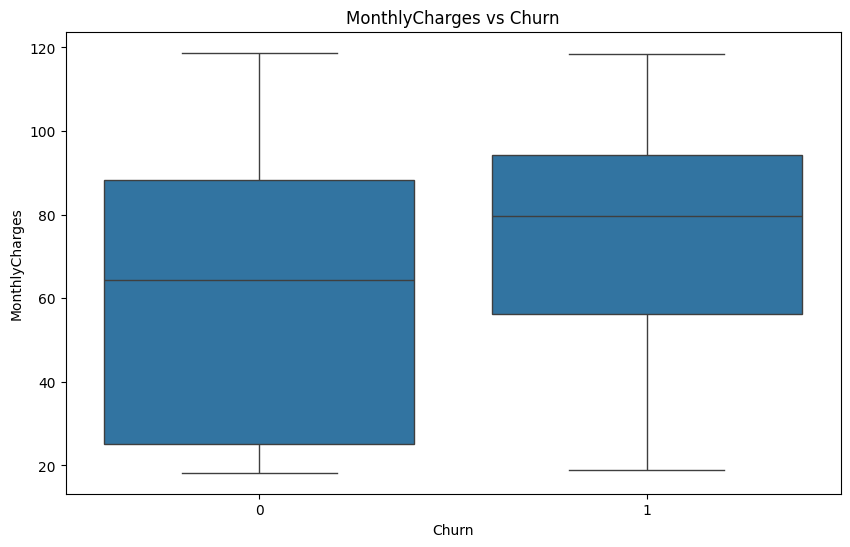

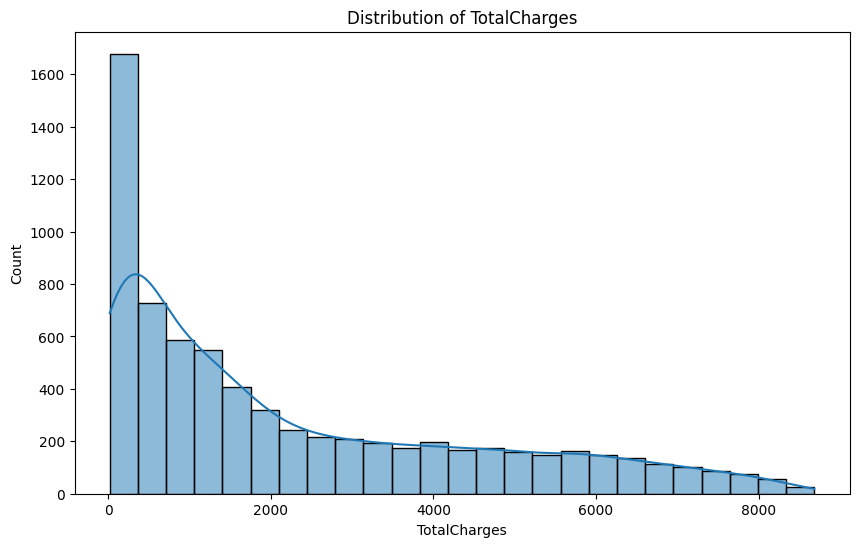

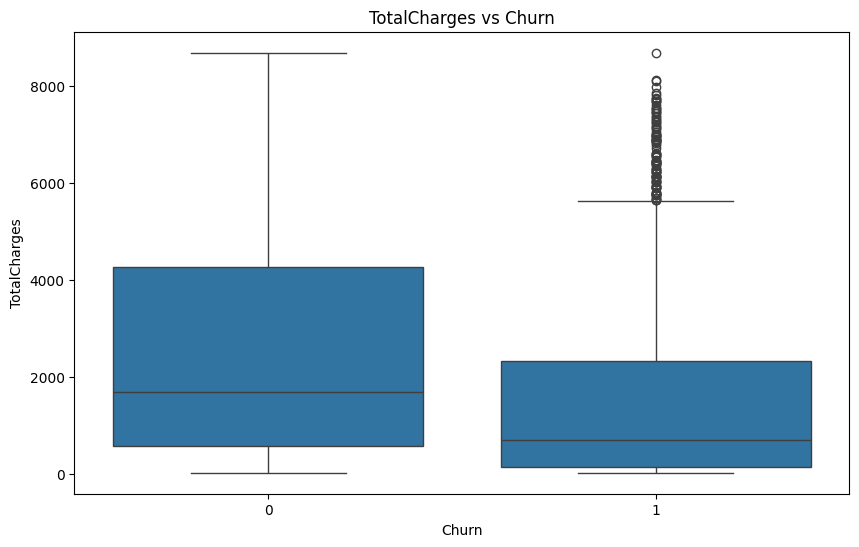

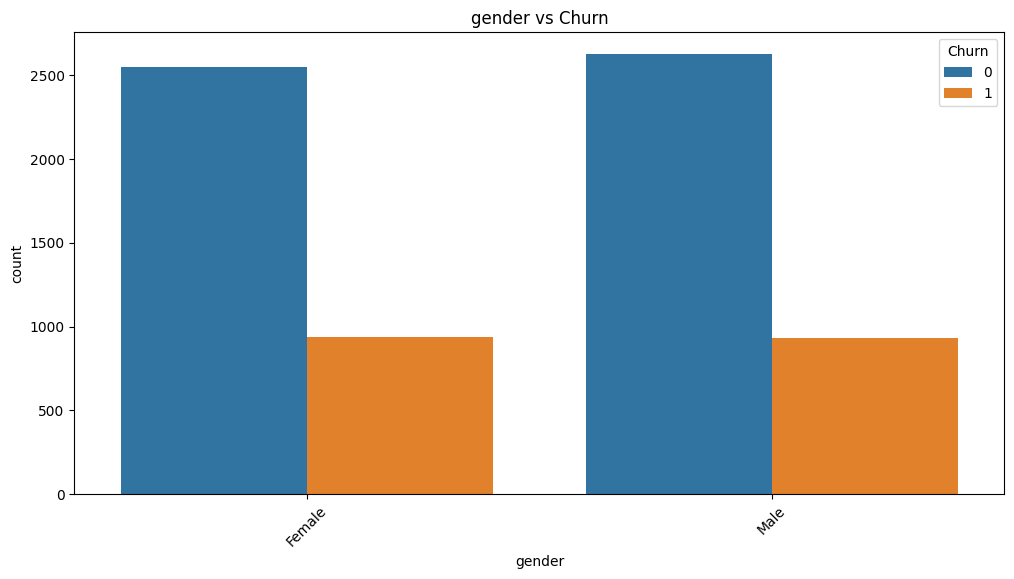

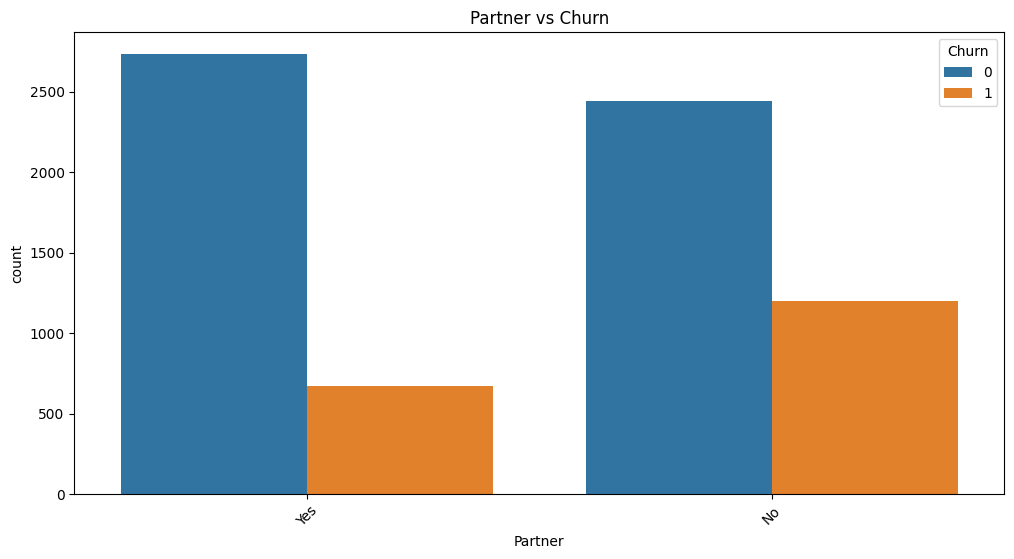

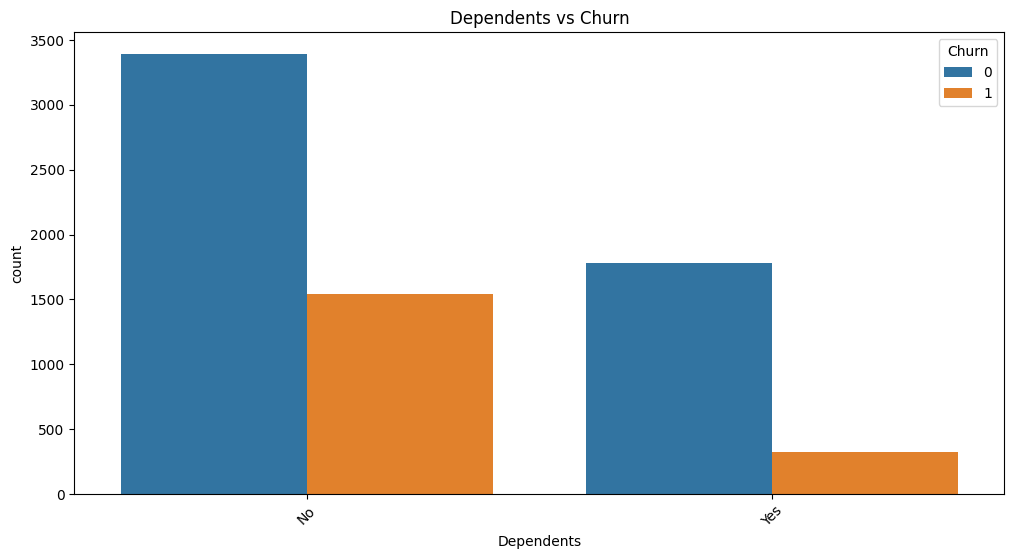

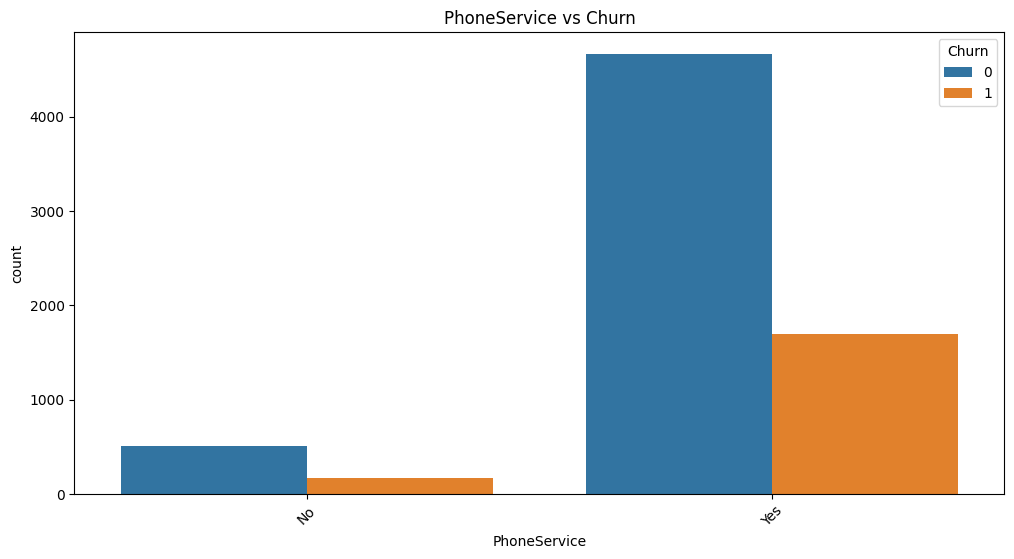

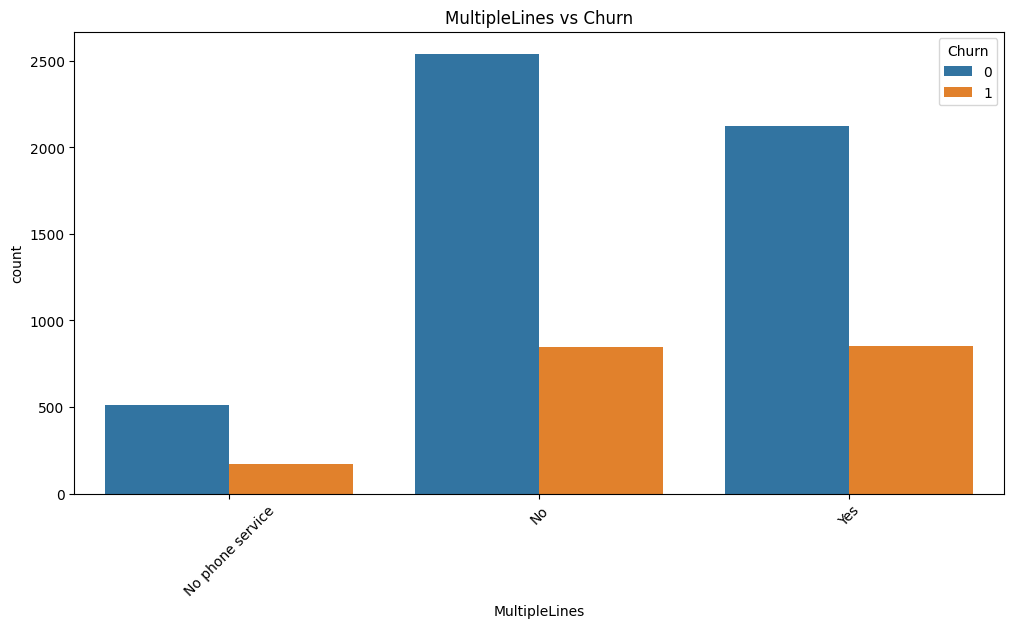

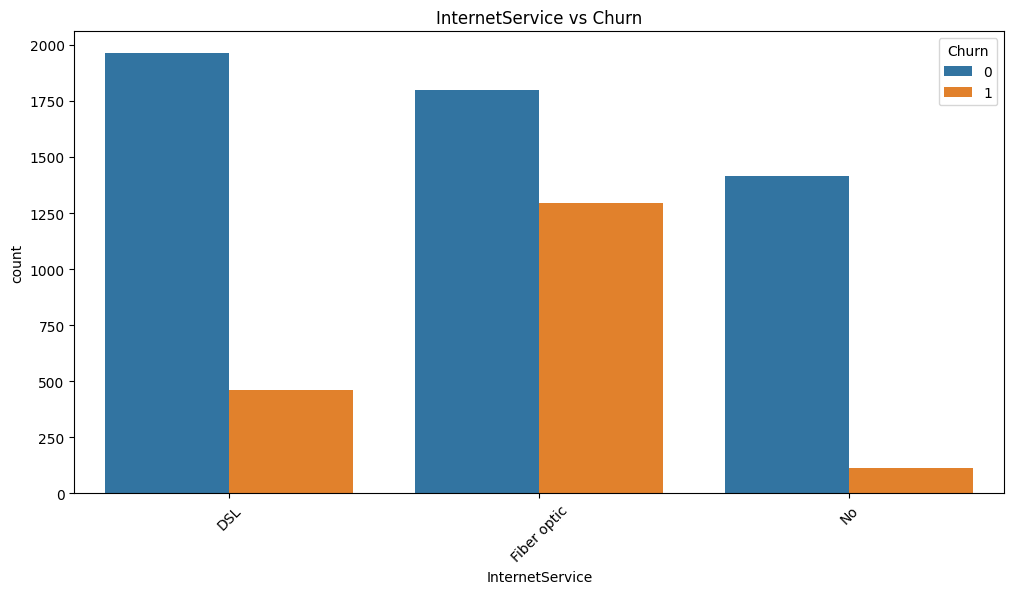

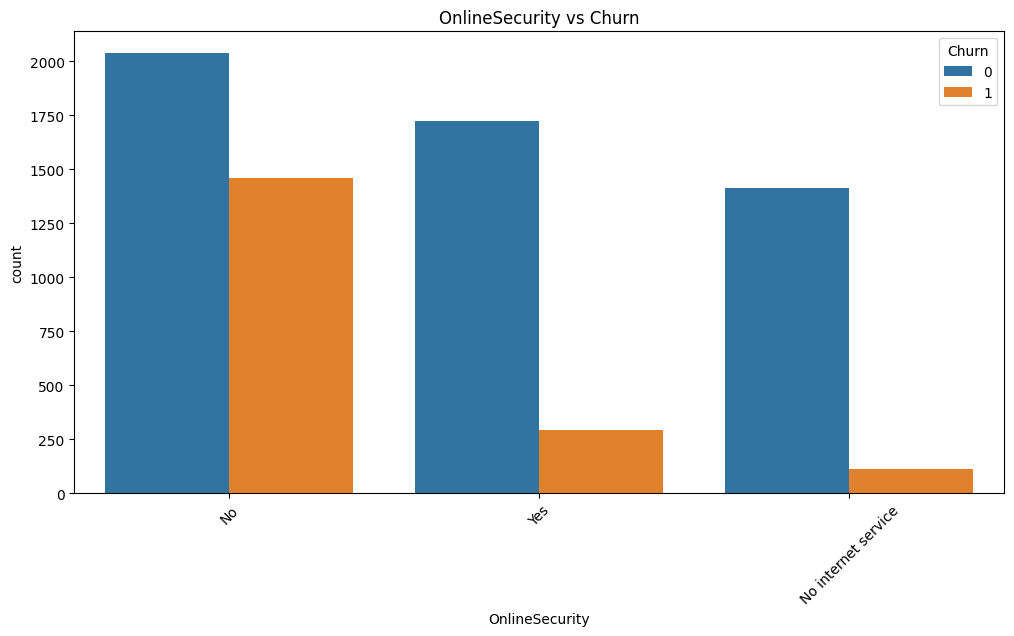

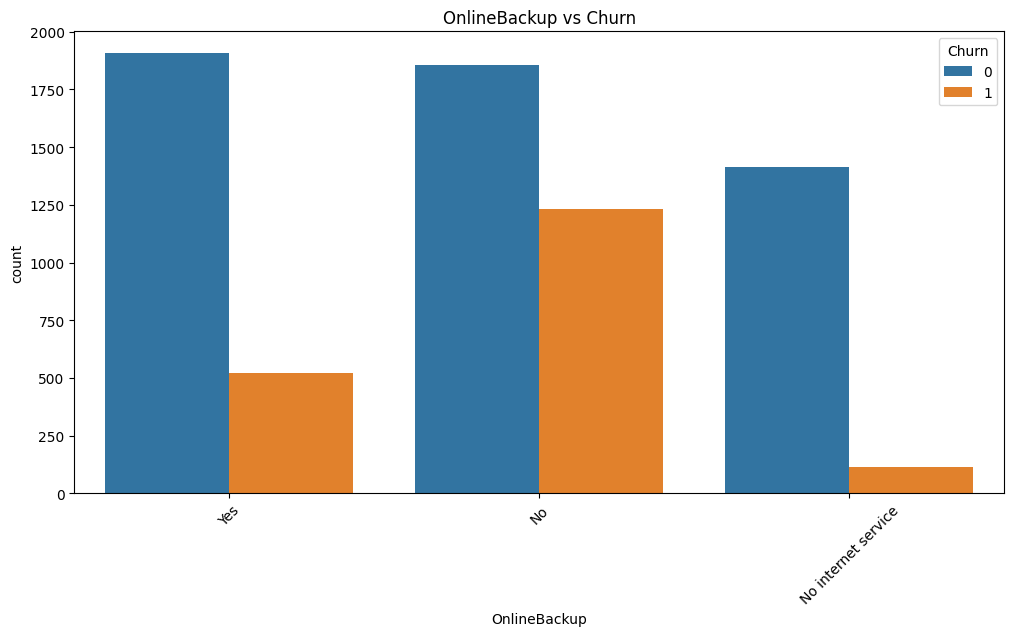

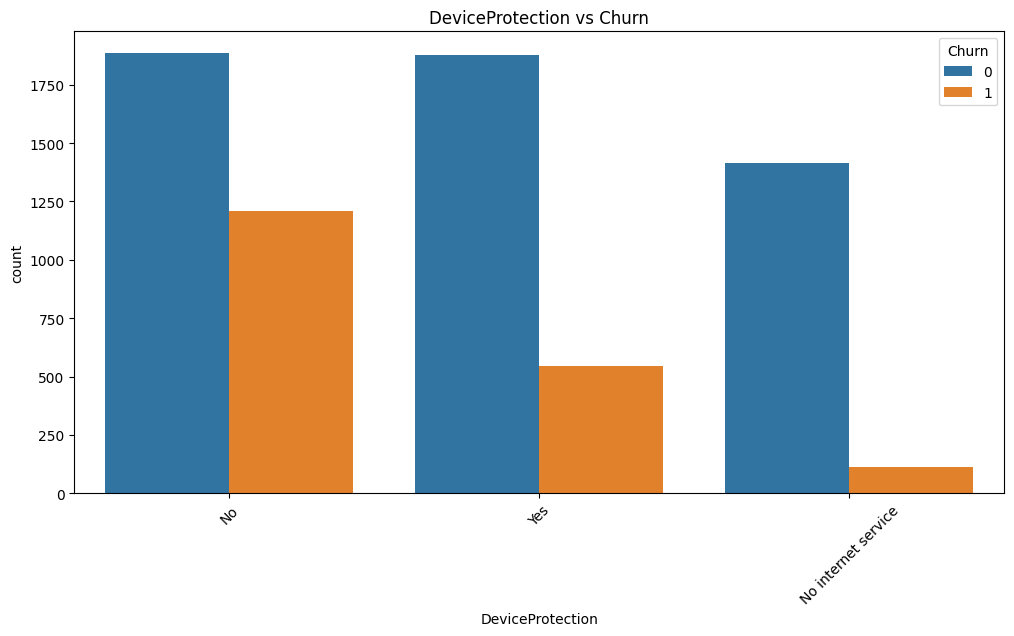

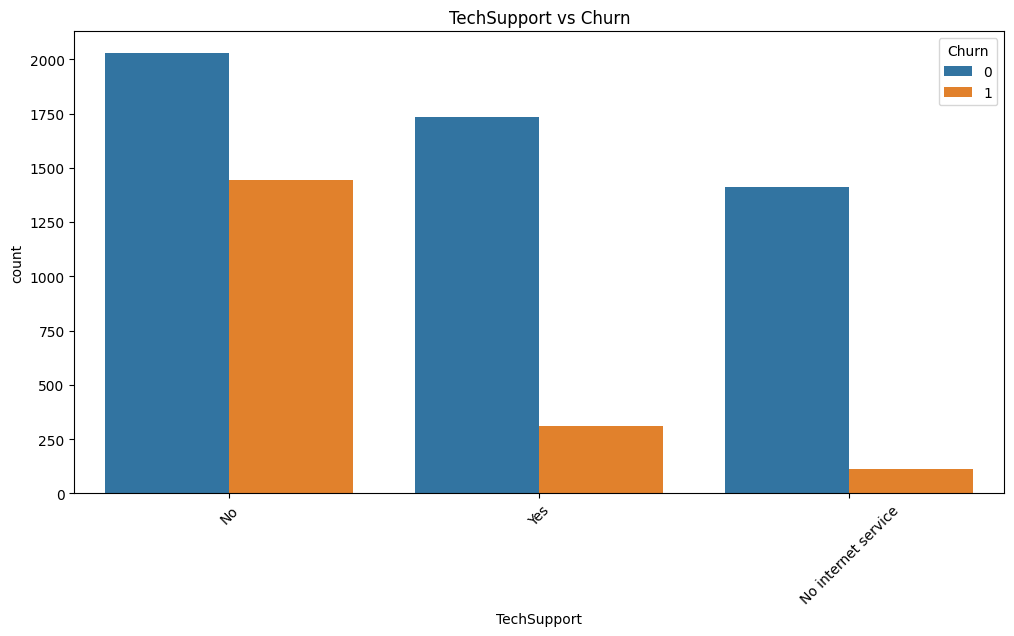

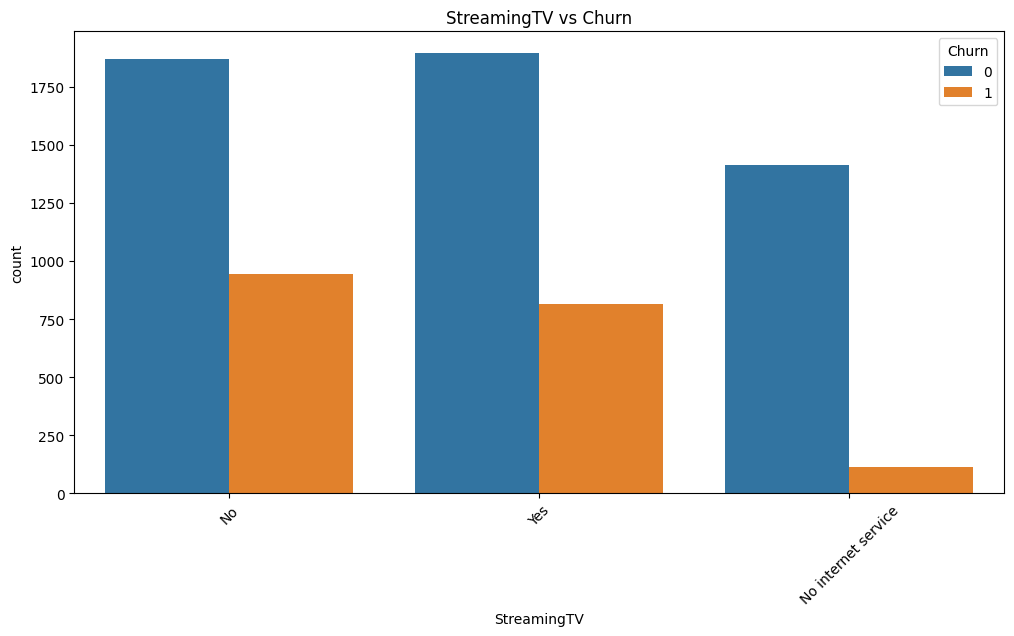

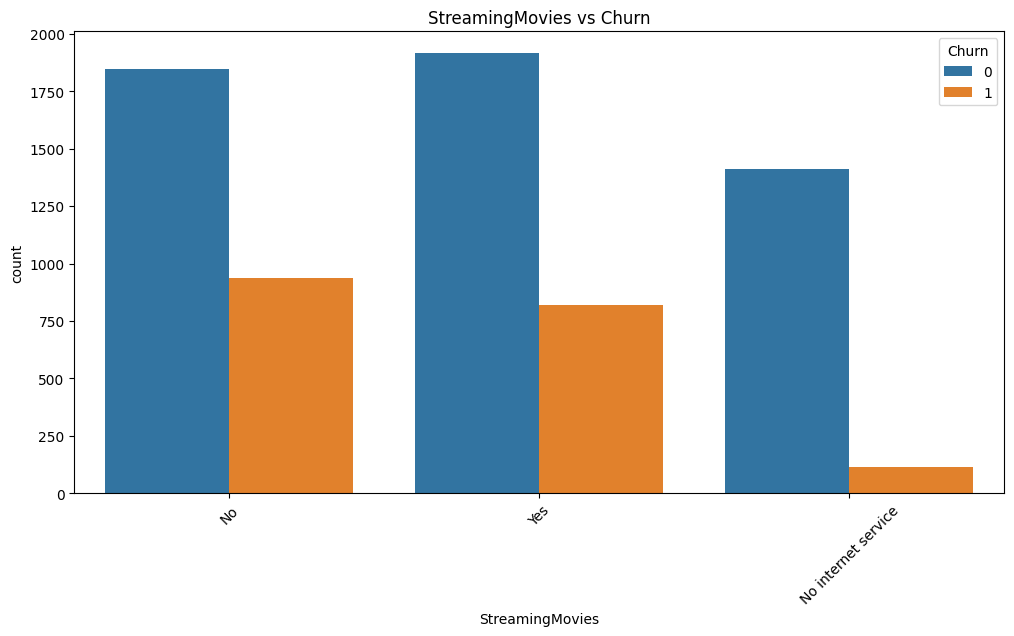

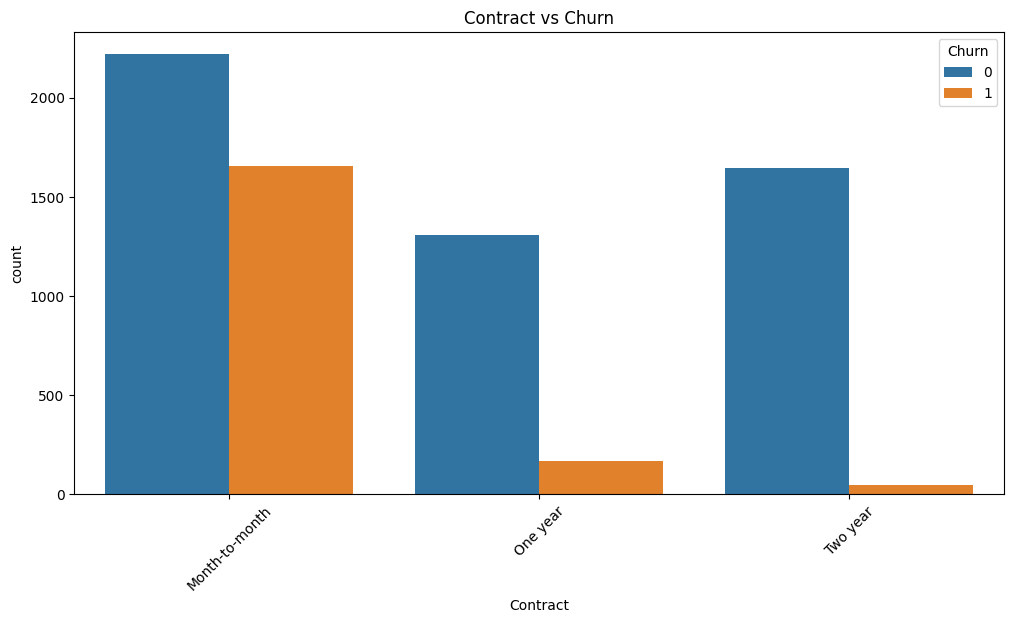

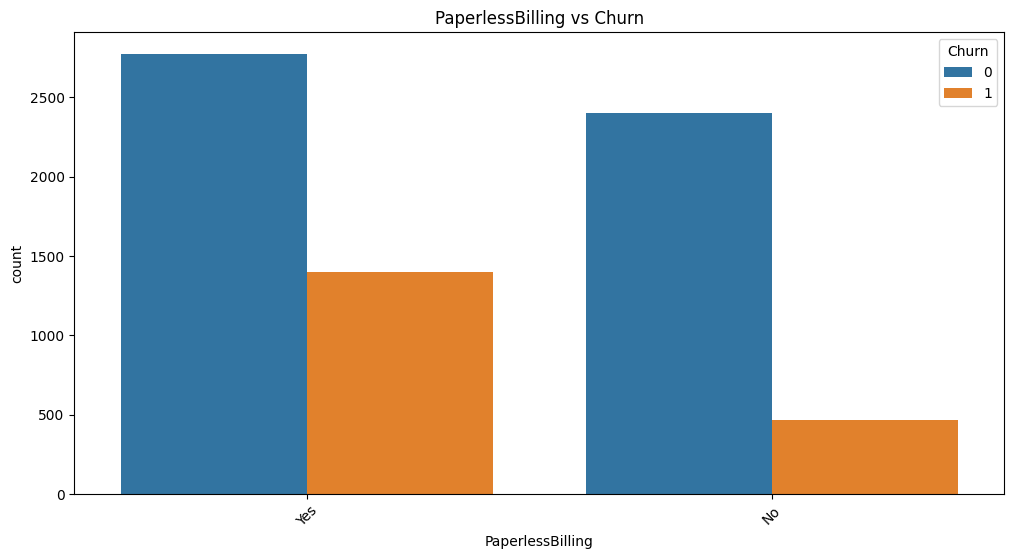

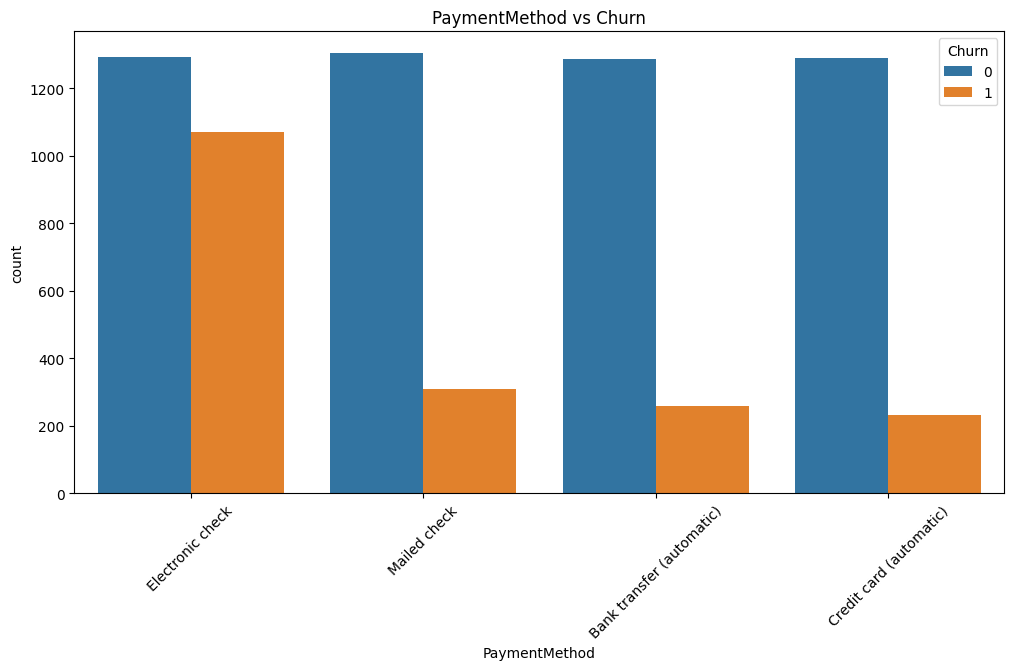

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


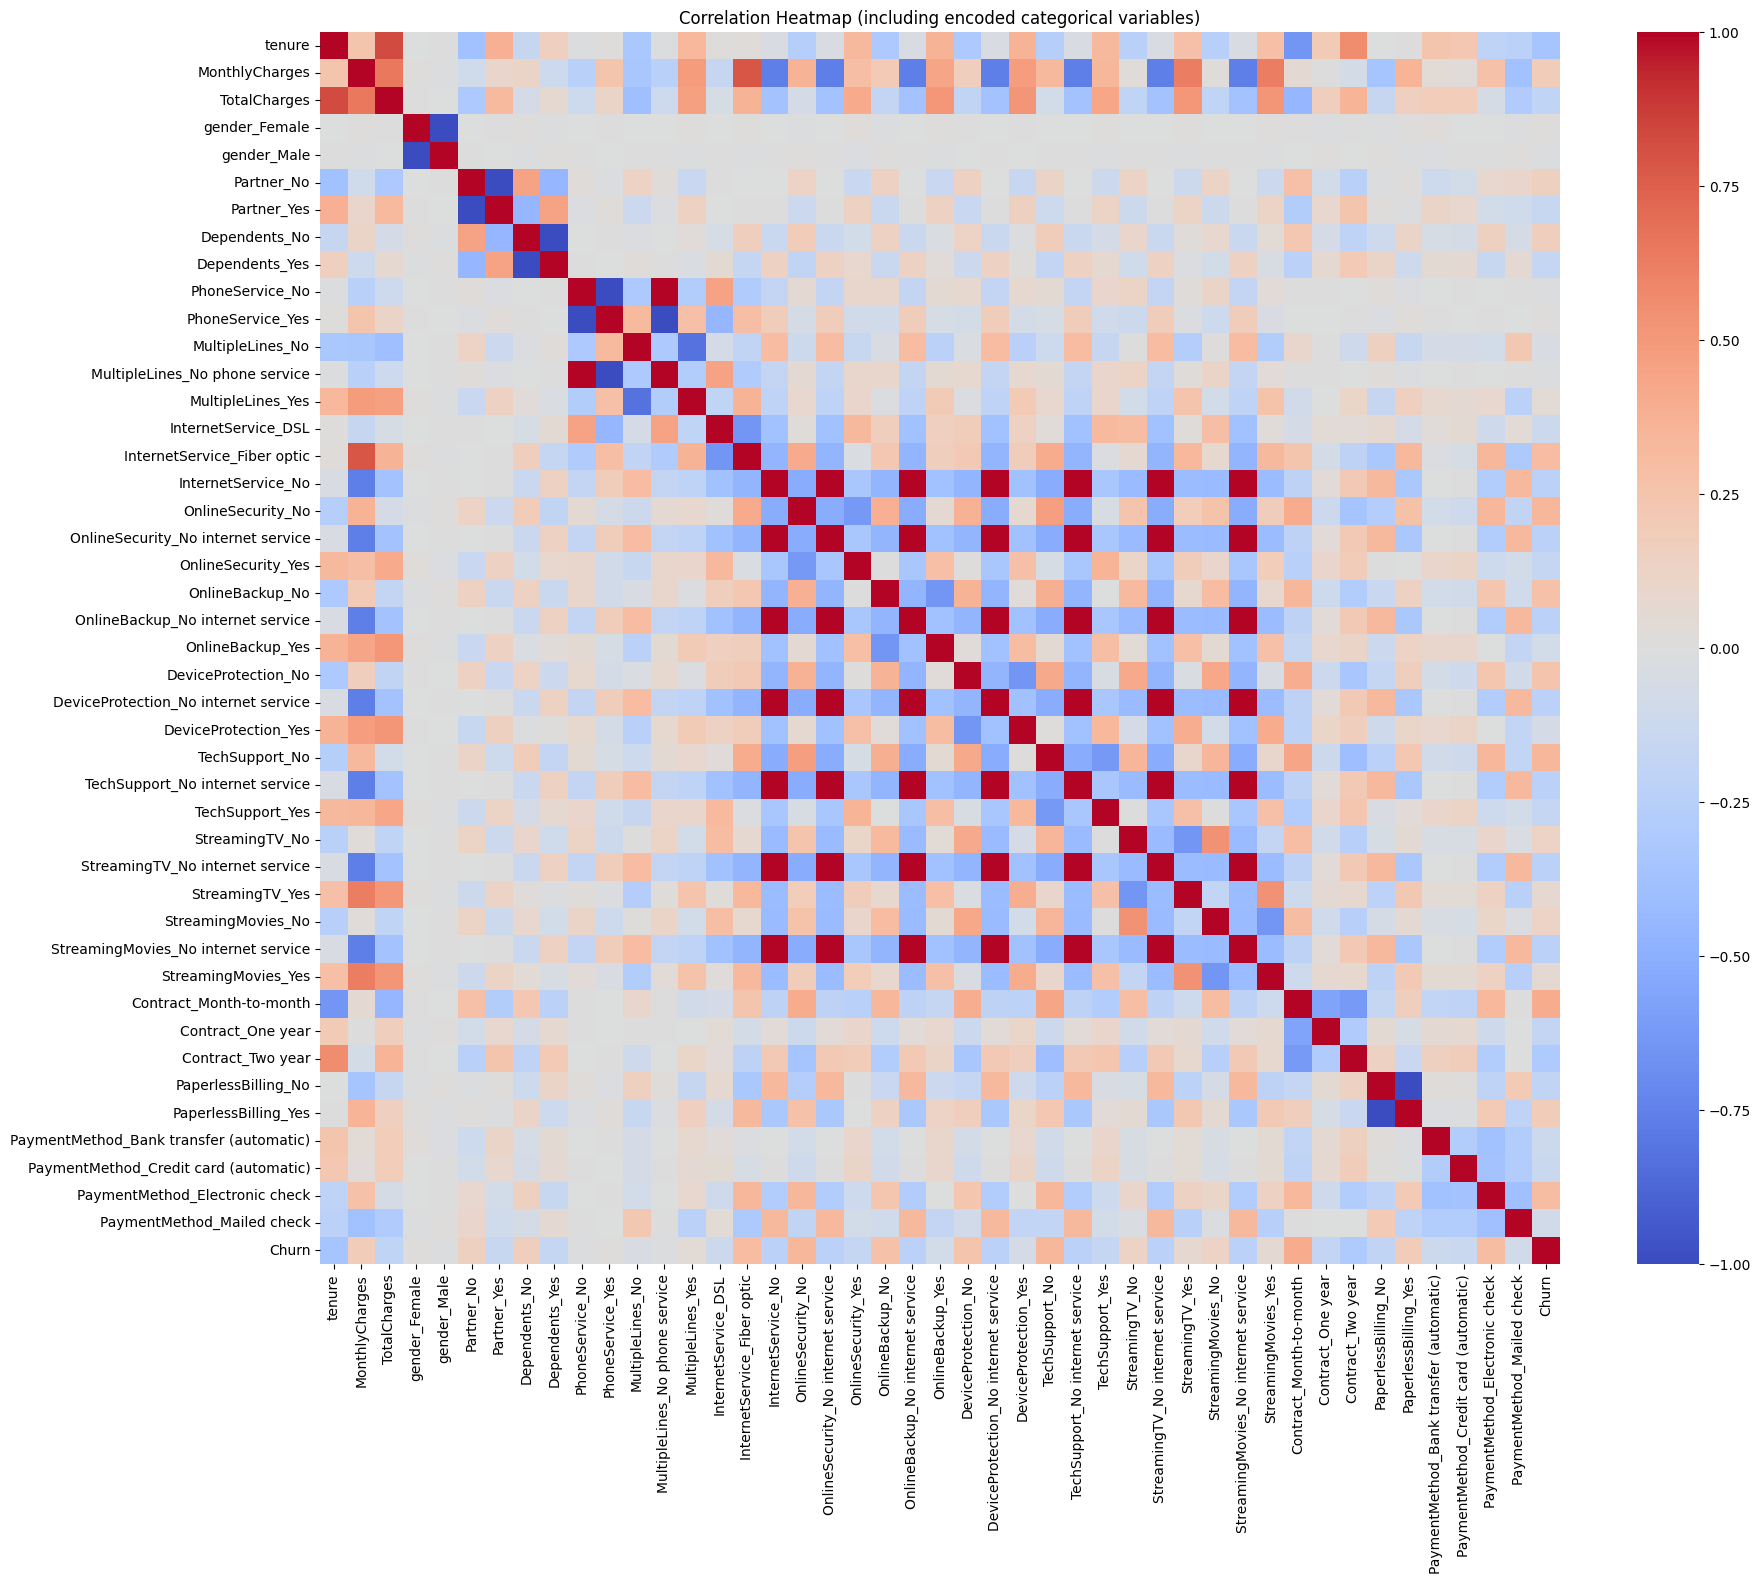

Top 10 correlations with Churn:
Churn                             1.000000
Contract_Month-to-month           0.405103
tenure                           -0.352229
OnlineSecurity_No                 0.342637
TechSupport_No                    0.337281
InternetService_Fiber optic       0.308020
Contract_Two year                -0.302253
PaymentMethod_Electronic check    0.301919
OnlineBackup_No                   0.268005
DeviceProtection_No               0.252481
Name: Churn, dtype: float64

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.68      0.60      0.64       373

    accuracy                           0.82      1409
   macro avg       0.77      0.75      0.76      1409
weighted avg       0.81      0.82      0.81      1409


Confusion Matrix:
[[928 108]
 [148 225]]


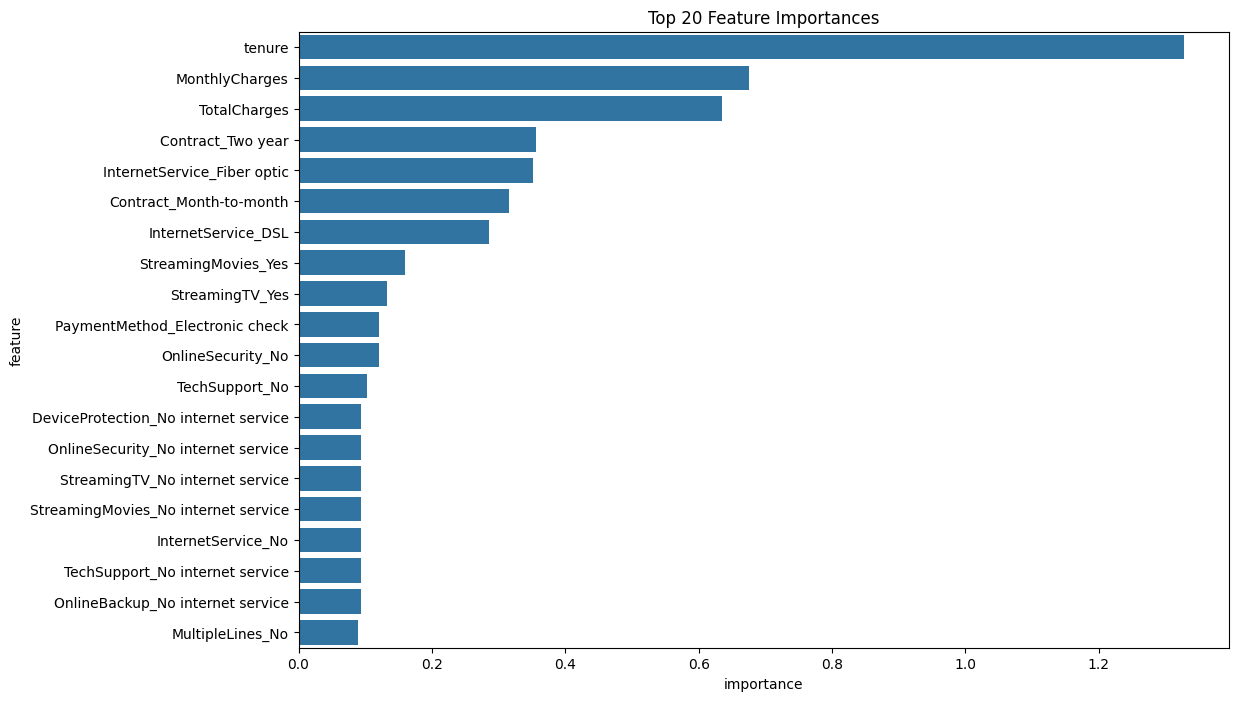


Variance Inflation Factors:
          feature       VIF
0          tenure  6.321802
1  MonthlyCharges  3.360371
2    TotalCharges  8.073814


In [ ]:


# GitHub raw content URL
url = "https://raw.githubusercontent.com/xazhu9/AIPI-590/main/Assignment%203/WA_Fn-UseC_-Telco-Customer-Churn.csv"

# Load from github
df = pd.read_csv(url)

# Checking for missing values
print("Missing Values:")
print(df.isnull().sum())

# Transform TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Transform Churn to Binary
df['Churn'] = (df['Churn'] == 'Yes').astype(int)

# Identify numerical and categorical columns
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_cols = df.select_dtypes(include=['object']).columns
categorical_cols = [col for col in categorical_cols if col != 'customerID']

# Impute missing values
for col in numerical_cols:
    df[col].fillna(df[col].median(), inplace=True)

for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Verify that all missing values have been handled
print("\nMissing Values after imputation:")
print(df.isnull().sum())

# Numerical variables analysis
for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

    # Box plot grouped by Churn
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Churn', y=col, data=df)
    plt.title(f'{col} vs Churn')
    plt.show()

# Categorical variables analysis
for col in categorical_cols:
    plt.figure(figsize=(12, 6))
    sns.countplot(x=col, hue='Churn', data=df)
    plt.title(f'{col} vs Churn')
    plt.xticks(rotation=45)
    plt.show()

# One-hot encoding for categorical variables
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_cats = encoder.fit_transform(df[categorical_cols])
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)

# Create a new dataframe with encoded variables
encoded_df = pd.DataFrame(encoded_cats, columns=encoded_feature_names, index=df.index)

# Combine encoded categorical variables with numerical variables
combined_df = pd.concat([df[numerical_cols], encoded_df, df['Churn']], axis=1)

# Correlation analysis
correlation_matrix = combined_df.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap (including encoded categorical variables)')
plt.show()

# Display top correlations with Churn
top_correlations = correlation_matrix['Churn'].sort_values(key=abs, ascending=False).head(10)
print("Top 10 correlations with Churn:")
print(top_correlations)

# Prepare data for machine learning
X = combined_df.drop('Churn', axis=1)
y = combined_df['Churn']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with scaling and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42))
])

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': abs(pipeline.named_steps['classifier'].coef_[0])
})

# Sort features by importance
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importances')
plt.show()

# Calculate VIF for numerical variables
vif_data = pd.DataFrame()
vif_data["feature"] = numerical_cols
vif_data["VIF"] = [variance_inflation_factor(df[numerical_cols].values, i) for i in range(len(numerical_cols))]

print("\nVariance Inflation Factors:")
print(vif_data)

Model Assumption Check

Clean NaN

Check for Linearity

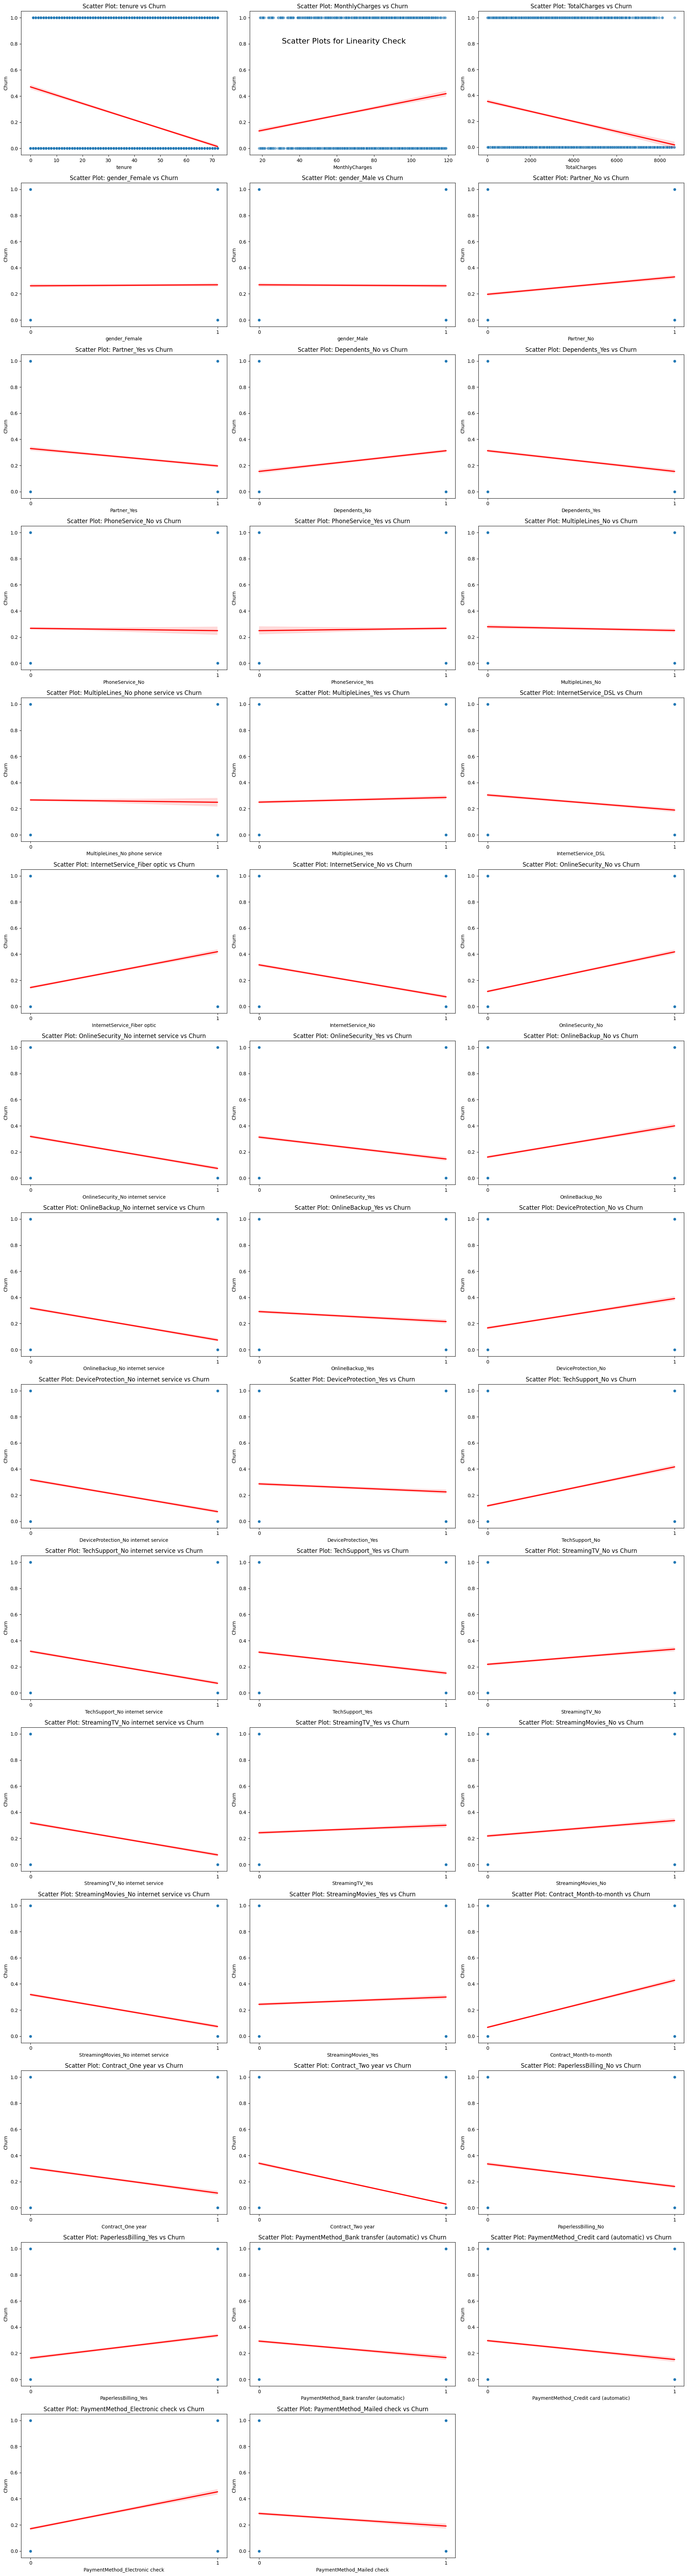


Correlations with Churn:
Contract_Month-to-month                    0.405103
tenure                                    -0.352229
OnlineSecurity_No                          0.342637
TechSupport_No                             0.337281
InternetService_Fiber optic                0.308020
Contract_Two year                         -0.302253
PaymentMethod_Electronic check             0.301919
OnlineBackup_No                            0.268005
DeviceProtection_No                        0.252481
InternetService_No                        -0.227890
DeviceProtection_No internet service      -0.227890
TechSupport_No internet service           -0.227890
StreamingTV_No internet service           -0.227890
OnlineBackup_No internet service          -0.227890
OnlineSecurity_No internet service        -0.227890
StreamingMovies_No internet service       -0.227890
TotalCharges                              -0.199037
MonthlyCharges                             0.193356
PaperlessBilling_No                   

In [ ]:
# Ensure X contains all numerical variables and encoded categorical variables
X = pd.concat([df[numerical_cols], encoded_df], axis=1)
y = df['Churn']

# Calculate the required number of rows and columns
n_features = X.shape[1]
n_cols = 3
n_rows = math.ceil(n_features / n_cols)

# Create a figure large enough to accommodate all subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
fig.suptitle('Scatter Plots for Linearity Check', fontsize=16)

# Flatten the axes array for easier indexing
axes = axes.flatten()

for i, column in enumerate(X.columns):
    sns.scatterplot(x=X[column], y=y, ax=axes[i], alpha=0.5)
    sns.regplot(x=X[column], y=y, ax=axes[i], scatter=False, color='red')
    axes[i].set_title(f'Scatter Plot: {column} vs Churn')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Churn')

    # Adjust x-axis ticks for binary variables
    if X[column].nunique() == 2:
        axes[i].set_xticks([0, 1])

# Hide any excess subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# Calculate correlations with Churn for all features
correlations = X.apply(lambda x: x.corr(y))
print("\nCorrelations with Churn:")
print(correlations.sort_values(key=abs, ascending=False))

Doesn't fit linearity

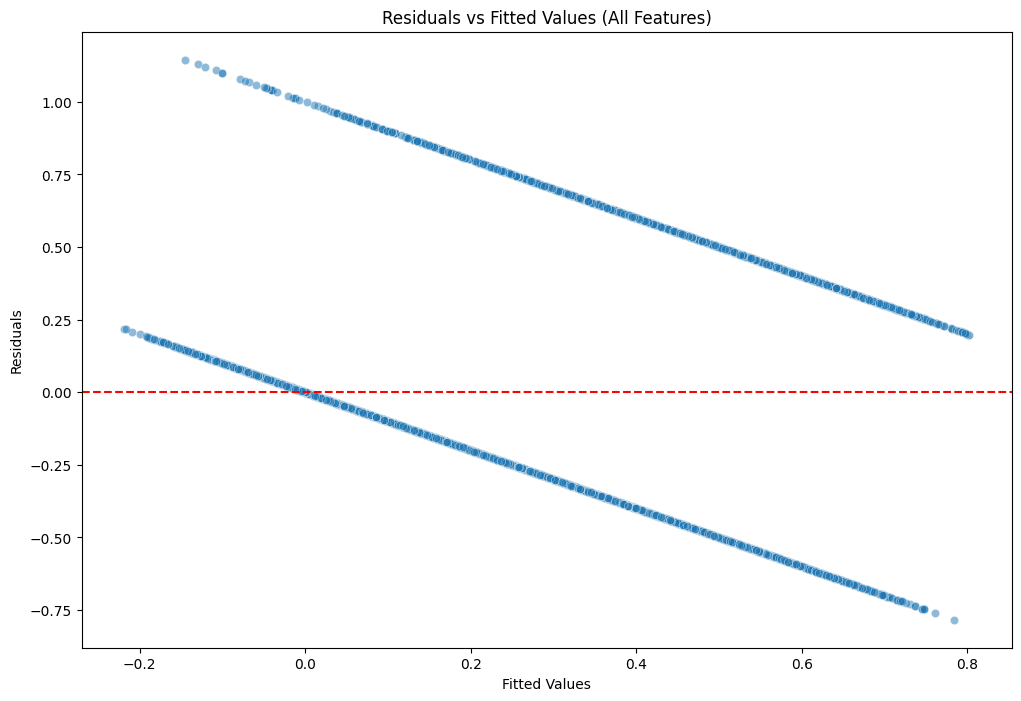

Durbin-Watson statistic: 2.006112081041228


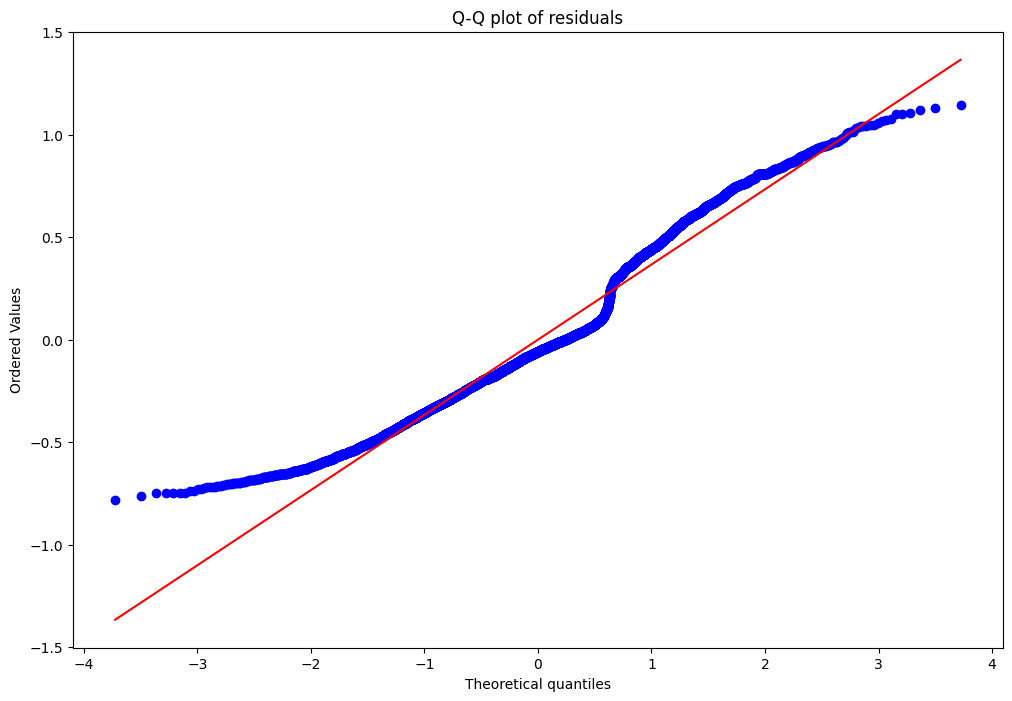

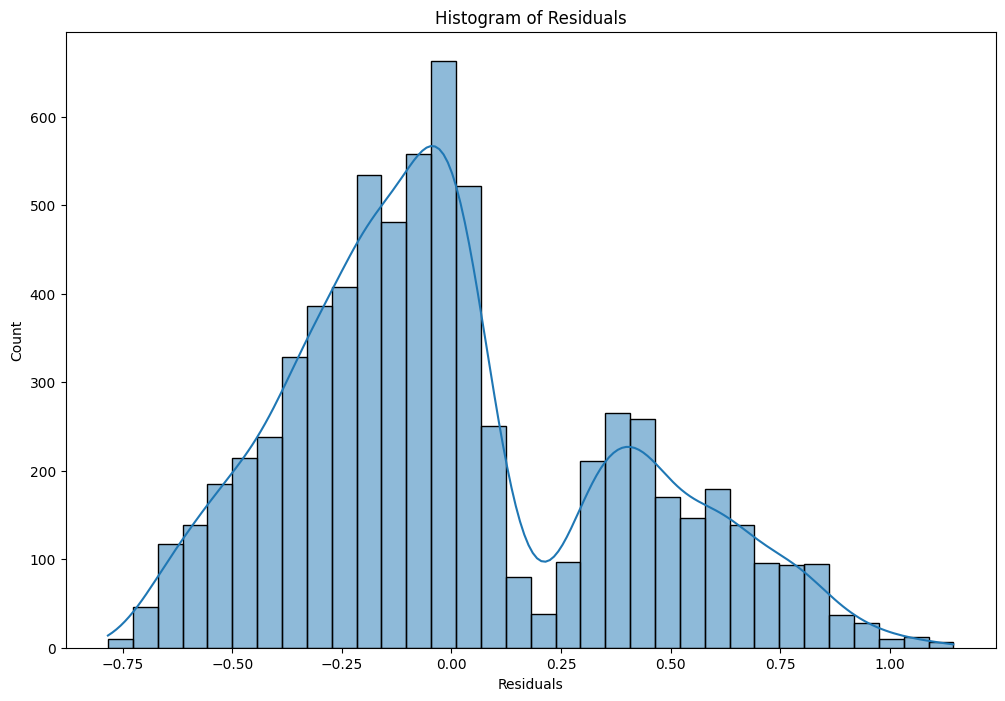

Skewness of residuals: 0.5512068257756992
Kurtosis of residuals: -0.32914652985649395


In [ ]:
X_all = pd.concat([df[numerical_cols], encoded_df], axis=1)
y = df['Churn']

# fit model
model = LinearRegression()
model.fit(X_all, y)

# get prediction and residuals
y_pred = model.predict(X_all)
residuals = y - y_pred

# plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Fitted Values (All Features)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# print
dw_statistic = durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw_statistic}")

# Q-Q plot
fig, ax = plt.subplots(figsize=(12, 8))
stats.probplot(residuals, dist="norm", plot=ax)
ax.set_title("Q-Q plot of residuals")
plt.show()

# histplot
plt.figure(figsize=(12, 8))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.show()

# output
print(f"Skewness of residuals: {skew(residuals)}")
print(f"Kurtosis of residuals: {kurtosis(residuals)}")

Doesn't fit independence and normality

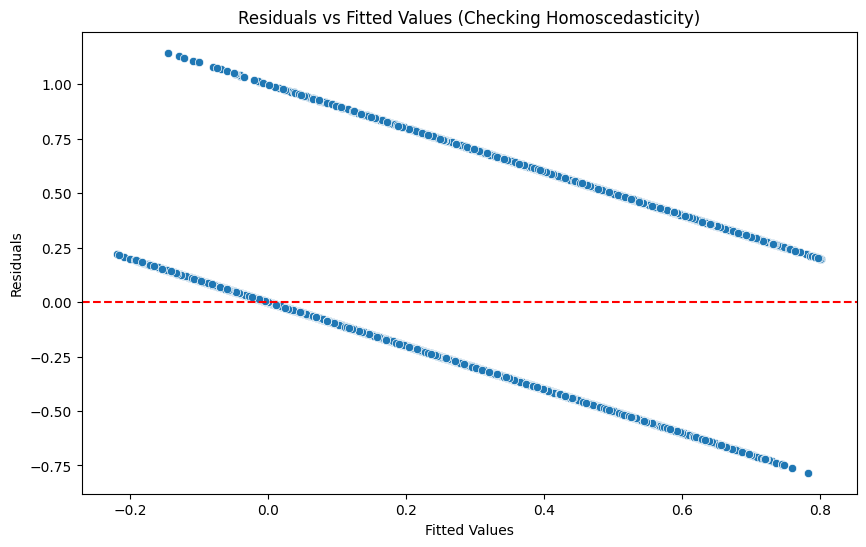

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.title('Residuals vs Fitted Values (Checking Homoscedasticity)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

Doesn't fit Homoscedasticity

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Variance Inflation Factors:
                                   Variable         VIF
4                             gender_Female         inf
8                             Dependents_No         inf
7                               Partner_Yes         inf
6                                Partner_No         inf
5                               gender_Male         inf
9                            Dependents_Yes         inf
10                          PhoneService_No         inf
11                         PhoneService_Yes         inf
12                         MultipleLines_No         inf
16              InternetService_Fiber optic         inf
15                      InternetService_DSL         inf
14                        MultipleLines_Yes         inf
13           MultipleLines_No phone service         inf
29                          TechSupport_Yes         inf
30                           StreamingTV_No         inf
31          StreamingTV_No internet service         inf
32                  

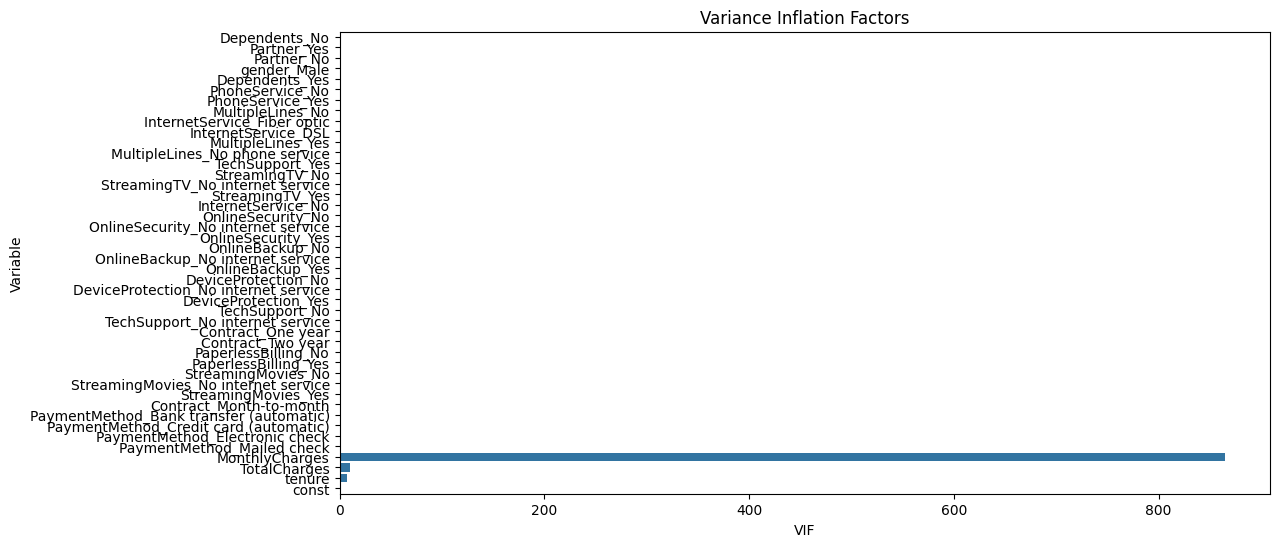

In [ ]:


X_all = pd.concat([df[numerical_cols], encoded_df], axis=1)

# add const
X_with_const = sm.add_constant(X_all)

# calculate VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

# output VIF
vif_data = vif_data.sort_values('VIF', ascending=False)
print("Variance Inflation Factors:")
print(vif_data)

# identify high VIF
high_vif = vif_data[vif_data['VIF'] > 5].sort_values('VIF', ascending=False)
print("\nVariables with high VIF (>5):")
print(high_vif)

plt.figure(figsize=(12, 6))
sns.barplot(x='VIF', y='Variable', data=vif_data.iloc[1:])
plt.title('Variance Inflation Factors')
plt.show()

Doesn't fit No Multicollinearity.

Logistic Assumption Check

<ipython-input-3-be050181905e>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_mean = df.groupby('bin')[target].mean()
<ipython-input-3-be050181905e>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = df.groupby('bin')[col].mean()


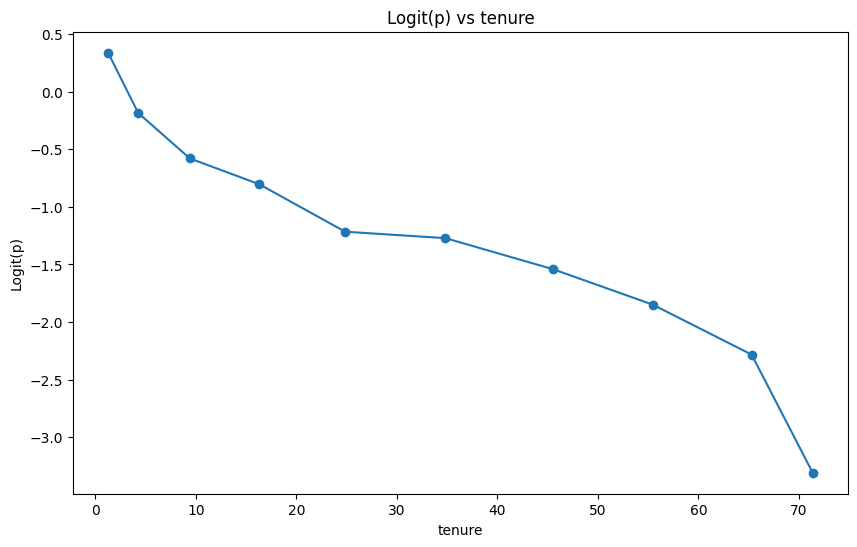

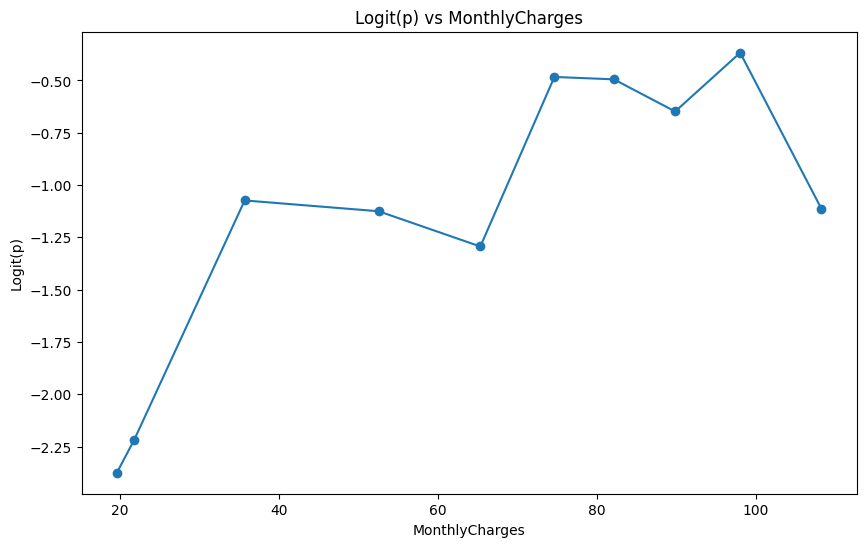

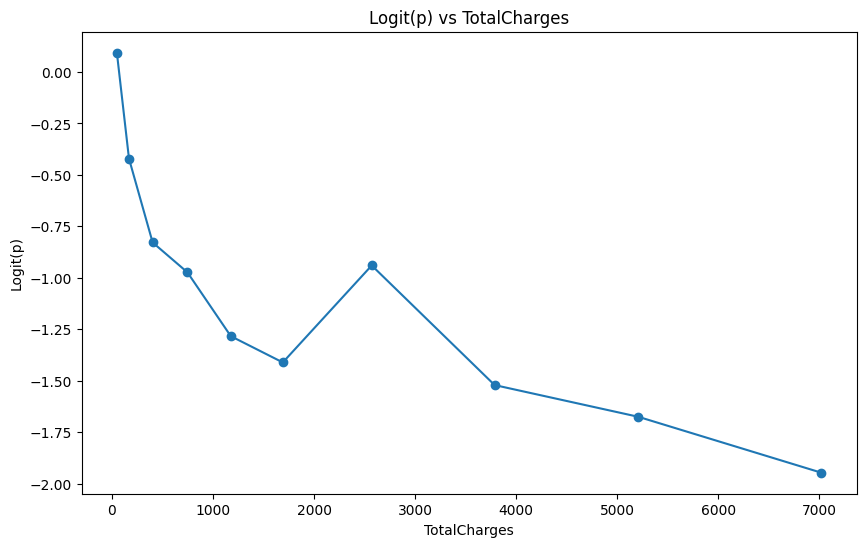

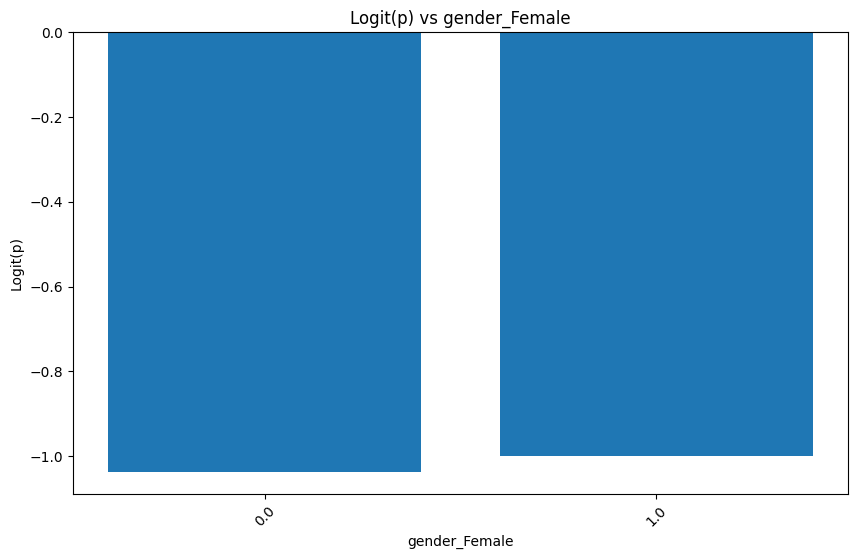

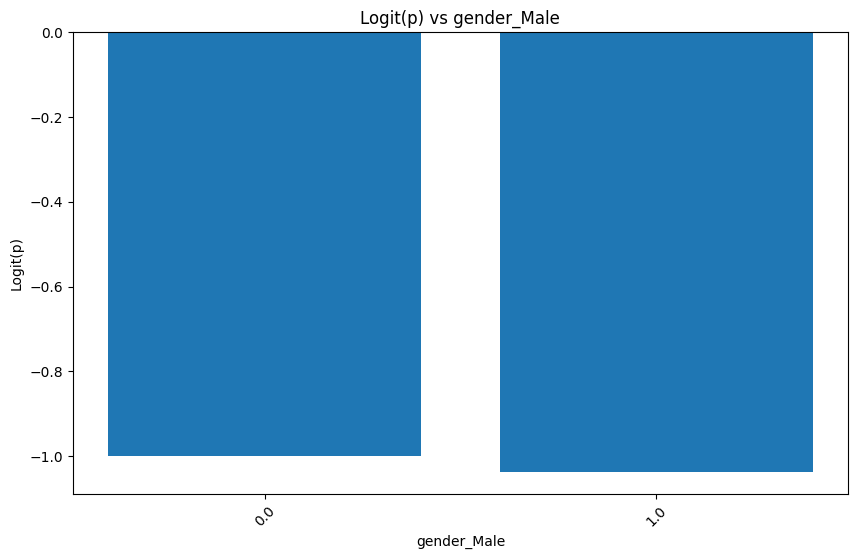

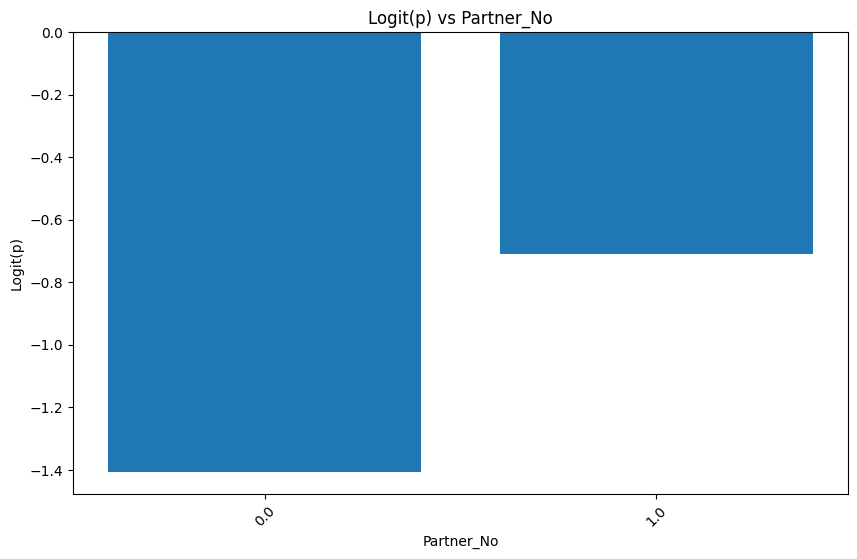

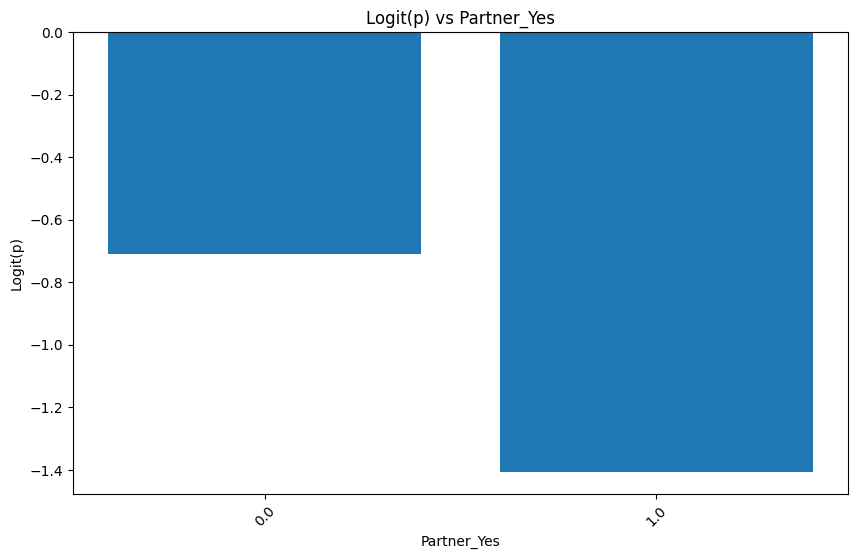

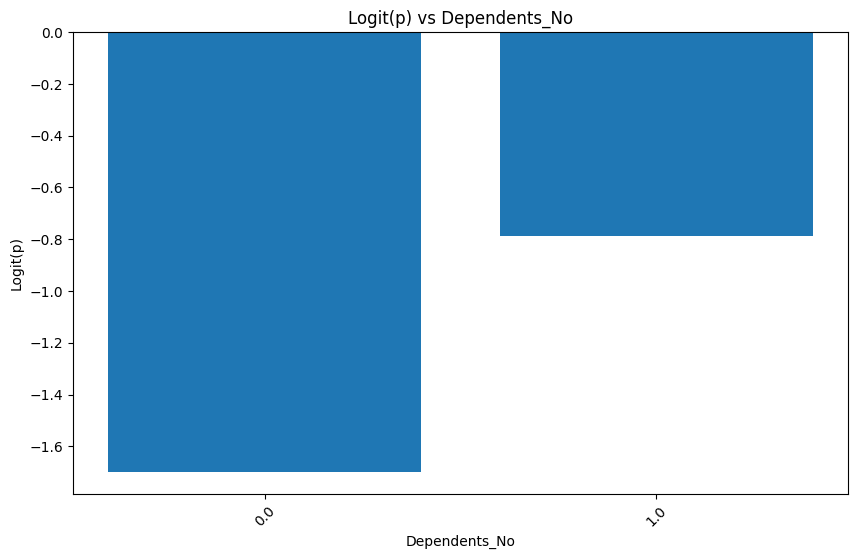

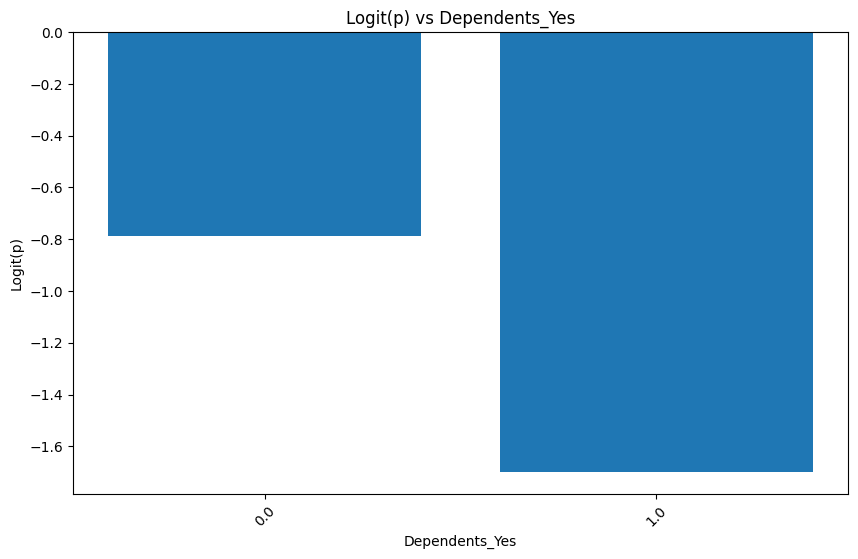

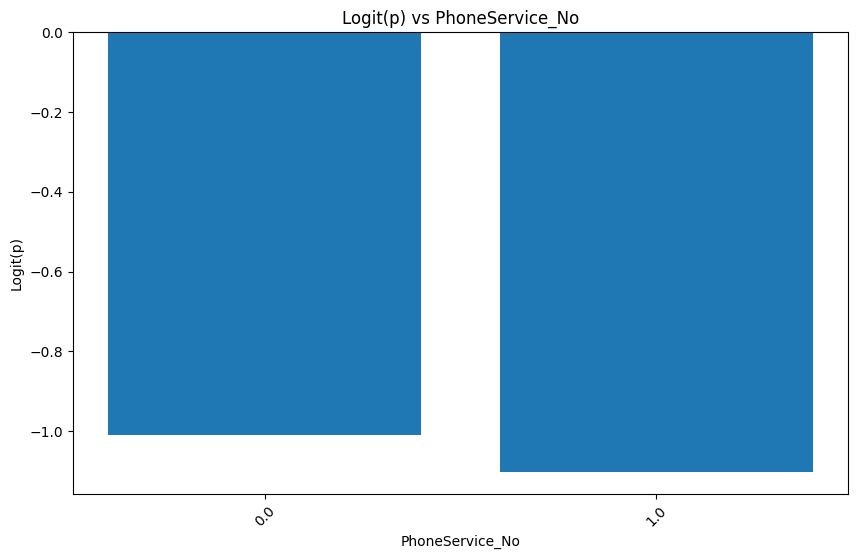

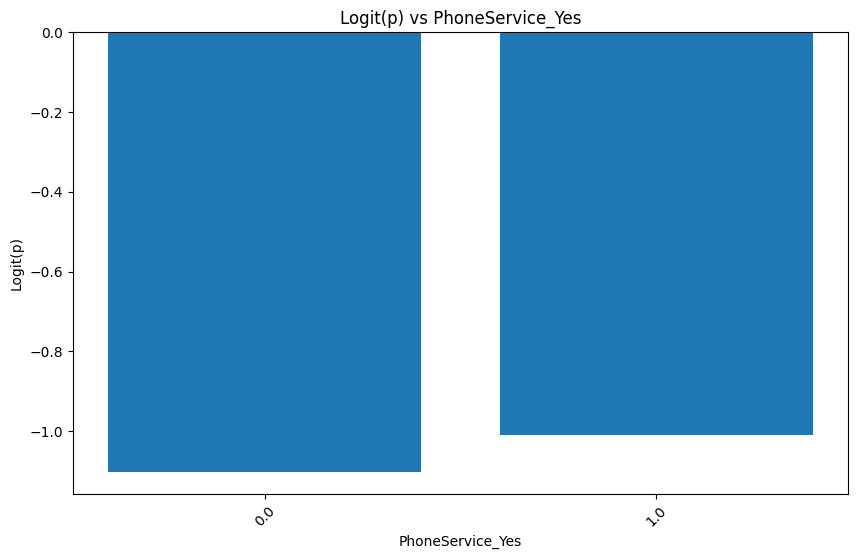

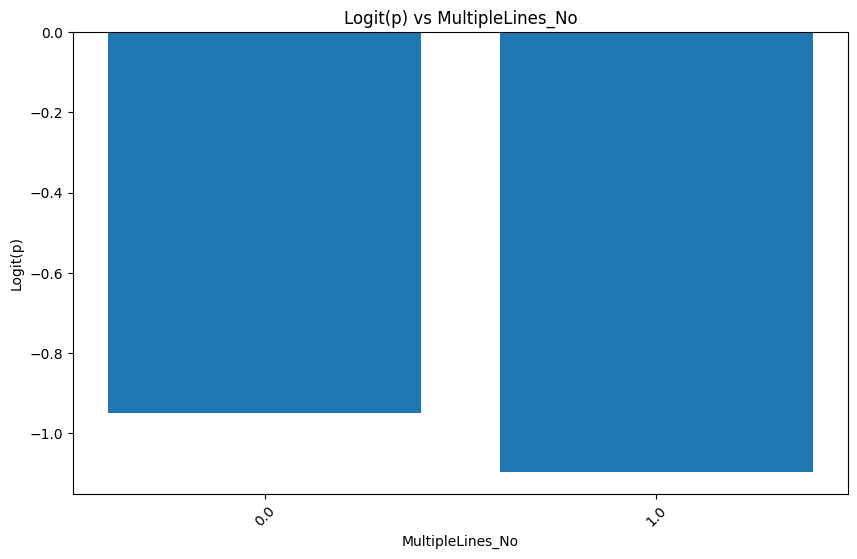

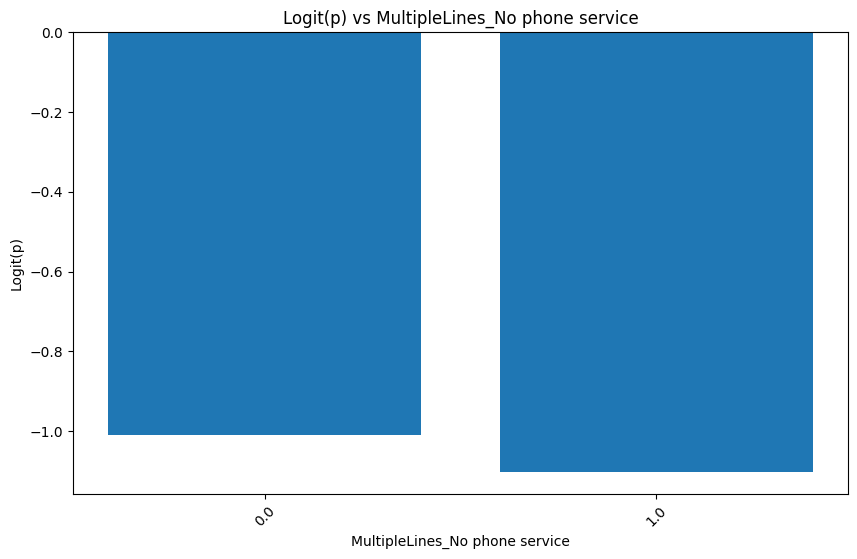

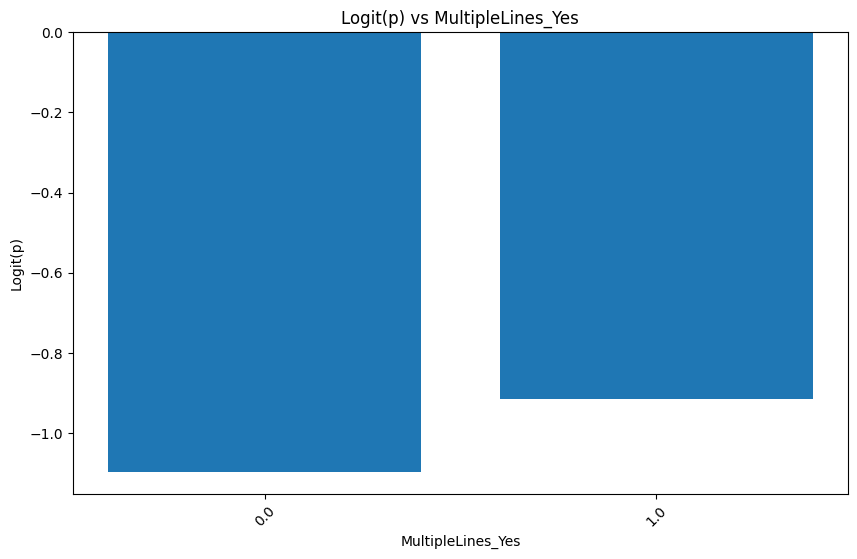

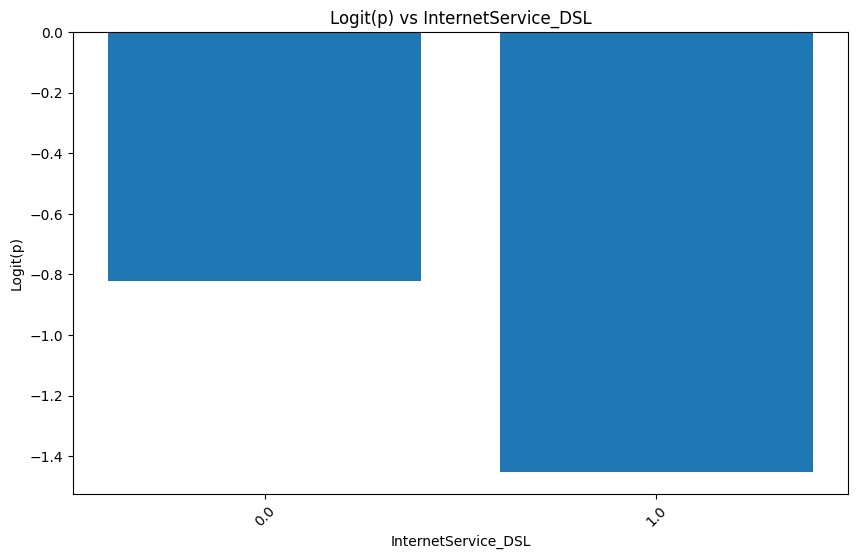

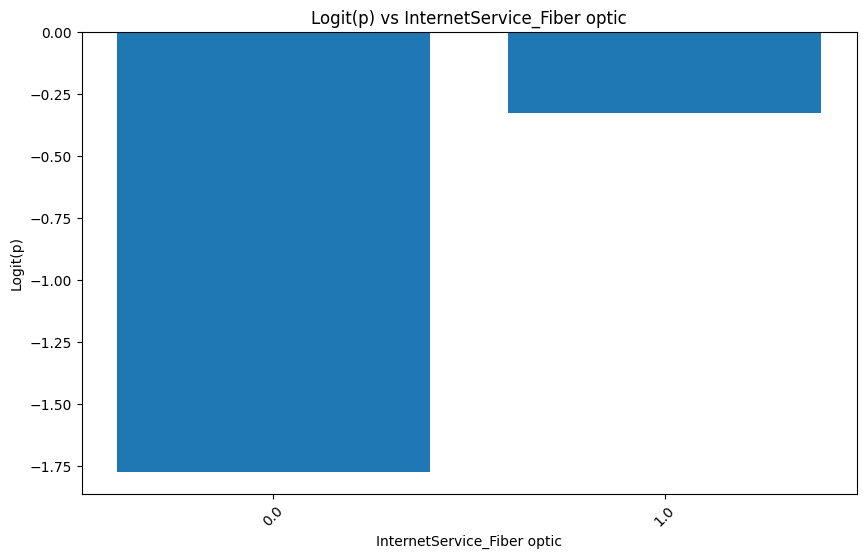

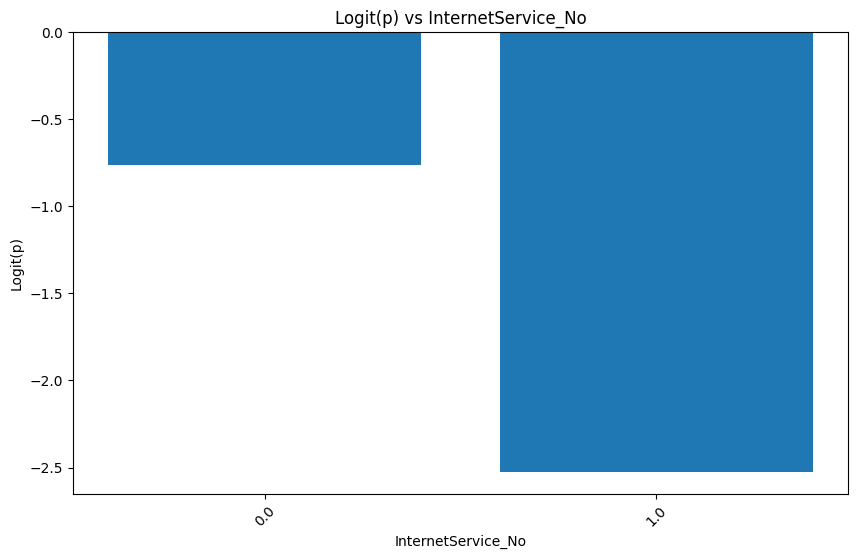

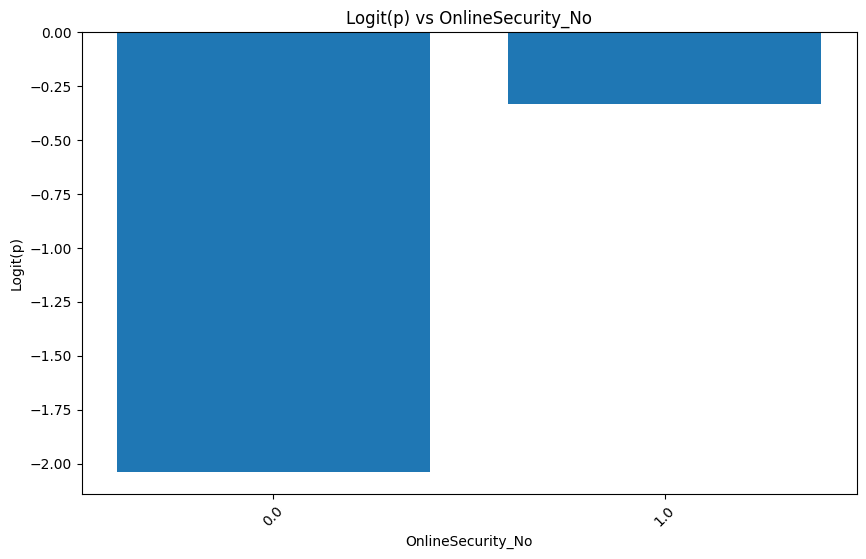

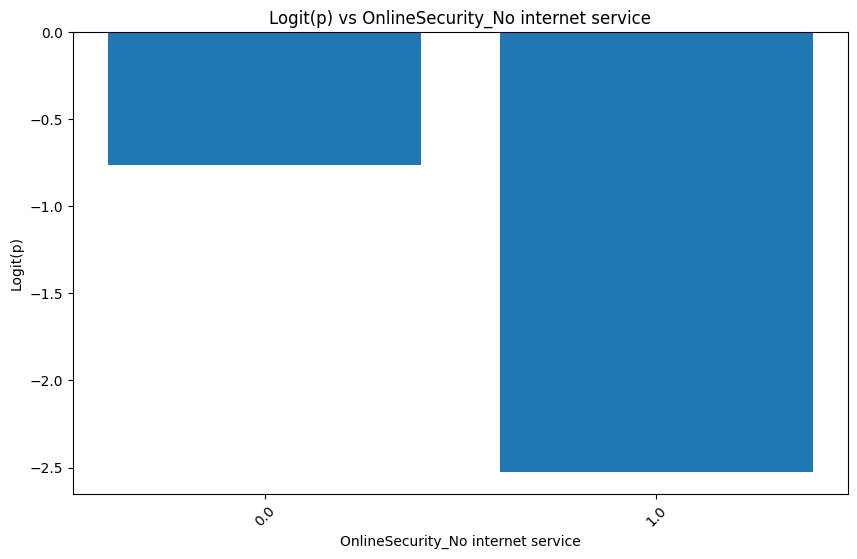

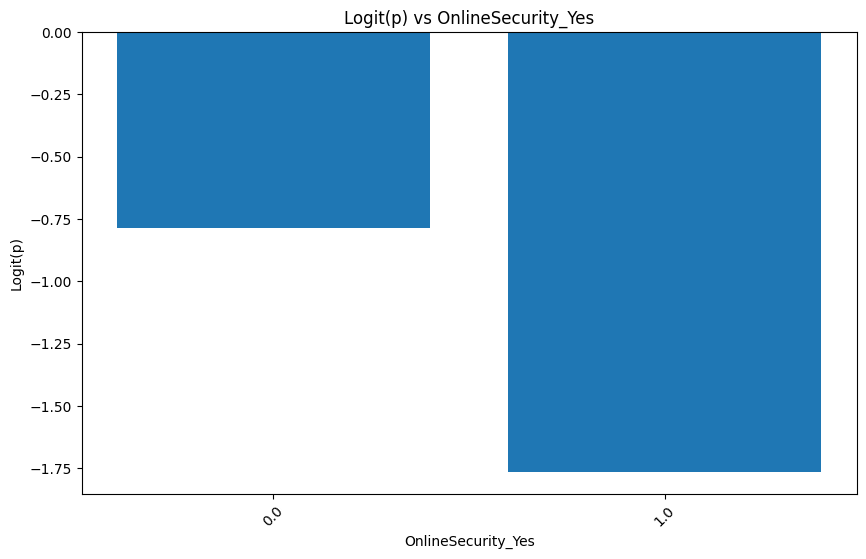

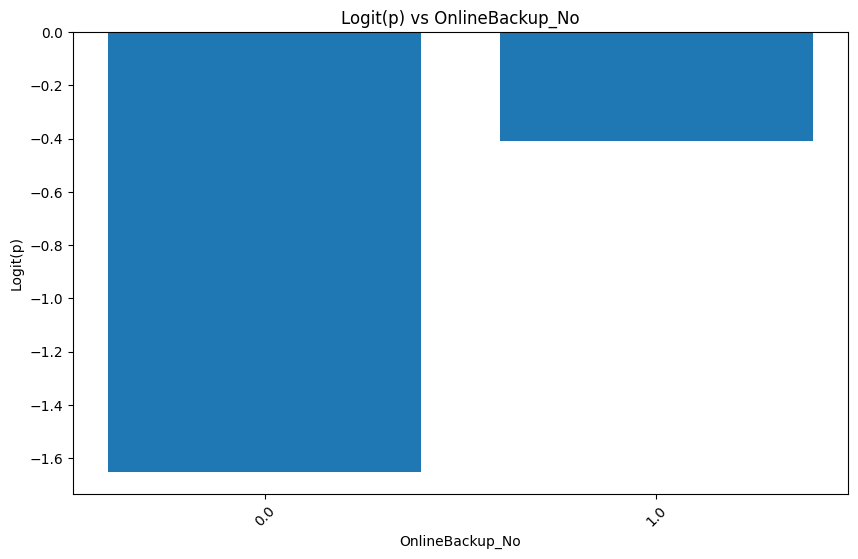

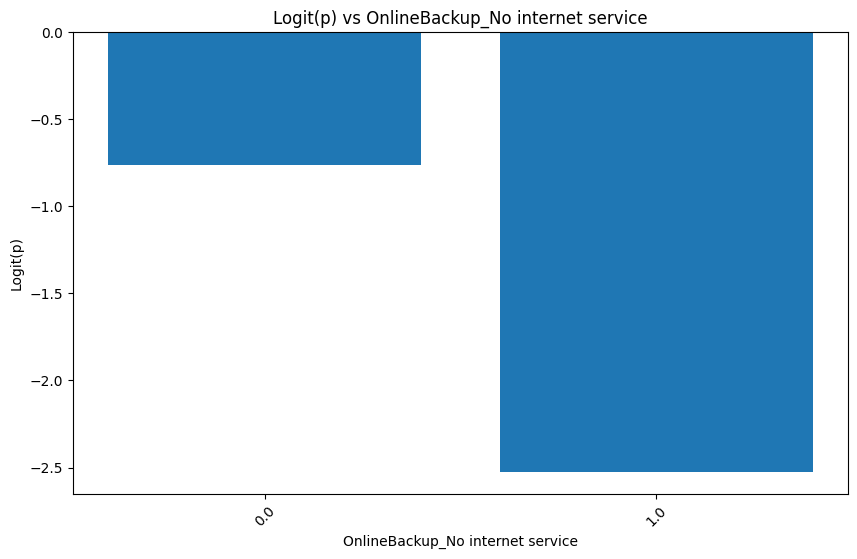

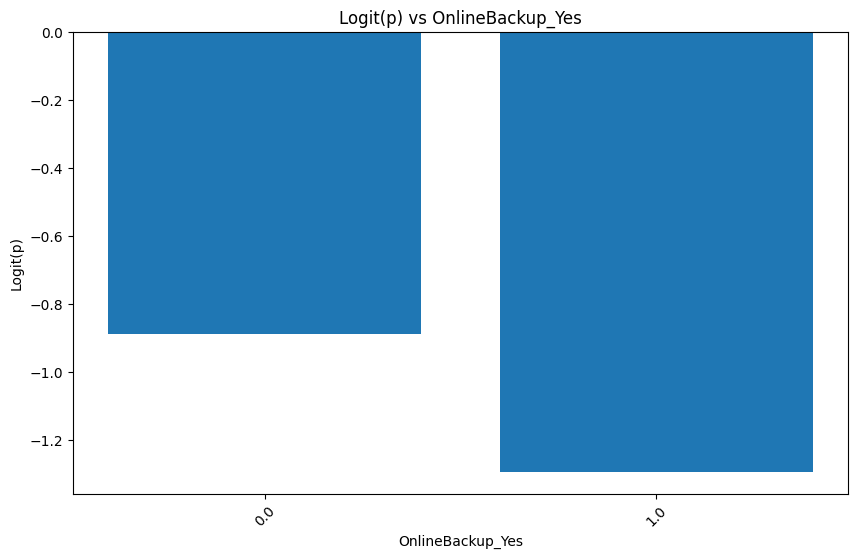

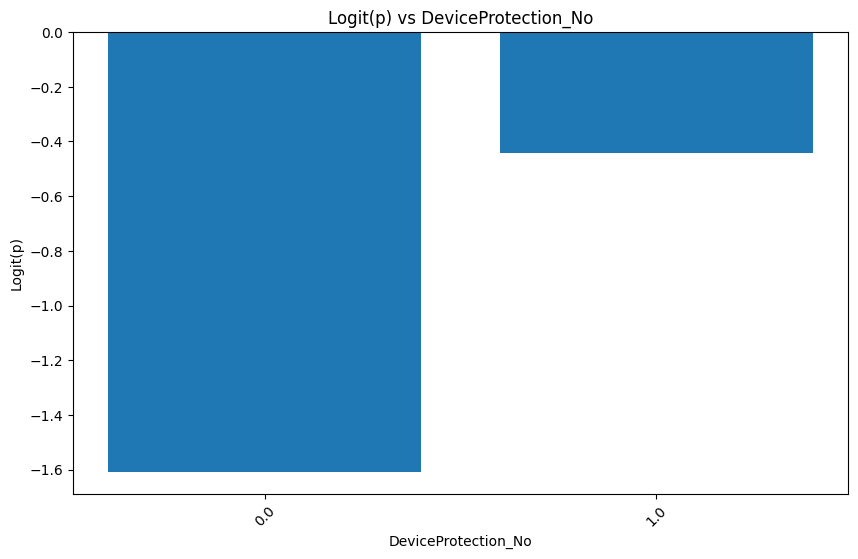

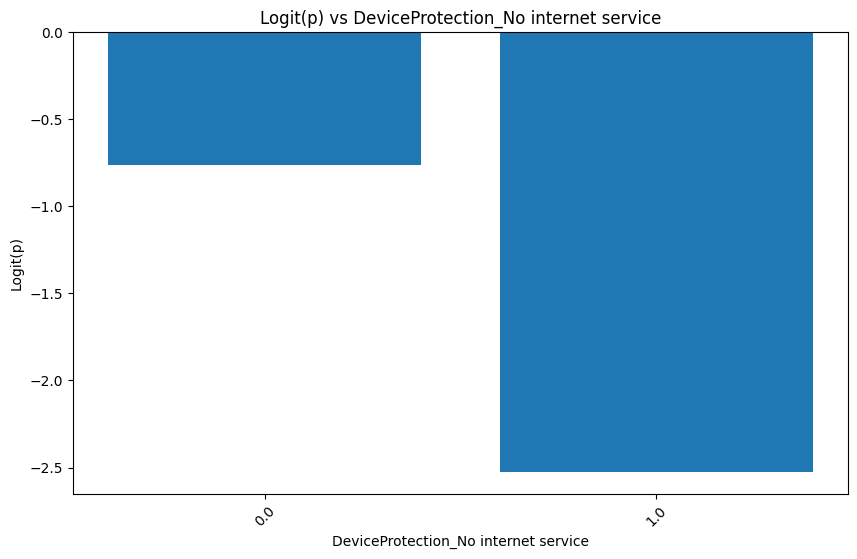

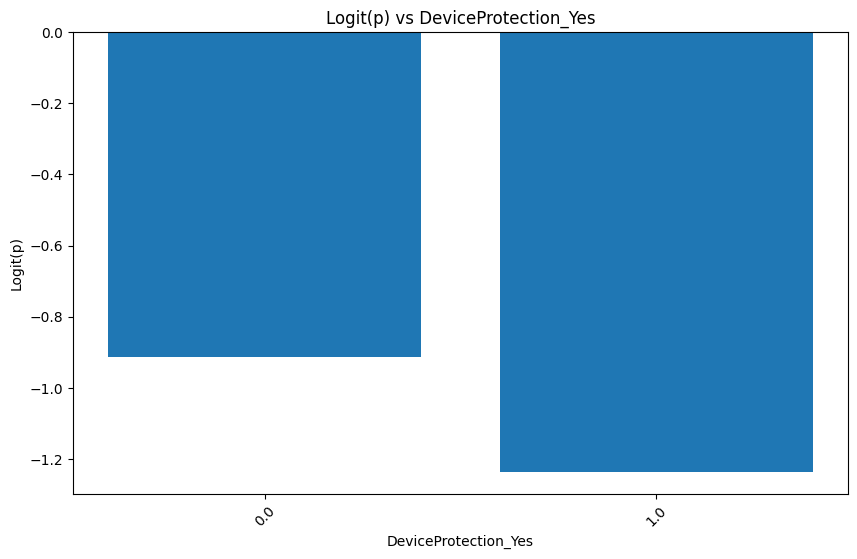

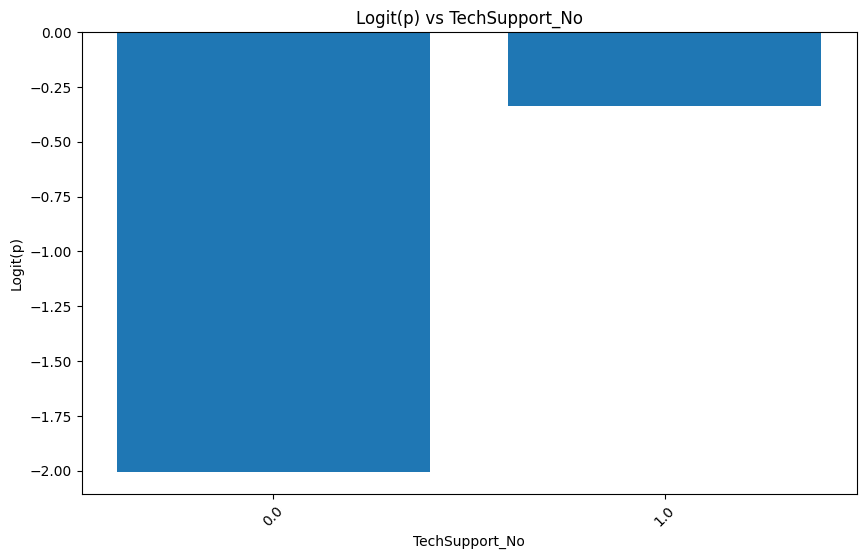

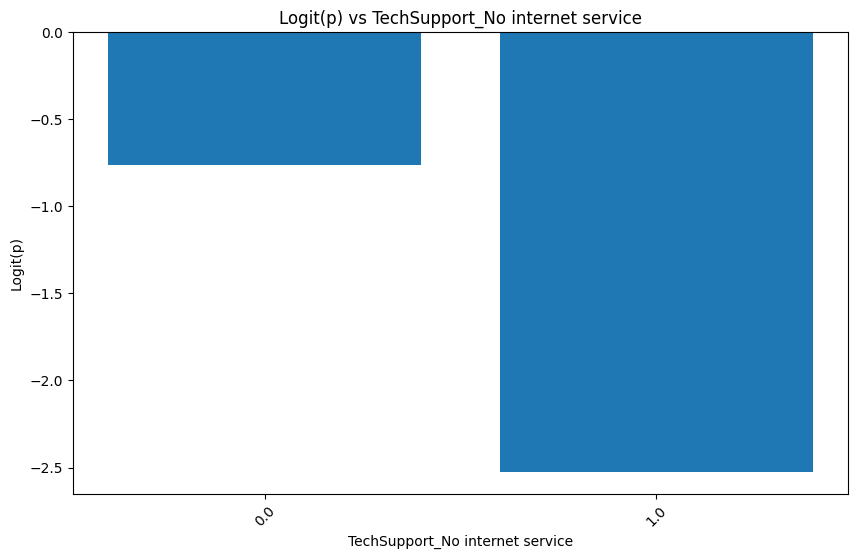

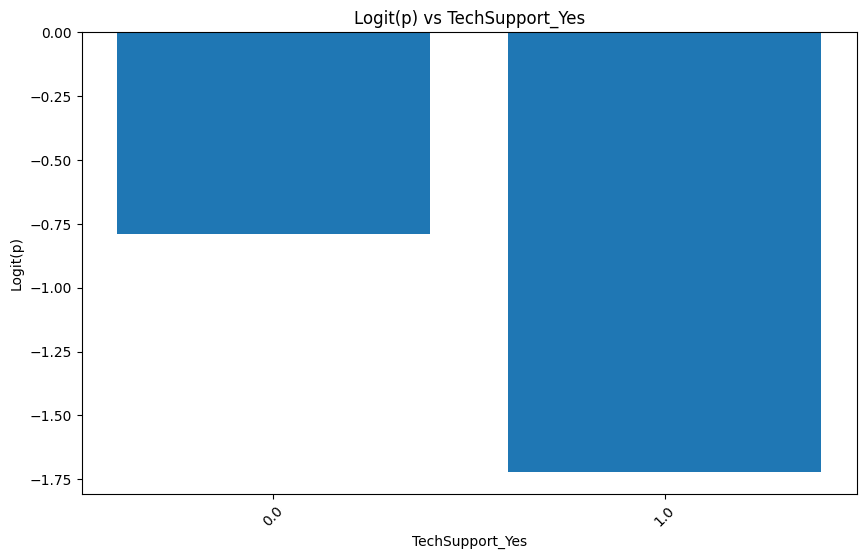

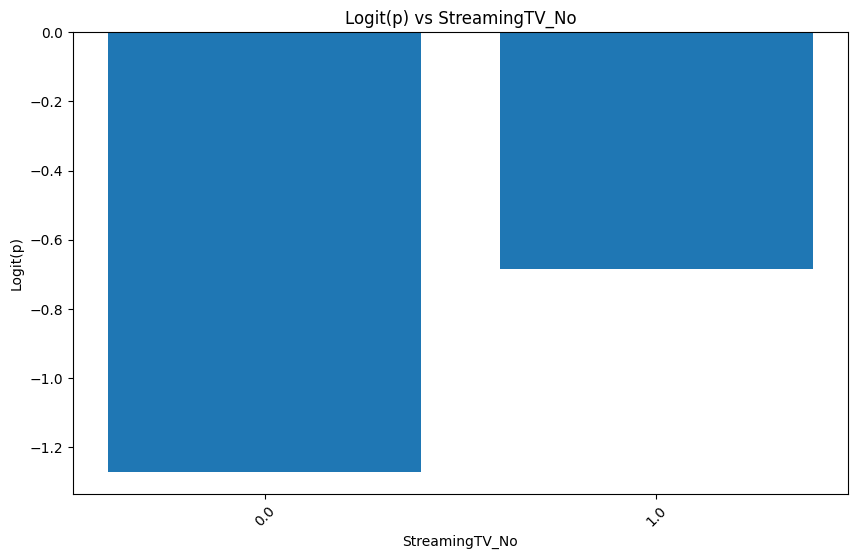

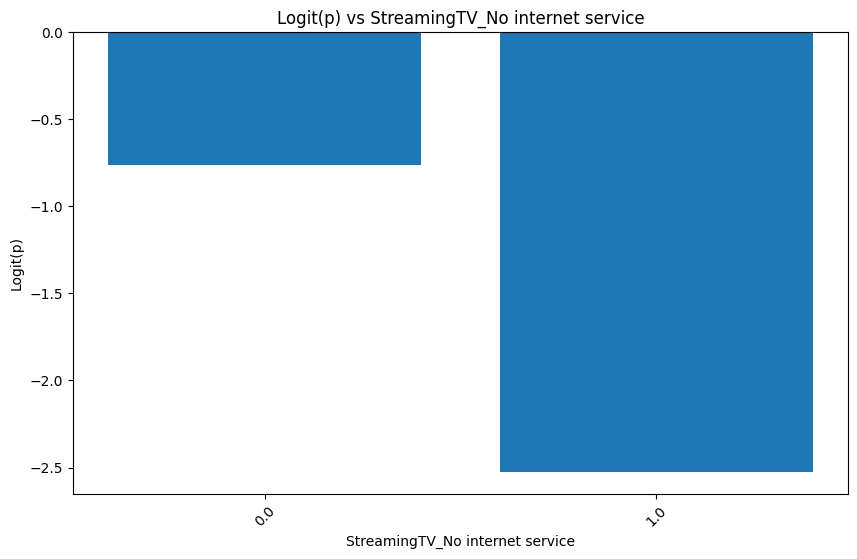

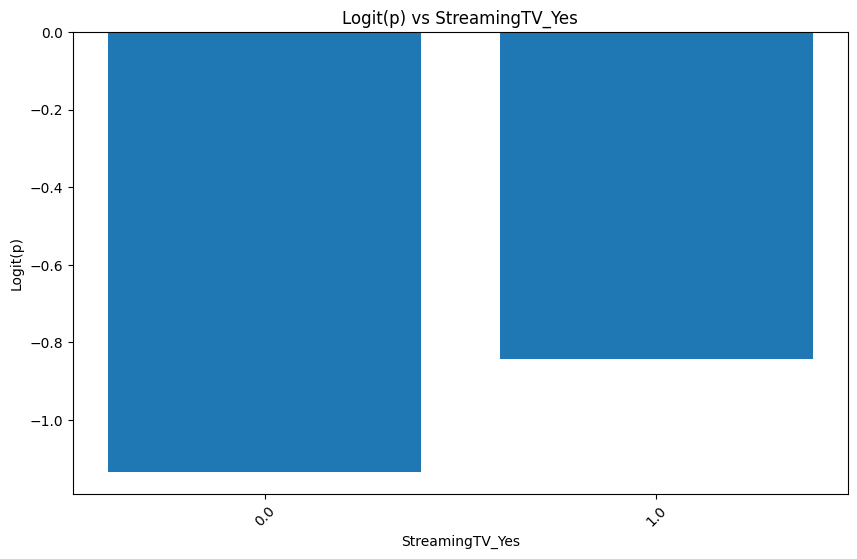

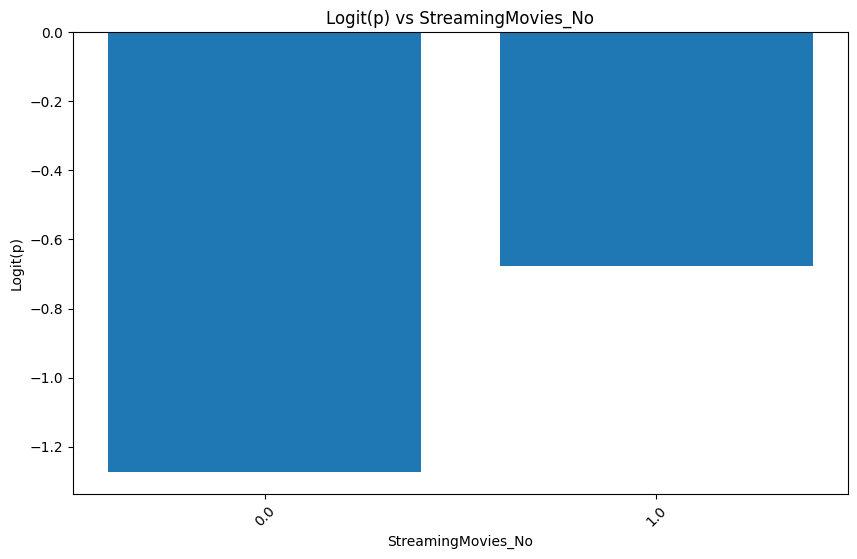

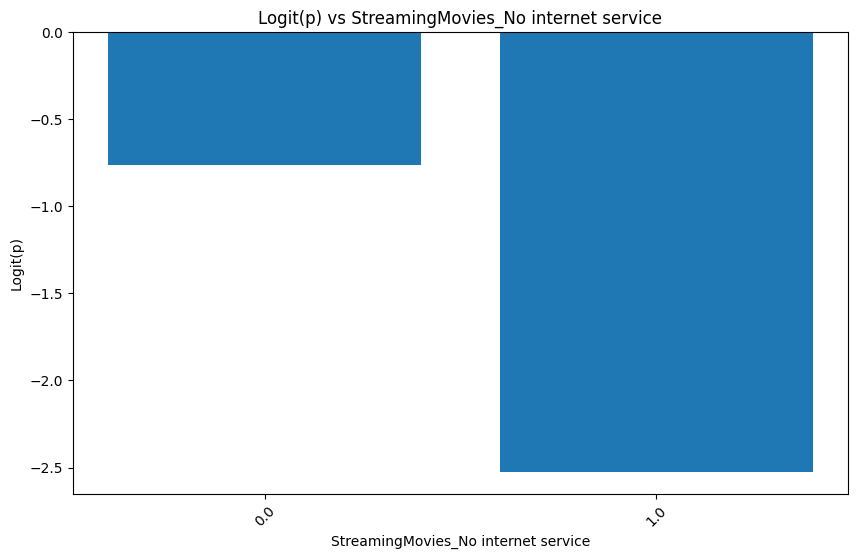

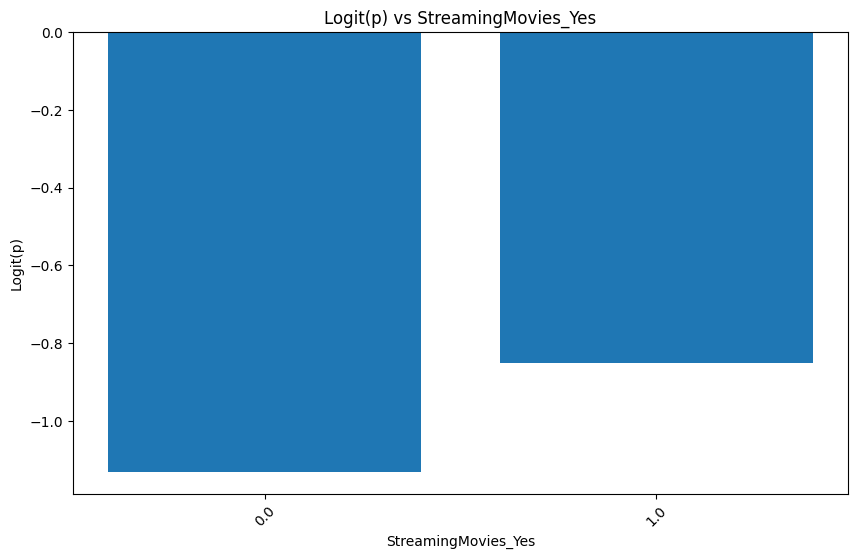

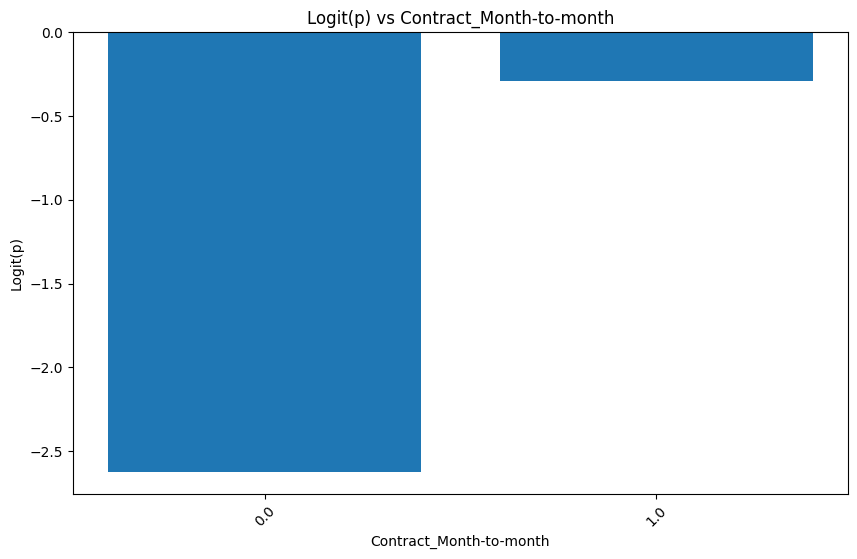

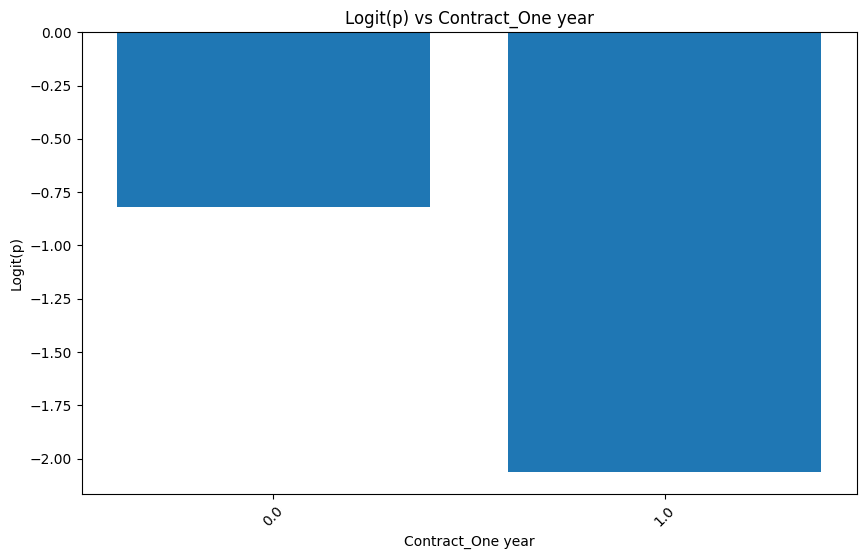

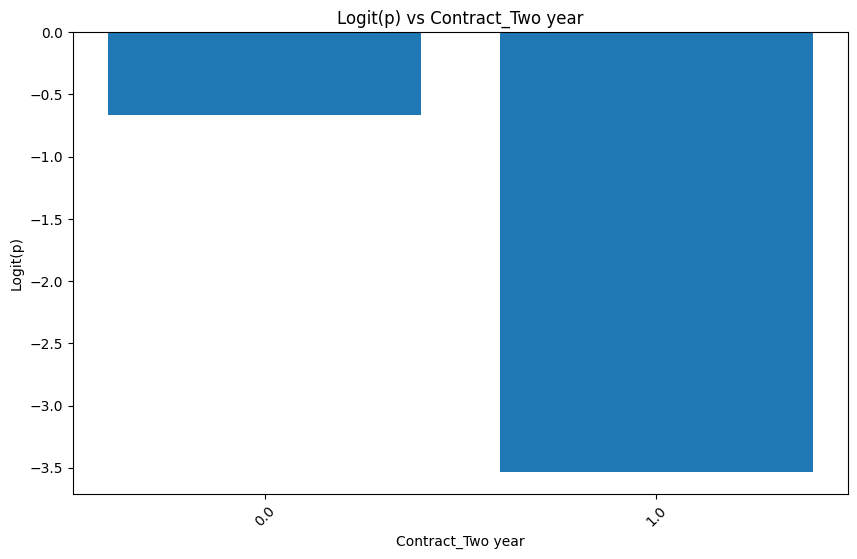

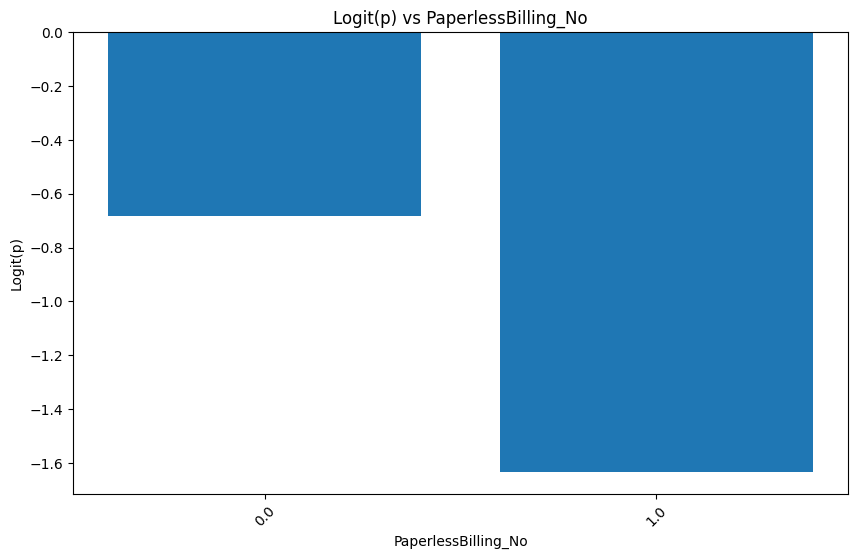

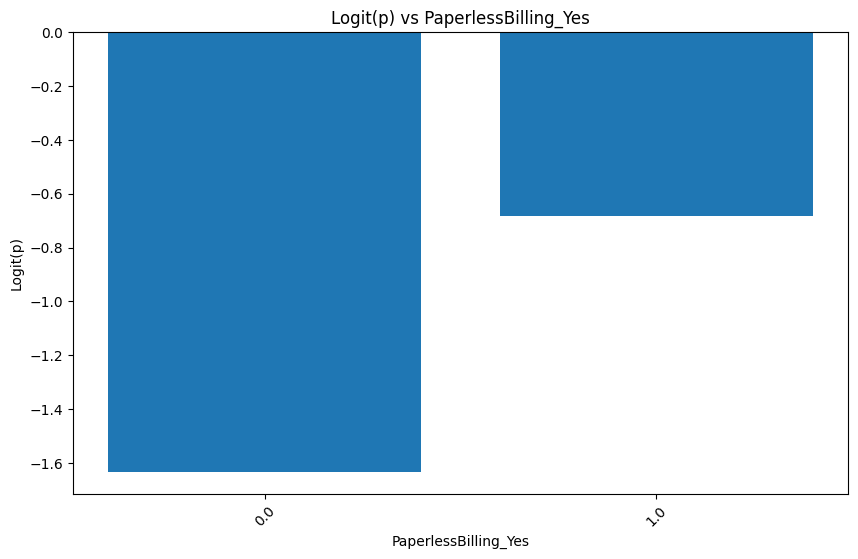

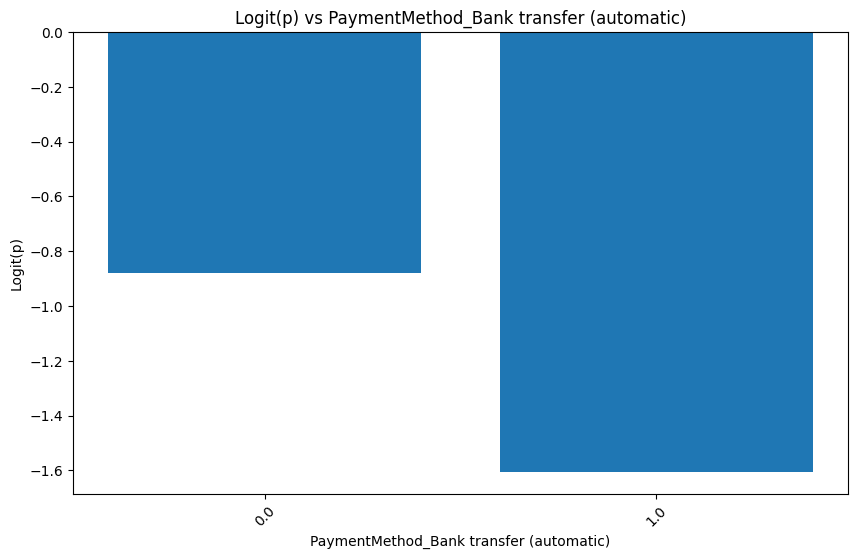

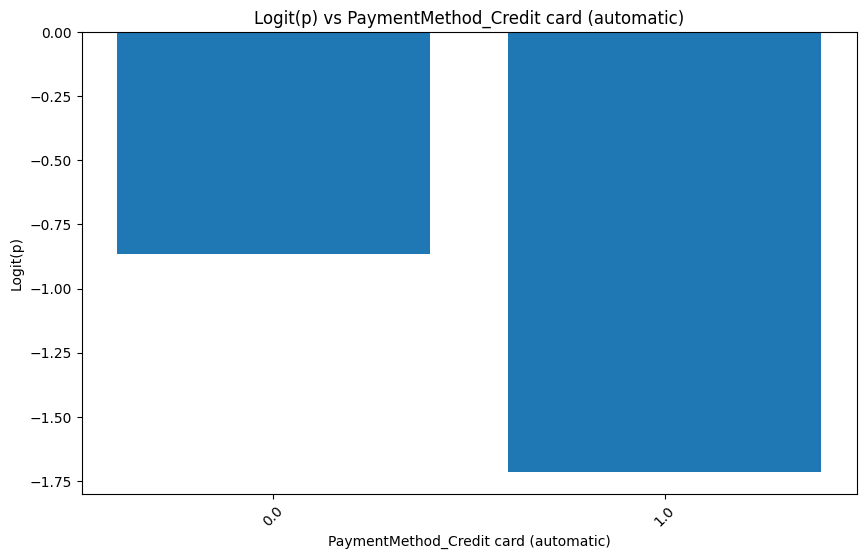

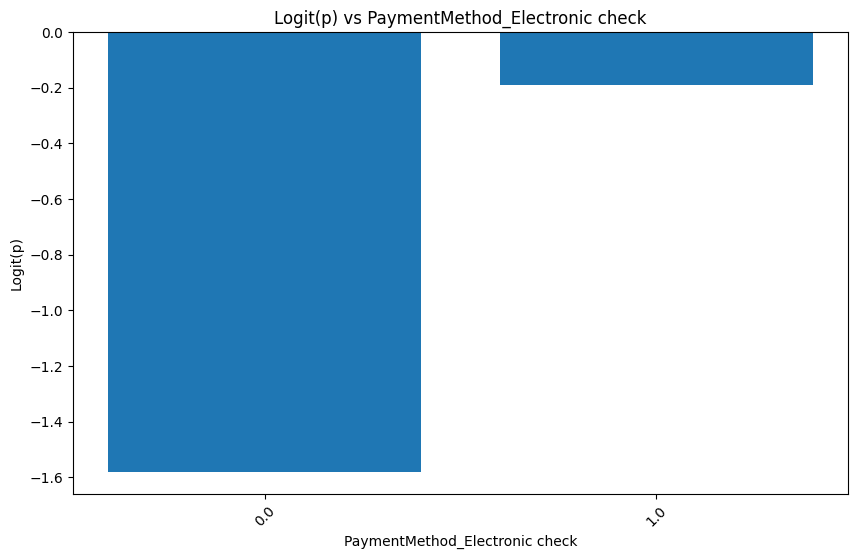

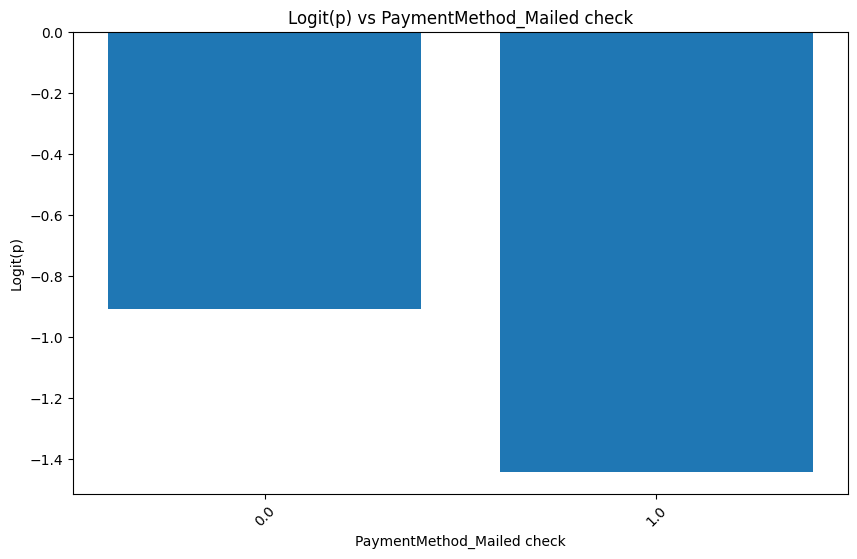

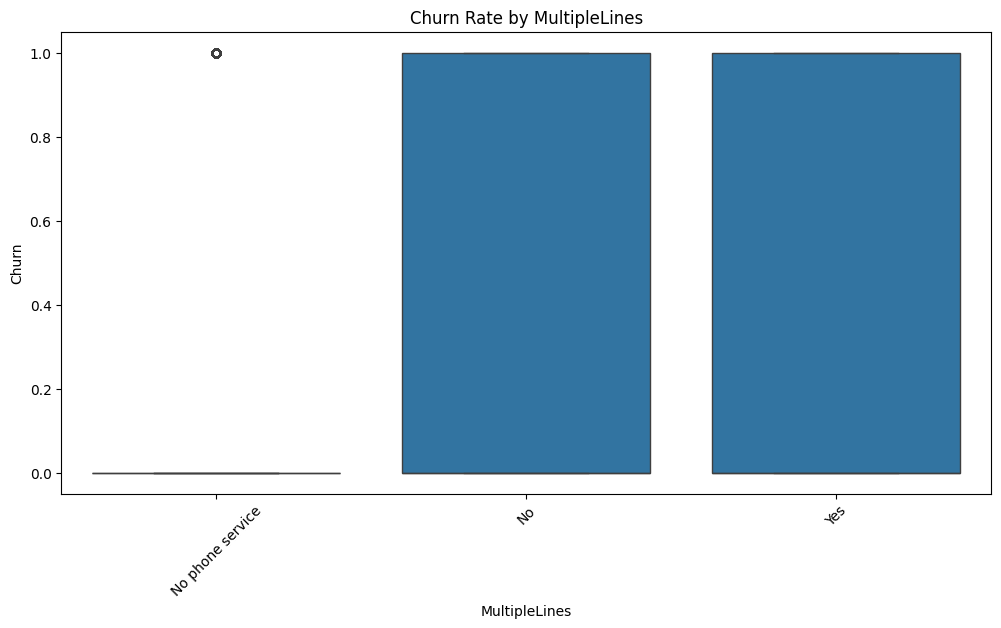

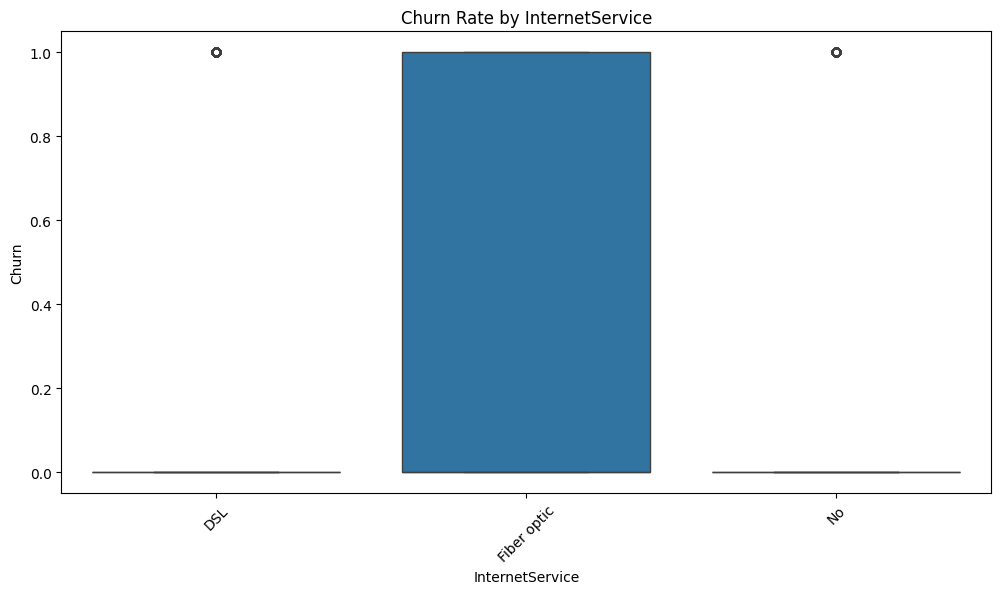

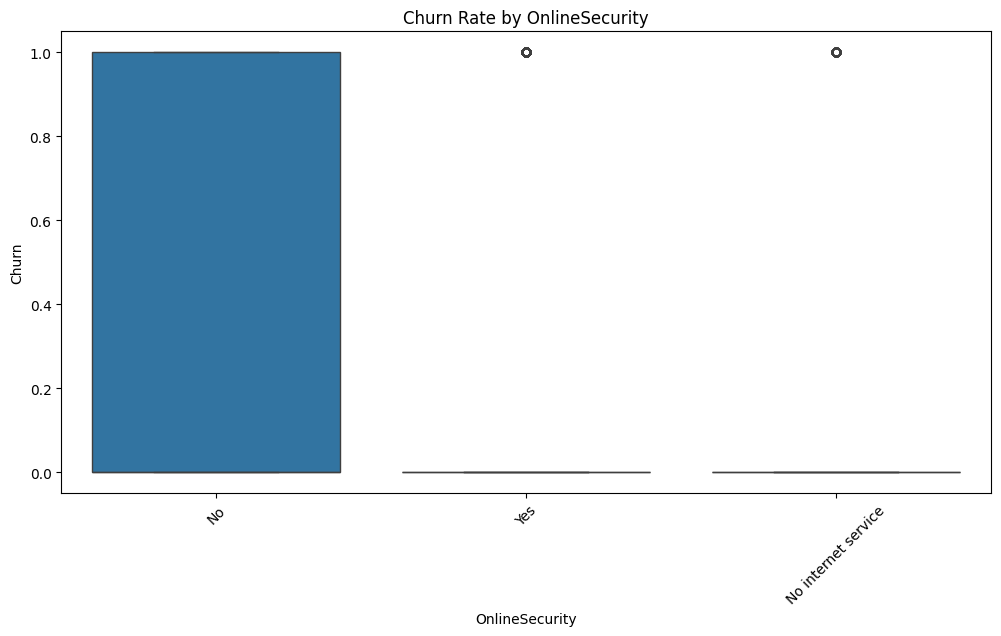

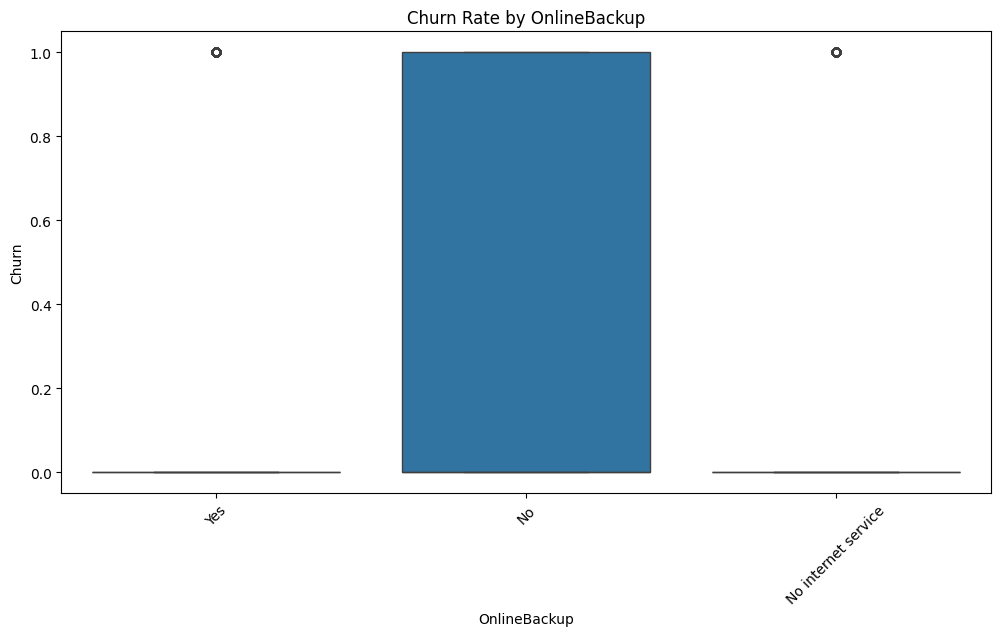

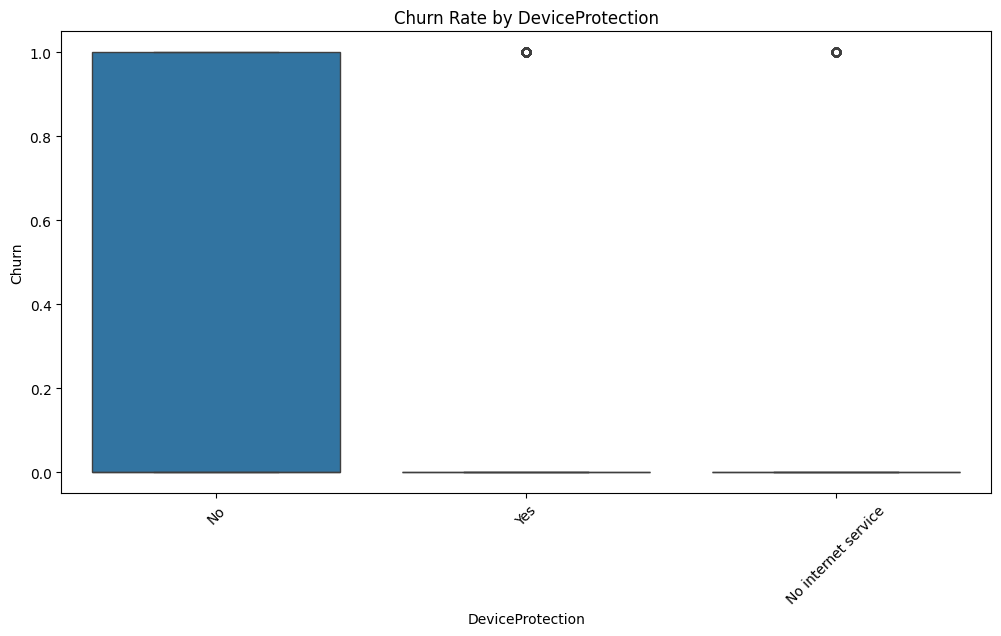

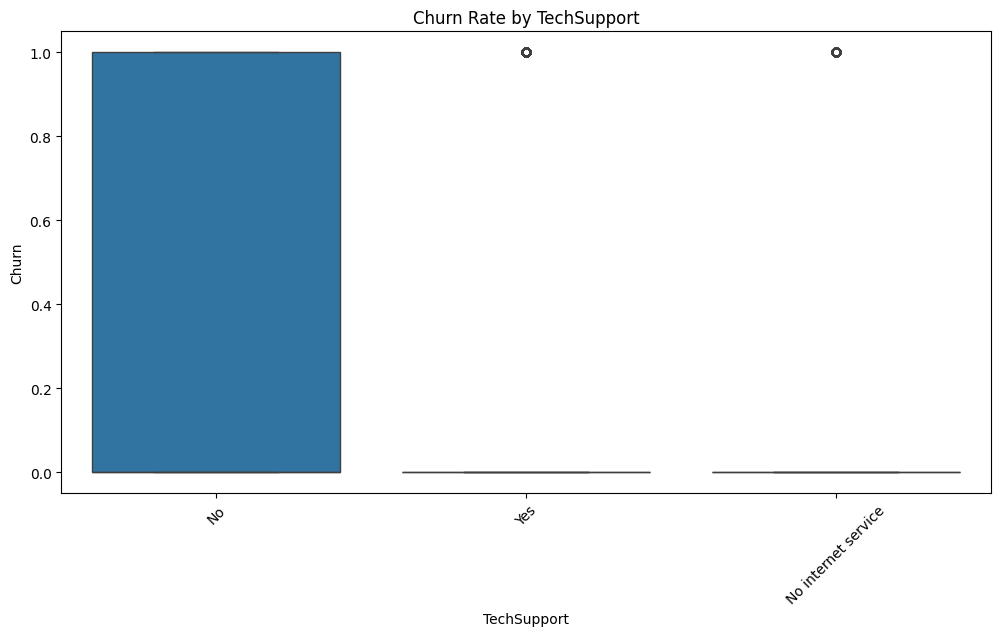

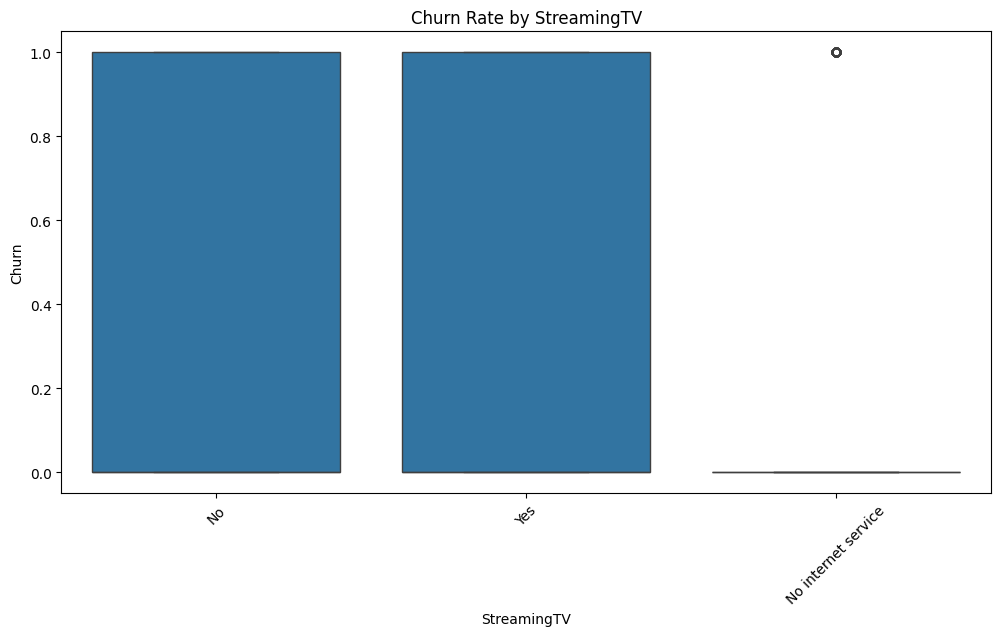

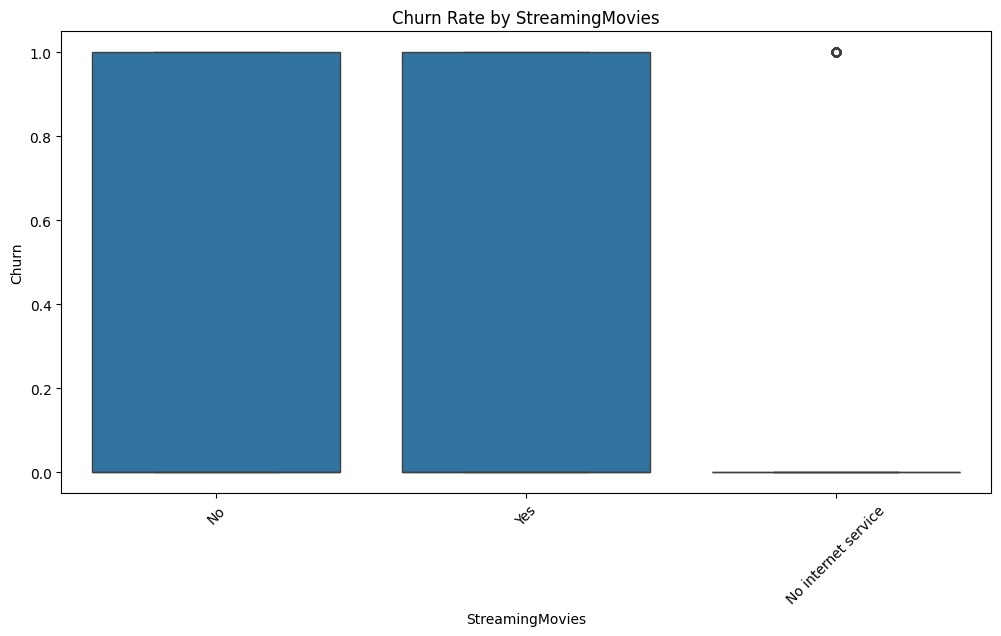

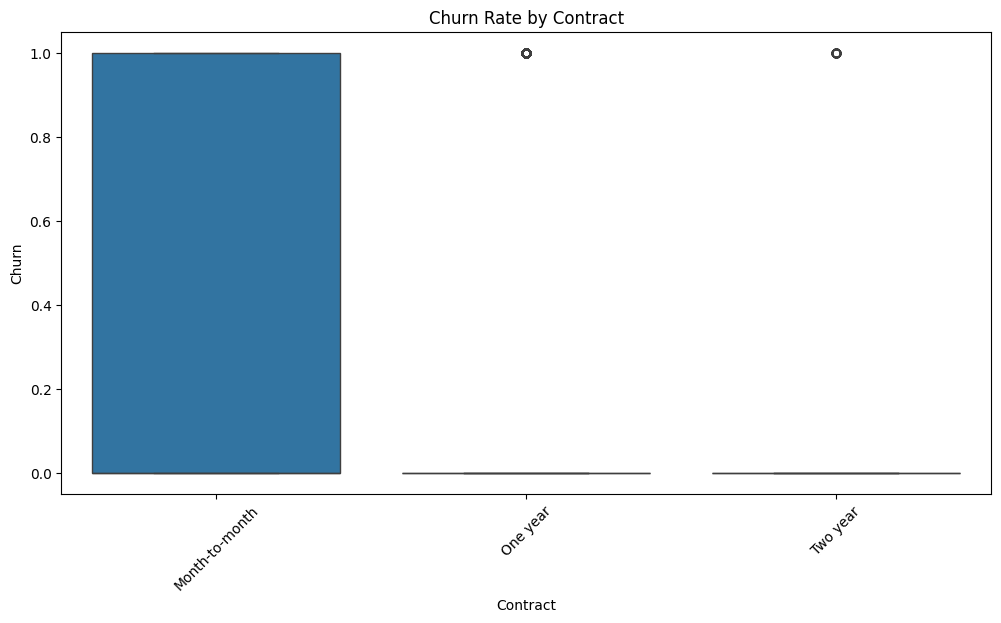

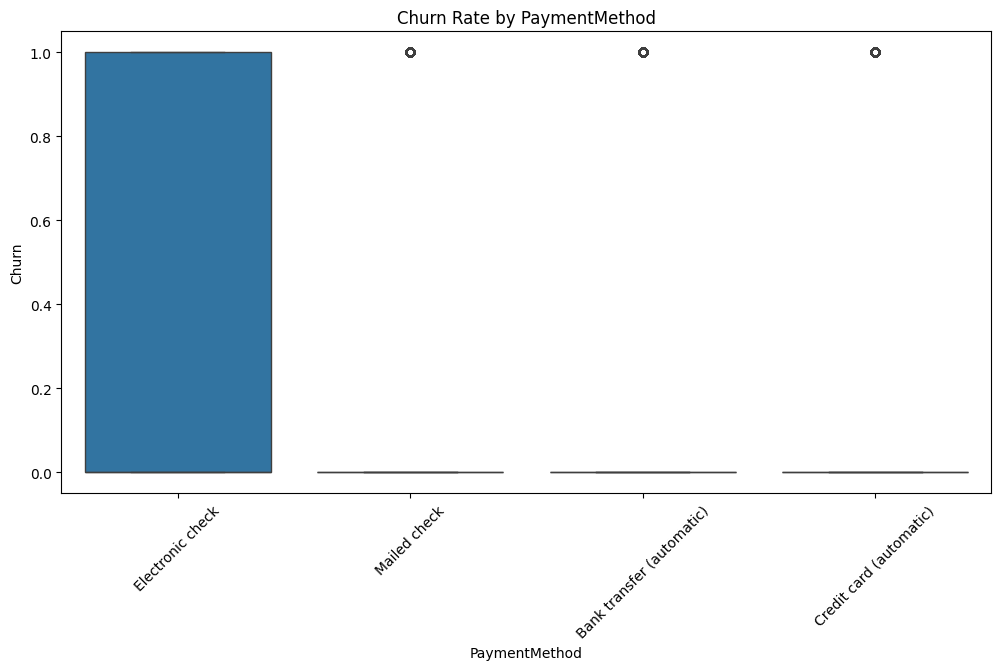

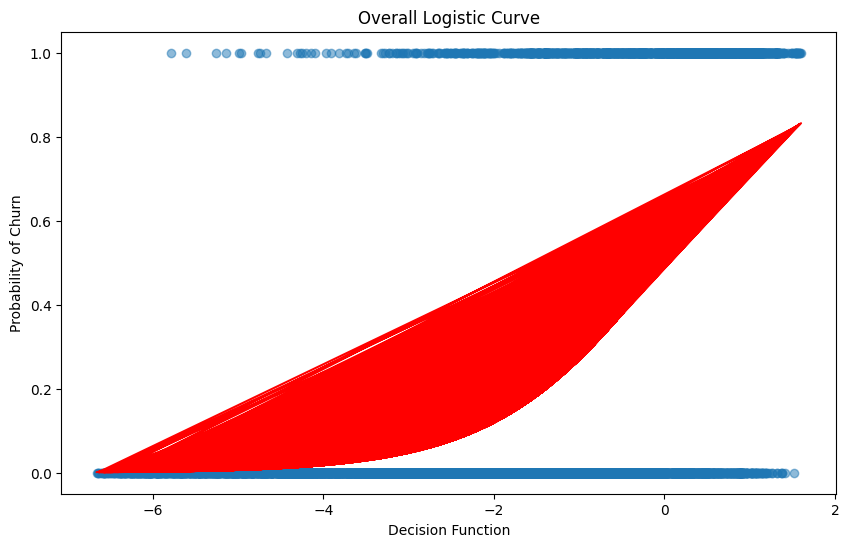

In [ ]:
# Check linearity for numerical features
for col in numerical_cols:
    check_linearity_numerical(df, col)

# Check linearity for encoded categorical features
for col in encoded_df.columns:
    unique_values = encoded_df[col].nunique()
    if unique_values == 2:
        check_linearity_categorical(pd.concat([encoded_df, df['Churn']], axis=1), col)
    else:
        print(f"Skipping multi-category variable: {col}")

# Optional: Visualize relationship for multi-category variables
for col in categorical_cols:
    if df[col].nunique() > 2:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x=col, y='Churn', data=df)
        plt.title(f'Churn Rate by {col}')
        plt.xticks(rotation=45)
        plt.show()

# Overall logistic curve
X = pd.concat([df[numerical_cols], encoded_df], axis=1)
y = df['Churn']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = LogisticRegression()
model.fit(X_scaled, y)

plt.figure(figsize=(10, 6))
plt.scatter(model.decision_function(X_scaled), y, alpha=0.5)
plt.plot(model.decision_function(X_scaled), model.predict_proba(X_scaled)[:, 1], color='red')
plt.title('Overall Logistic Curve')
plt.xlabel('Decision Function')
plt.ylabel('Probability of Churn')
plt.show()

Only Tenure shows linearity

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Variance Inflation Factors:
                                   Variable         VIF
4                             gender_Female         inf
8                             Dependents_No         inf
7                               Partner_Yes         inf
6                                Partner_No         inf
5                               gender_Male         inf
9                            Dependents_Yes         inf
10                          PhoneService_No         inf
11                         PhoneService_Yes         inf
12                         MultipleLines_No         inf
16              InternetService_Fiber optic         inf
15                      InternetService_DSL         inf
14                        MultipleLines_Yes         inf
13           MultipleLines_No phone service         inf
29                          TechSupport_Yes         inf
30                           StreamingTV_No         inf
31          StreamingTV_No internet service         inf
32                  

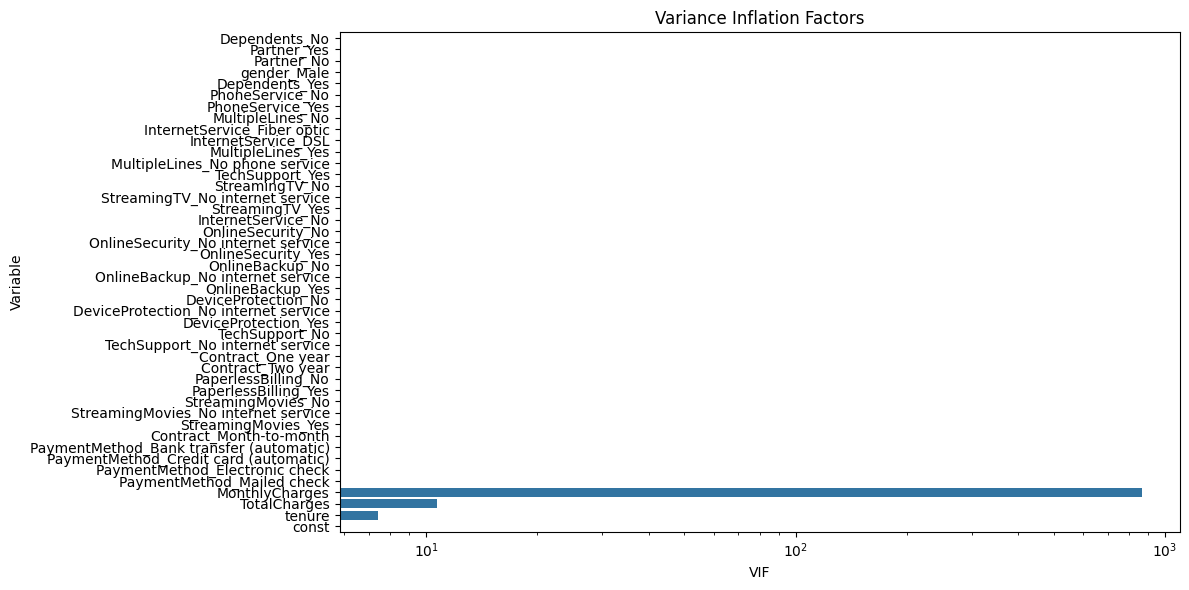

In [ ]:
# Combine numerical and encoded categorical variables
X = pd.concat([df[numerical_cols], encoded_df], axis=1)

# Add constant term
X_with_const = sm.add_constant(X)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

# Sort by VIF value
vif_data = vif_data.sort_values('VIF', ascending=False)

# Print result
print("Variance Inflation Factors:")
print(vif_data)

# Identify high VIF values
high_vif = vif_data[vif_data['VIF'] > 5].sort_values('VIF', ascending=False)
print("\nVariables with high VIF (>5):")
print(high_vif)

# Visualize VIF
plt.figure(figsize=(12, 6))
sns.barplot(x='VIF', y='Variable', data=vif_data.iloc[1:])  # Exclude constant
plt.title('Variance Inflation Factors')
plt.xscale('log')  # Use log scale for better visualization
plt.tight_layout()
plt.show()

Doesn't fit No Multicollinearity.

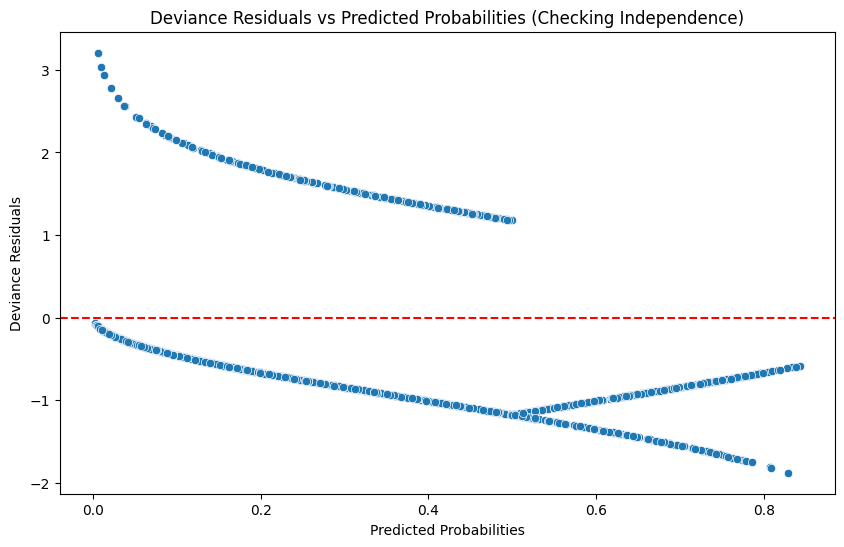

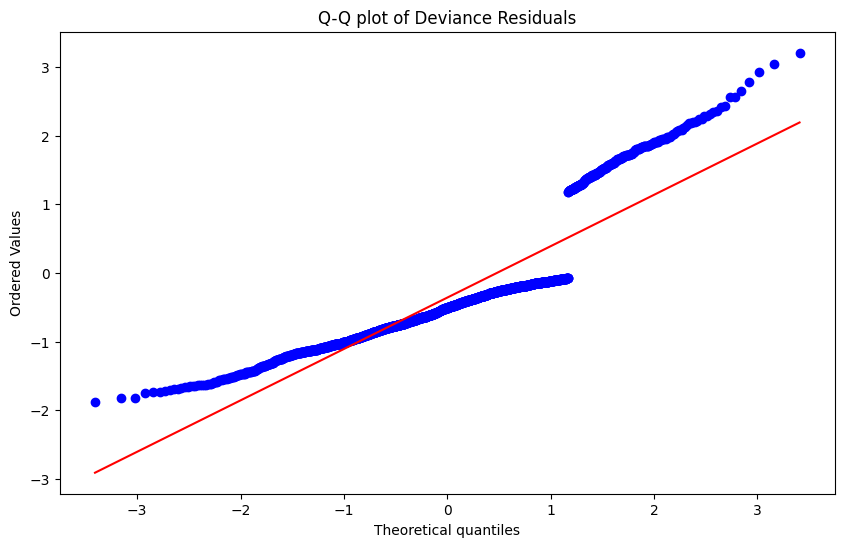

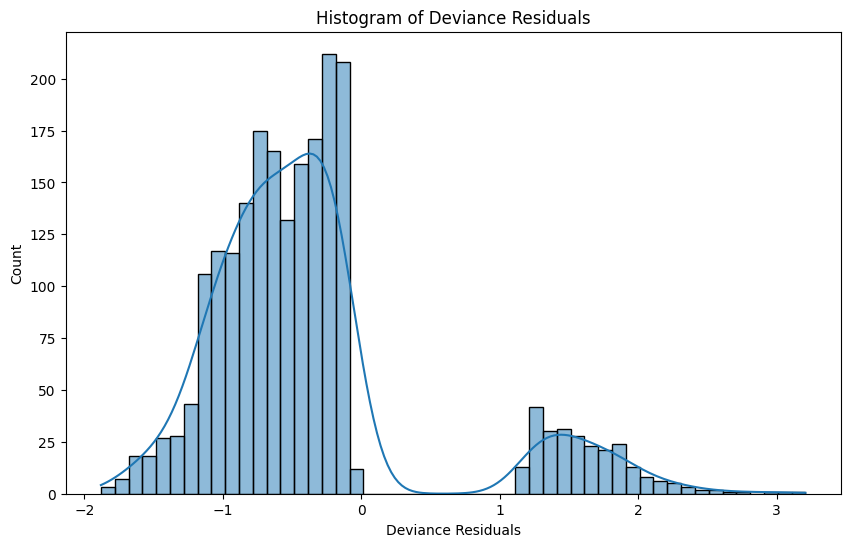

Durbin-Watson statistic: 1.6129528474467718


In [ ]:
# Combine numerical and encoded categorical variables
X = pd.concat([df[numerical_cols], encoded_df], axis=1)
y = df['Churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Get the predicted probabilities
y_pred_probs = log_reg.predict_proba(X_test)[:, 1]  # Get probabilities of class 1 (Churn=1)

# Calculate residuals
# For logistic regression, we use deviance residuals
y_pred = log_reg.predict(X_test)
deviance_residuals = np.sqrt(-2 * (y_test * np.log(y_pred_probs) + (1 - y_test) * np.log(1 - y_pred_probs)))
deviance_residuals *= np.where(y_test > y_pred, 1, -1)

# Plot residuals vs predicted probabilities to check for independence
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_probs, y=deviance_residuals)
plt.axhline(0, color='r', linestyle='--')
plt.title('Deviance Residuals vs Predicted Probabilities (Checking Independence)')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Deviance Residuals')
plt.show()

# Additional diagnostic plots

# Q-Q plot of residuals
plt.figure(figsize=(10, 6))
stats.probplot(deviance_residuals, dist="norm", plot=plt)
plt.title("Q-Q plot of Deviance Residuals")
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(deviance_residuals, kde=True)
plt.title('Histogram of Deviance Residuals')
plt.xlabel('Deviance Residuals')
plt.show()

# Calculate and print Durbin-Watson statistic
from statsmodels.stats.stattools import durbin_watson
dw_statistic = durbin_watson(deviance_residuals)
print(f"Durbin-Watson statistic: {dw_statistic}")


Doesn't fit independence

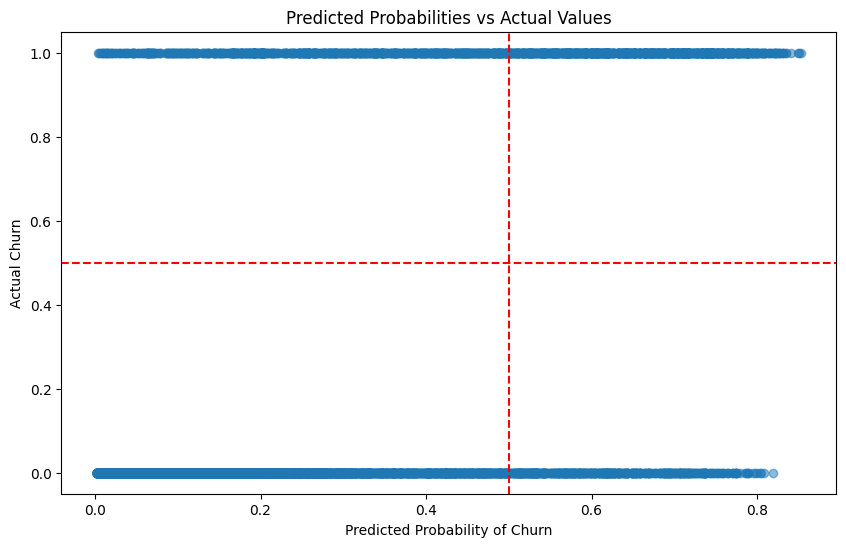

Number of potential outliers: 97
Indices of potential outliers: [ 268  317  320  335  430  811  842  975 1306 1612 1780 1840 1856 1928
 1967 2029 2070 2127 2244 2412 2529 2536 2614 2752 2775 2780 2822 2894
 3040 3042 3326 3517 3534 3577 3694 3779 3788 3799 3834 3844 3971 4078
 4082 4149 4174 4266 4272 4386 4402 4418 4513 4539 4642 4684 4698 4734
 4795 4819 4910 5086 5127 5216 5270 5441 5475 5482 5579 5581 5589 5684
 5765 5841 5900 5946 5947 5992 6038 6202 6289 6312 6321 6357 6424 6537
 6605 6608 6632 6680 6724 6757 6772 6785 6792 6813 6869 6945 6996]


In [ ]:
# Combine numerical and encoded categorical variables
X = pd.concat([df[numerical_cols], encoded_df], axis=1)
y = df['Churn']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict probabilities
y_pred_proba = model.predict_proba(X)[:, 1]

# Create a scatter plot of predicted probabilities vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_proba, y, alpha=0.5)
plt.title('Predicted Probabilities vs Actual Values')
plt.xlabel('Predicted Probability of Churn')
plt.ylabel('Actual Churn')
plt.axhline(y=0.5, color='r', linestyle='--')
plt.axvline(x=0.5, color='r', linestyle='--')
plt.show()

# Identify potential outliers or influential points
threshold = 0.9  # You can adjust this threshold
potential_outliers = np.where((y == 0) & (y_pred_proba > threshold) |
                              (y == 1) & (y_pred_proba < (1 - threshold)))[0]

print(f"Number of potential outliers: {len(potential_outliers)}")
print("Indices of potential outliers:", potential_outliers)


No influential outliers

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     48.8489
Link Function:                     IdentityLink Log Likelihood:                                -17227.6646
Number of Samples:                         7043 AIC:                                            34555.0271
                                                AICc:                                           34555.7521
                                                GCV:                                                0.1448
                                                Scale:                                               0.143
                                                Pseudo R-Squared:                                   0.2715
Feature Function                  Lam

<ipython-input-15-73cddac957ba>:5: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


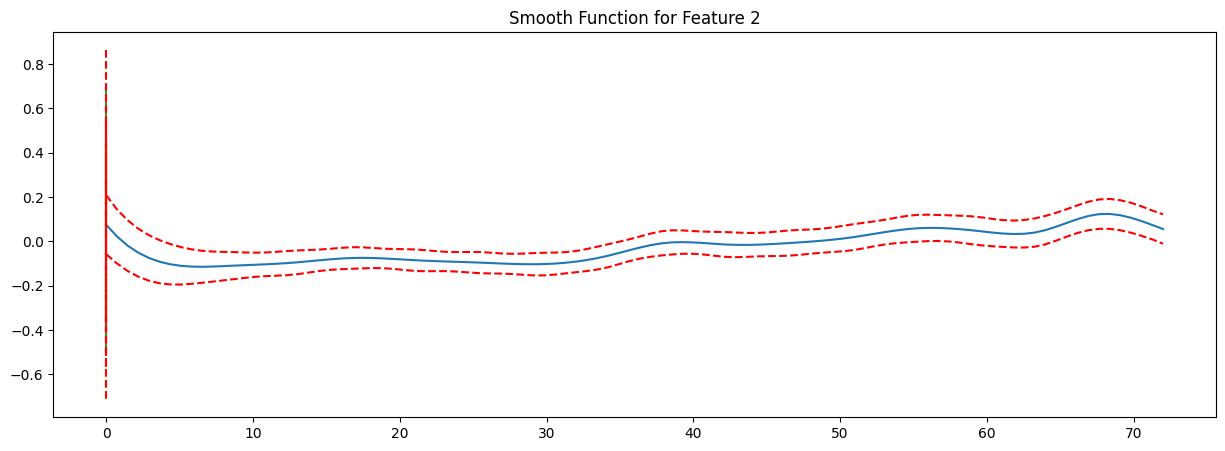

In [ ]:
# Fit a GAM model with splines for each feature
gam = LinearGAM(s(0) + s(1) + s(2)).fit(X, y)

# Print summary of the model
print(gam.summary())

# Plot the smooth functions for each feature (excluding intercept term)
plt.figure(figsize=(15, 5))

# Loop through each term and check if it's an intercept before plotting
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue  # Skip the intercept term
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, 0], gam.partial_dependence(term=i, X=XX))
    plt.plot(XX[:, 0], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    plt.title(f"Smooth Function for Feature {i}")
plt.show()


fit smooth

2. Linear Regression

                            OLS Regression Results                            
Dep. Variable:                  Churn   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     126.0
Date:                Tue, 17 Sep 2024   Prob (F-statistic):               0.00
Time:                        00:51:23   Log-Likelihood:                -3063.8
No. Observations:                7043   AIC:                             6174.
Df Residuals:                    7020   BIC:                             6331.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

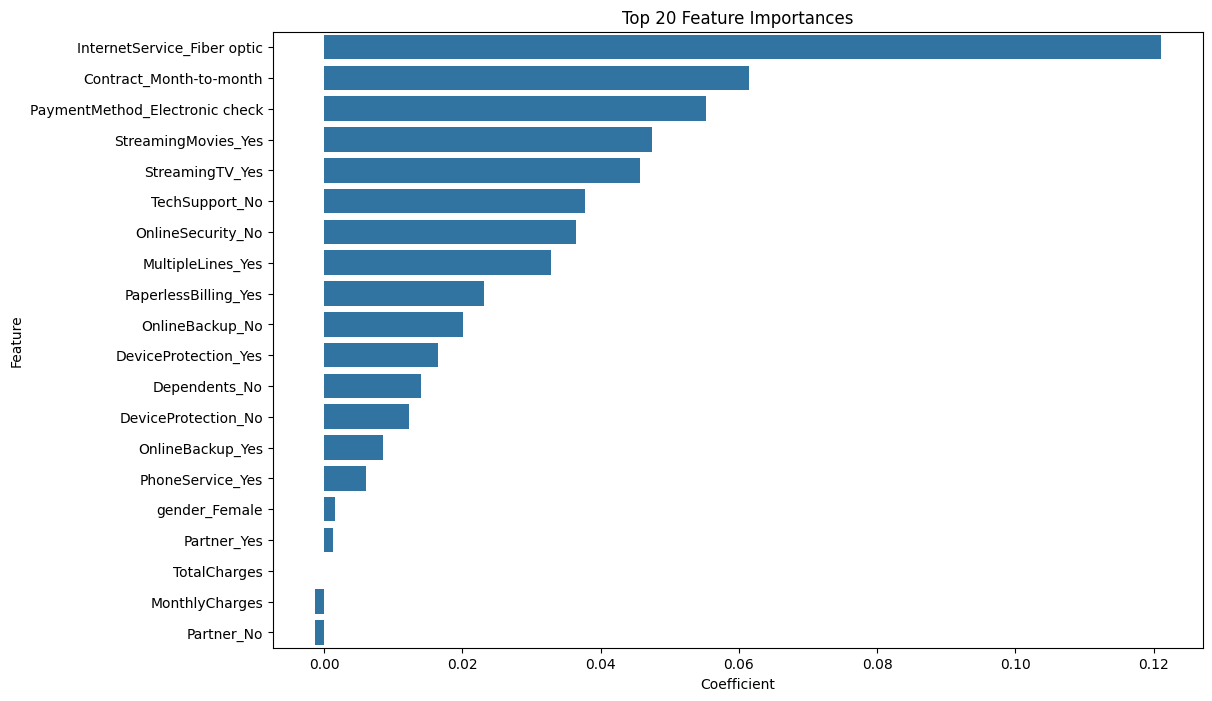


Variance Inflation Factors for Numerical Variables:
          feature       VIF
0          tenure  6.321802
1  MonthlyCharges  3.360371
2    TotalCharges  8.073814


In [ ]:
# Combine encoded categorical variables with numerical variables
combined_df = pd.concat([df[numerical_cols], encoded_df, df['Churn']], axis=1)

# Prepare feature matrix X and target vector y
X = combined_df.drop('Churn', axis=1)
y = combined_df['Churn']

# Fit linear regression model on the entire dataset
linear_model = LinearRegression()
linear_model.fit(X, y)

# Use statsmodels for more detailed output and coefficient interpretation
X_with_const = sm.add_constant(X)  # Add constant for intercept
sm_model = sm.OLS(y, X_with_const).fit()  # Fit using statsmodels
print(sm_model.summary())  # Detailed output of the model

# Predict on the entire dataset (since we're not splitting)
y_pred = linear_model.predict(X)

# Assess model performance
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"\nMean Squared Error (MSE): {mse}")
print(f"R-squared: {r2}")

# Check the coefficients learned by the linear model
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': linear_model.coef_
}).sort_values(by='Coefficient', ascending=False)

print("\nCoefficients from Linear Model:")
print(coefficients)

# Plot the feature importances (coefficients)
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=coefficients.head(20))
plt.title('Top 20 Feature Importances')
plt.show()

# Calculate VIF for numerical variables (since encoded variables are binary, VIF is less relevant for them)
vif_data = pd.DataFrame()
vif_data["feature"] = numerical_cols
vif_data["VIF"] = [variance_inflation_factor(df[numerical_cols].values, i) for i in range(len(numerical_cols))]

print("\nVariance Inflation Factors for Numerical Variables:")
print(vif_data)


Tenure: Every 1 month increase in tenure is expected to cause Churn to decrease by 0.0018.

TotalCharges: Every unit increase in TotalCharges is expected to cause Churn to decrease by 4.493e-05.

Dependents_No: If the customer has no dependents, it is expected to increase Churn by 0.0444 compared to having dependents.

InternetService_DSL: If the customer uses DSL for internet service, it is expected to cause Churn to decrease by 0.072 compared to other internet services.

OnlineSecurity_No: If the customer does not have online security, it is expected to increase Churn by 0.0568 compared to having online security.

OnlineBackup_No: If the customer does not have online backup, it is expected to increase Churn by 0.0404 compared to having online backup.

DeviceProtection_No: If the customer does not have device protection, it is expected to increase Churn by 0.0325 compared to having device protection.

TechSupport_No: If the customer does not have tech support, it is expected to increase Churn by 0.058 compared to having tech support.

Contract_Month-to-month: If the customer is on a month-to-month contract, it is expected to increase Churn by 0.0818 compared to other contract types.

Contract_One year: If the customer is on a one-year contract, it is expected to decrease Churn by 0.027 compared to other contract types.

PaperlessBilling_Yes: If the customer has paperless billing, it is expected to increase Churn by 0.0535 compared to not using paperless billing.

PaymentMethod_Electronic check: If the customer uses electronic check as their payment method, it is expected to increase Churn by 0.0705 compared to other payment methods.

const be 0.0716, saying that when tenure, MonthlyCharges, and TotalCharges be 0, Churn is expect to be 0.0716

R-Squared is 0.283, saying the model explained about 28.3% data, which is not sufficient.

Using linear model on binary value may be not appropriate.

3. Logistic Regression (Asked ChatGPT for model evaluation)

In [ ]:
# Identify numerical and categorical columns
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'customerID']

# One-hot encoding for categorical variables, dropping the first to avoid multicollinearity
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
encoded_cats = encoder.fit_transform(df[categorical_cols])
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)

# Create a new dataframe with encoded variables
encoded_df = pd.DataFrame(encoded_cats, columns=encoded_feature_names, index=df.index)

# Combine encoded categorical variables with numerical variables
X = pd.concat([df[numerical_cols], encoded_df], axis=1)
y = df['Churn']

# Check for multicollinearity using VIF (Variance Inflation Factor)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

# Optionally, drop columns with high VIF values (e.g., VIF > 10)
high_vif_cols = vif[vif["VIF Factor"] > 10]["features"].tolist()
if high_vif_cols:
    print(f"\nDropping columns with high VIF to avoid multicollinearity: {high_vif_cols}")
    X.drop(columns=high_vif_cols, inplace=True)

# Fit logistic model using sklearn
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X, y)

# Use statsmodels for more detailed output and coefficient interpretation
X_with_const = sm.add_constant(X)  # Add constant for intercept
sm_logit_model = sm.Logit(y, X_with_const).fit()  # Fit the logistic regression model using statsmodels
print(sm_logit_model.summary())  # Output detailed model summary

# Predict probabilities and classes
y_pred_prob = log_model.predict_proba(X)[:, 1]  # Get probabilities of the positive class (Churn = 1)
y_pred_class = log_model.predict(X)  # Get predicted classes (0 or 1)

# Confusion matrix and classification report
print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred_class))

print("\nClassification Report:")
print(classification_report(y, y_pred_class))



/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


     VIF Factor                               features
0      7.399031                                 tenure
1    865.045206                         MonthlyCharges
2     10.675290                           TotalCharges
3      1.002143                            gender_Male
4      1.448224                            Partner_Yes
5      1.336781                         Dependents_Yes
6   1770.601881                       PhoneService_Yes
7     60.844446         MultipleLines_No phone service
8      7.272108                      MultipleLines_Yes
9    148.257456            InternetService_Fiber optic
10          inf                     InternetService_No
11          inf     OnlineSecurity_No internet service
12     6.333593                     OnlineSecurity_Yes
13          inf       OnlineBackup_No internet service
14     6.783323                       OnlineBackup_Yes
15          inf   DeviceProtection_No internet service
16     6.922437                   DeviceProtection_Yes
17        

Several variables were deleted for Multicollinearity.

const = -0.5444: This suggests that with all other variables held at zero, the log-odds of churning is -0.5444, indicating a very low likelihood of churn.

tenure = -0.0292: This indicates that for each additional month of tenure, the log-odds of churning decreases by 2.92%, suggesting that longer tenure reduces the likelihood of churn.

Dependents_Yes = -0.3478: Having dependents decreases the log-odds of churning by 34.78%, indicating that customers with dependents are less likely to churn.

MultipleLines_Yes = 0.5723: Having multiple lines increases the log-odds of churning by 57.23%, suggesting that customers with multiple lines are more likely to churn.

OnlineSecurity_Yes = -0.3186: Using online security services decreases the log-odds of churning by 31.86%, showing that such services are effective at retaining customers.

DeviceProtection_Yes = 0.3171: Having device protection increases the log-odds of churning by 31.71%, suggesting that customers with this service might have a higher churn rate.

TechSupport_Yes = -0.2285: Accessing tech support services reduces the log-odds of churning by 22.85%, indicating that tech support can help retain customers.

Contract_One year = -0.9330: Being on a one-year contract reduces the log-odds of churning by 93.30%, showing a strong retention effect associated with longer-term contracts.

Contract_Two year = -1.8641: Similarly, being on a two-year contract reduces the log-odds of churning by 186.41%, further emphasizing the retention power of long-term contracts.

PaperlessBilling_Yes = 0.6239: Opting for paperless billing increases the log-odds of churning by 62.39%, indicating that customers using paperless billing are more likely to churn.

PaymentMethod_Electronic check = 0.5430: Using electronic checks as a payment method increases the log-odds of churning by 54.30%, suggesting a higher churn rate among users of this payment method.

PaymentMethod_Mailed check = -0.3351: Using mailed checks as a payment method decreases the log-odds of churning by 33.51%, indicating that this method might be associated with better customer retention.

Pseudo R-squ = 0.2424, saying the model explained 24.24% of the data.

4. GAM

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     56.3831
Link Function:                        LogitLink Log Likelihood:                                 -2831.0494
Number of Samples:                         7043 AIC:                                             5774.8649
                                                AICc:                                            5775.8242
                                                UBRE:                                               2.8263
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3053
Feature Function                  Lam

<ipython-input-21-fc3d2864f07a>:40: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())  # Show the usual summary


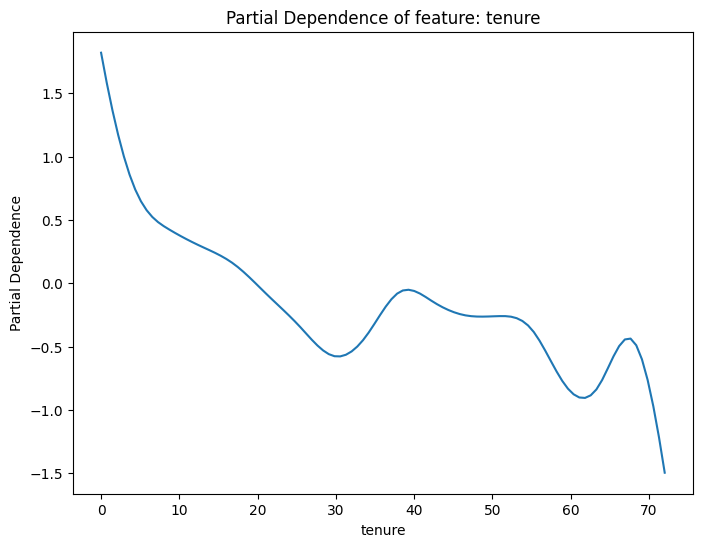

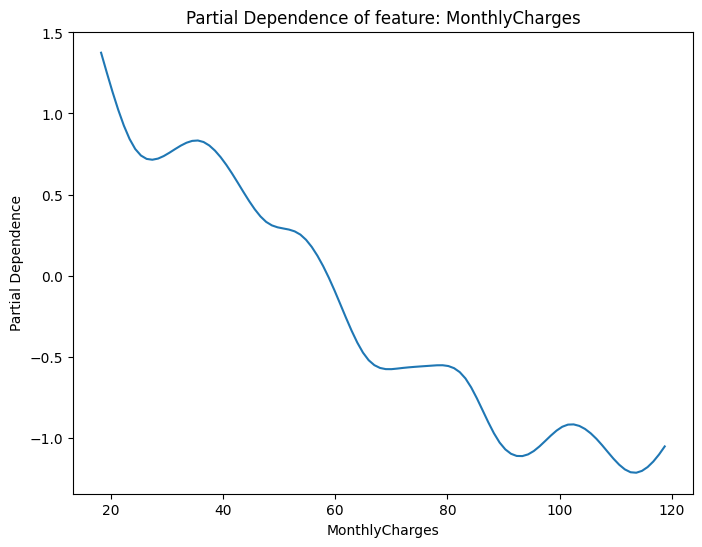

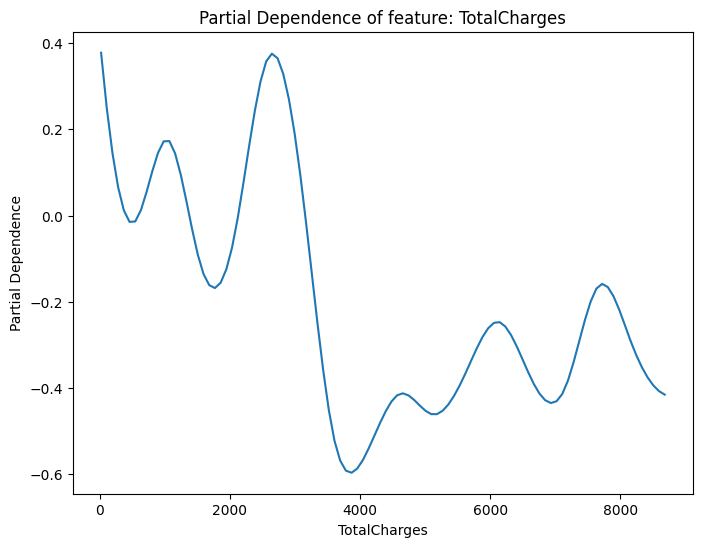

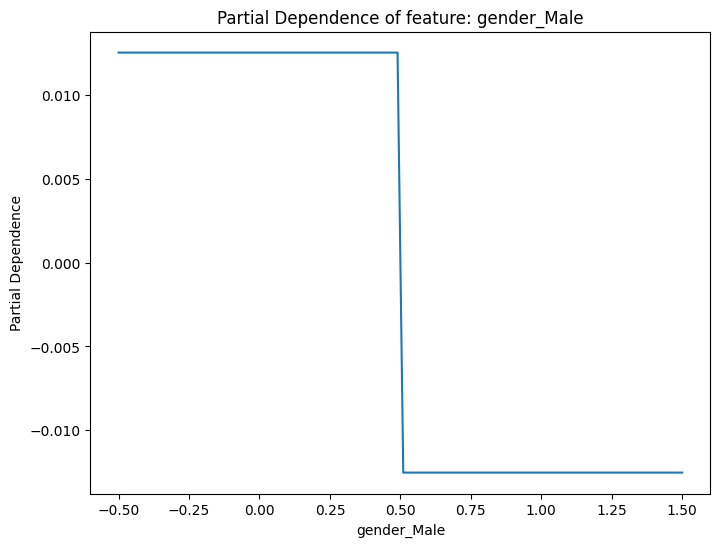

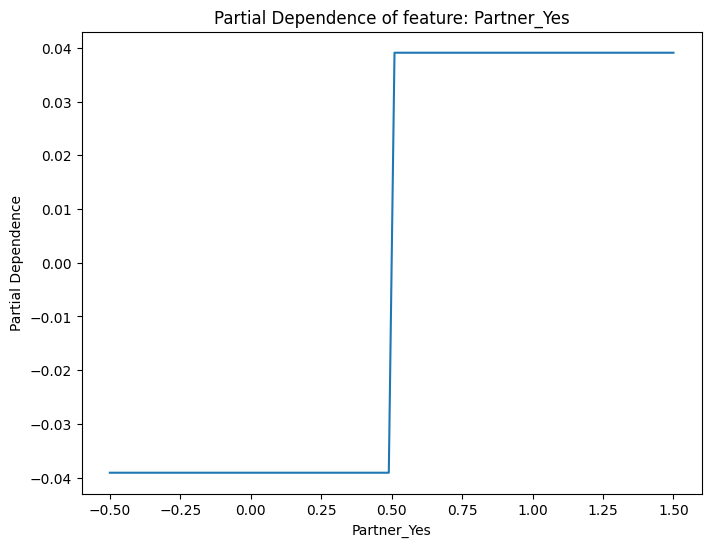

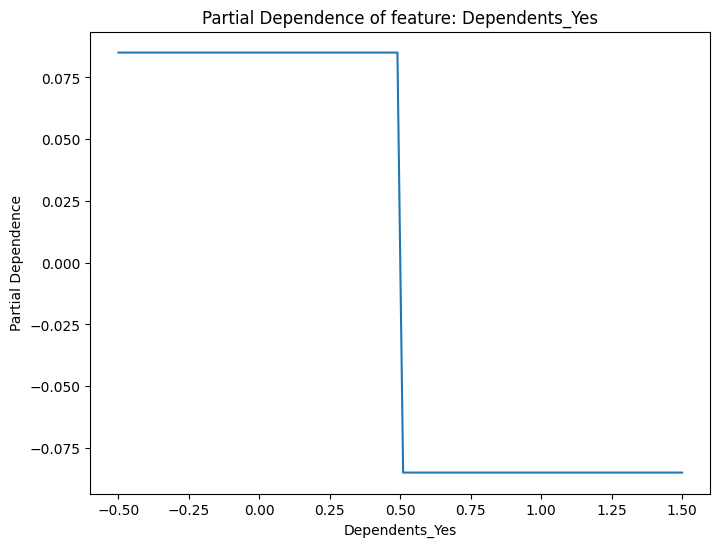

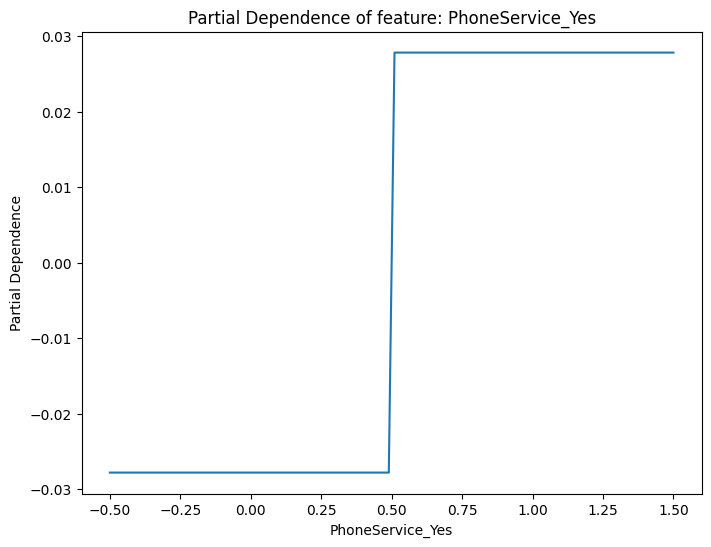

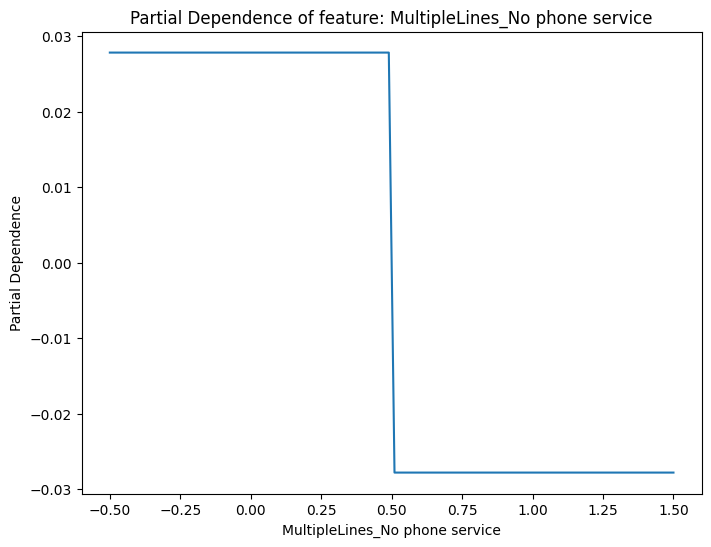

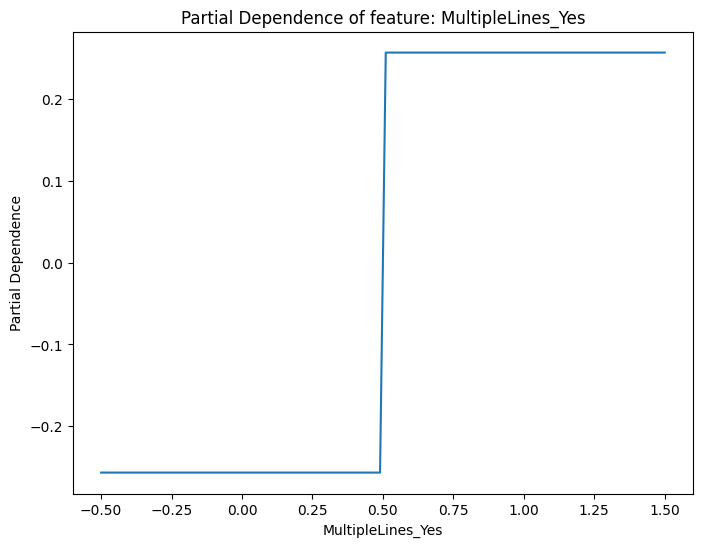

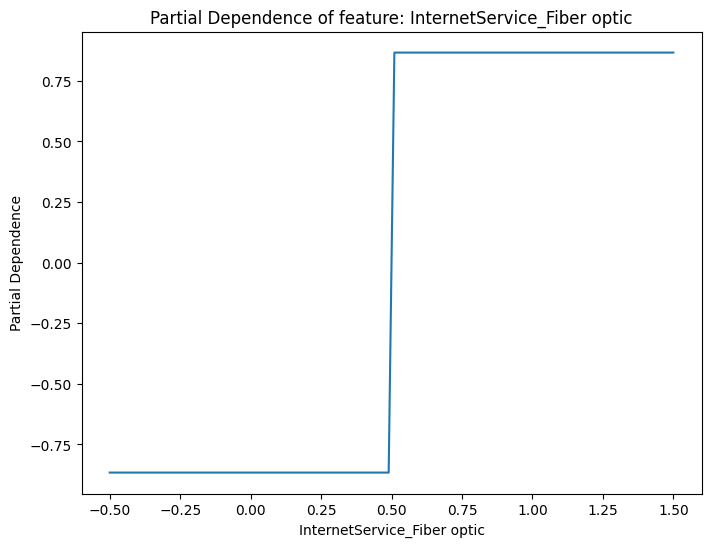

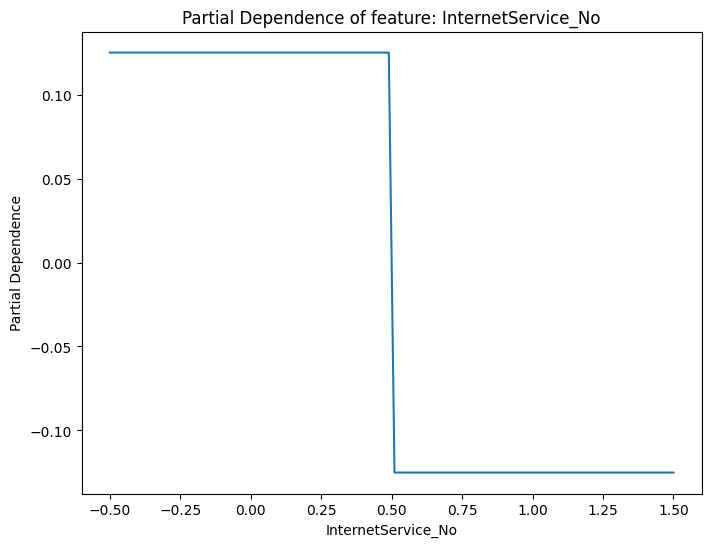

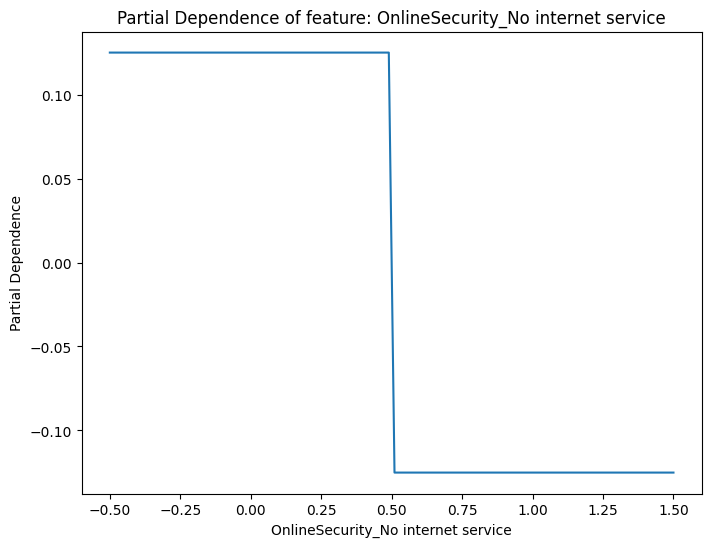

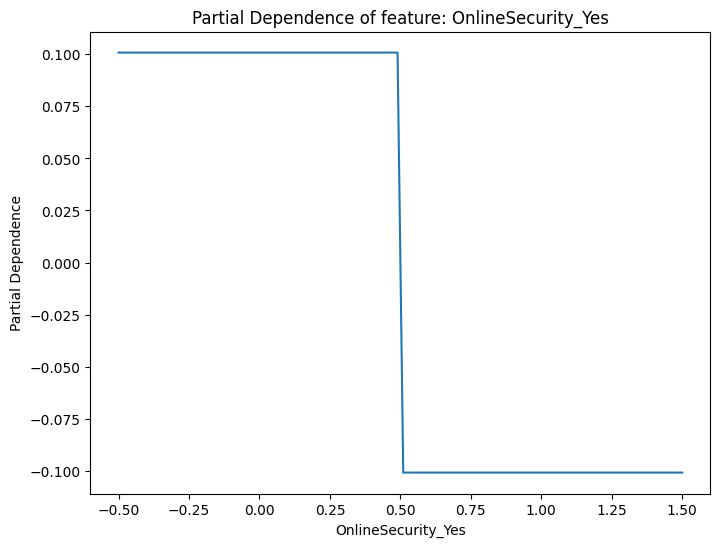

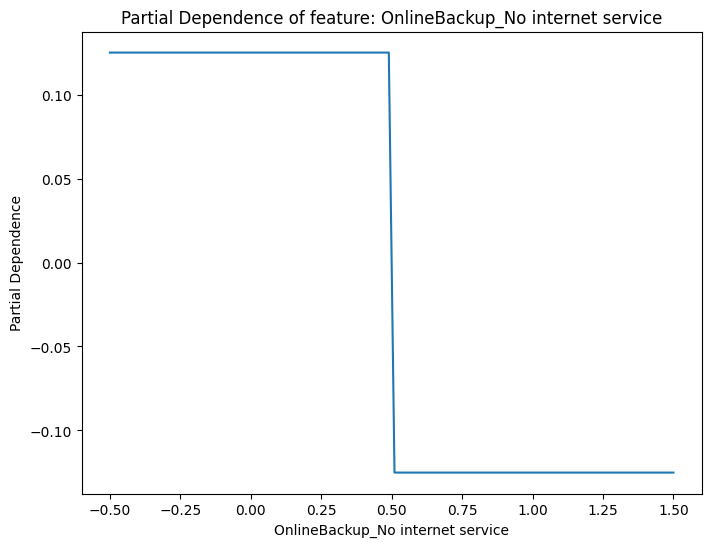

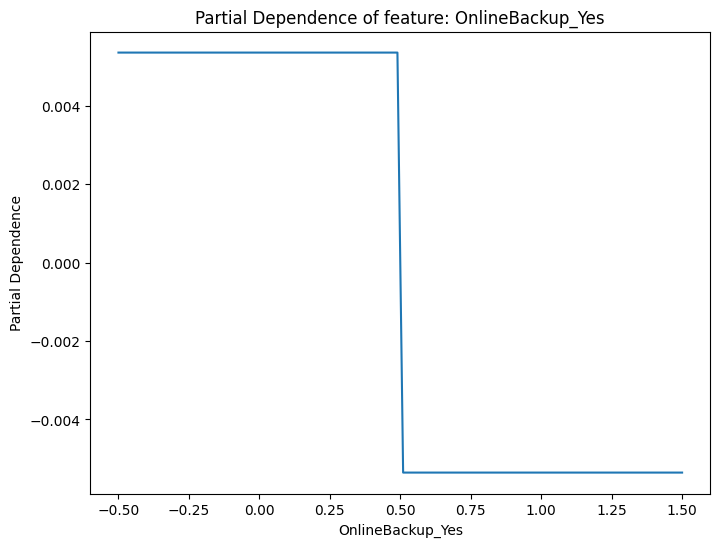

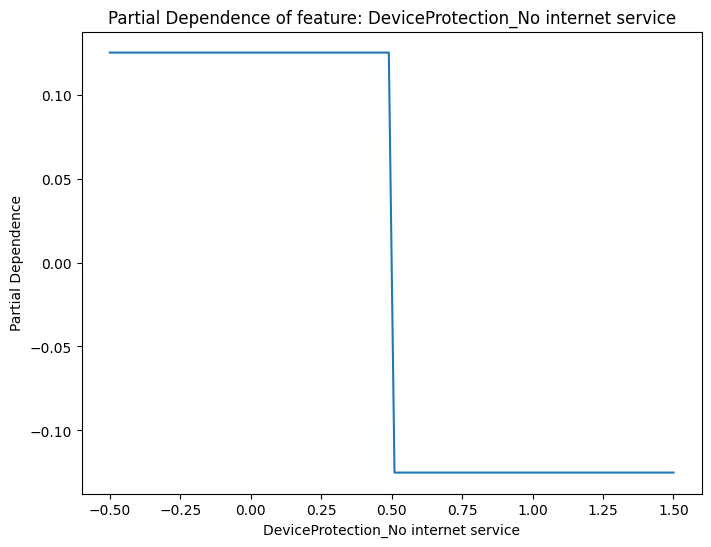

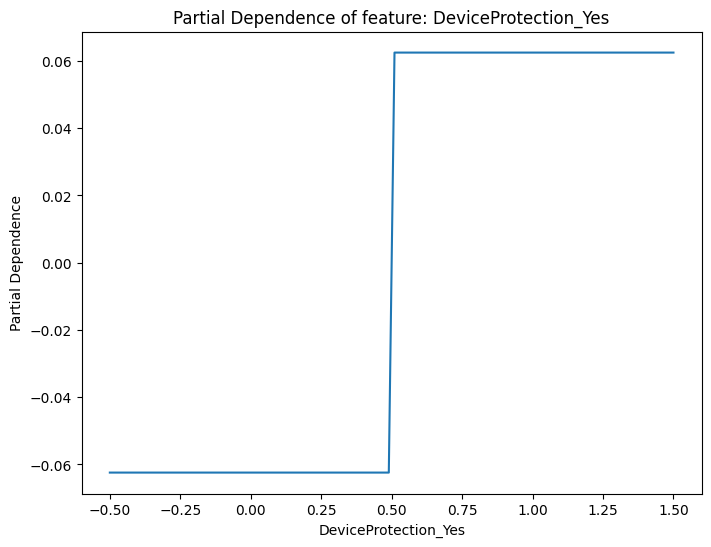

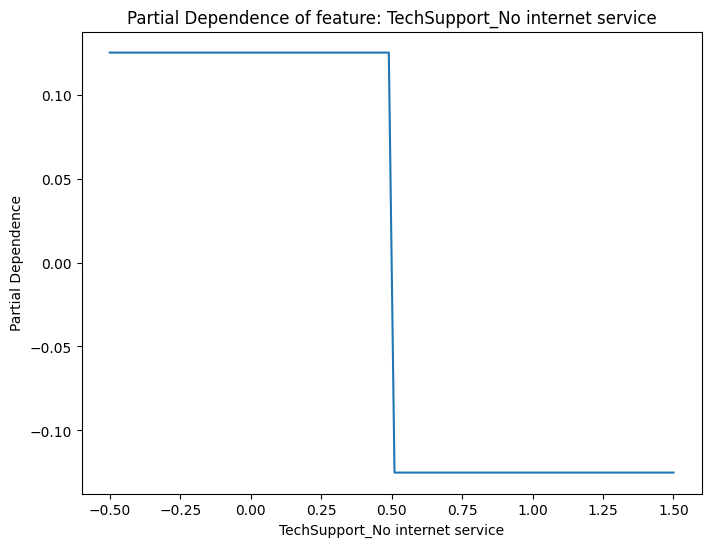

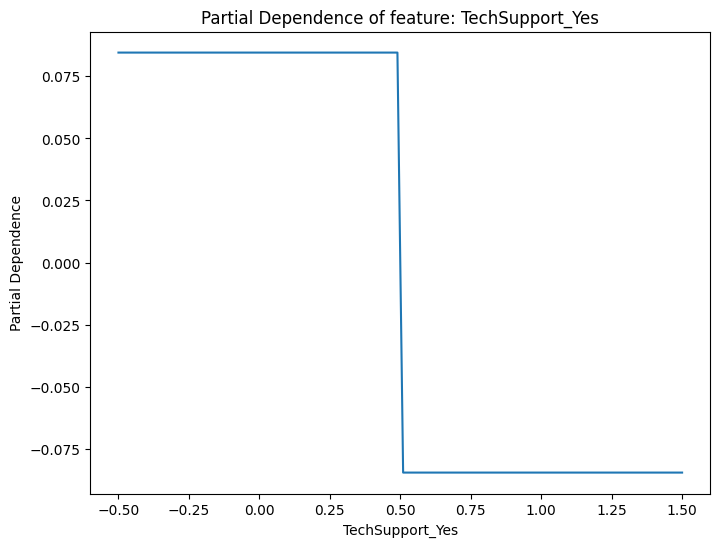

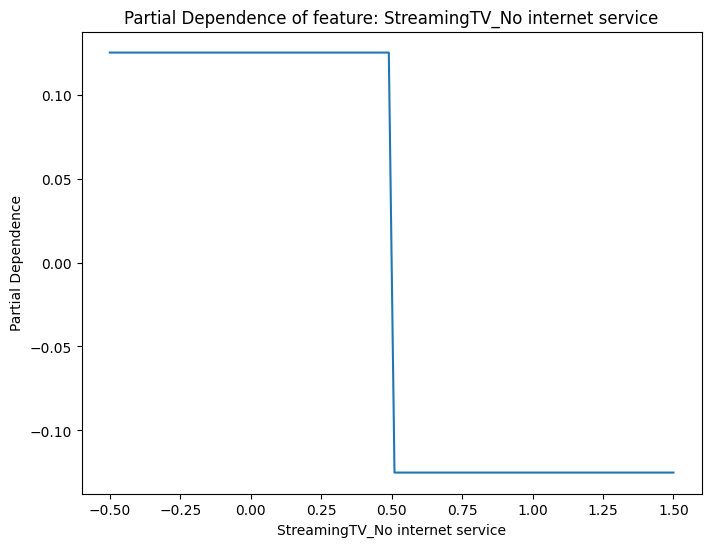

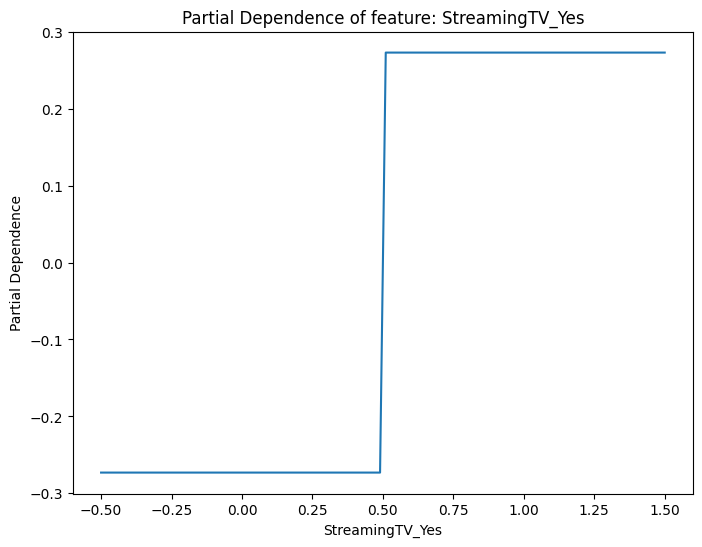

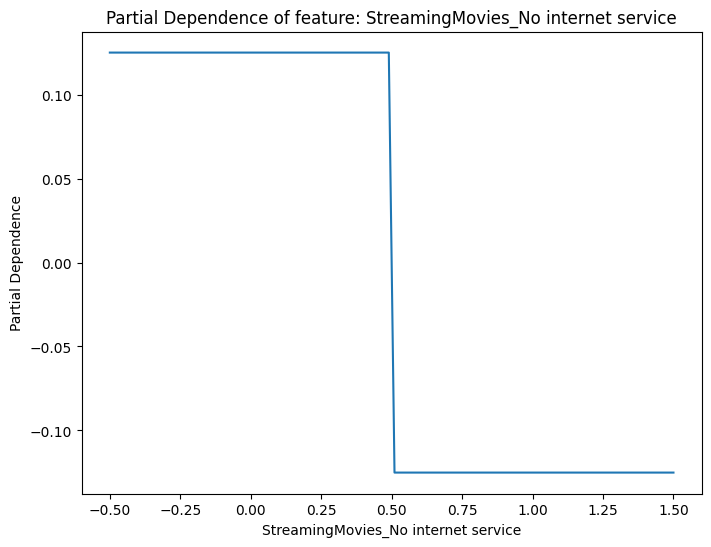

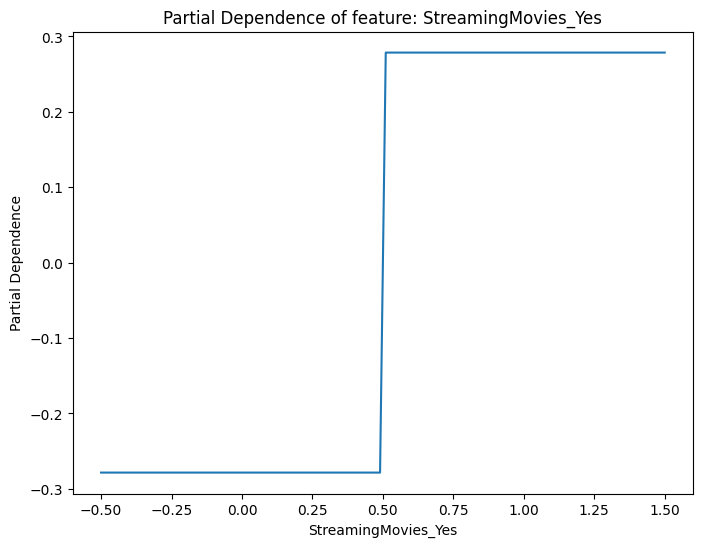

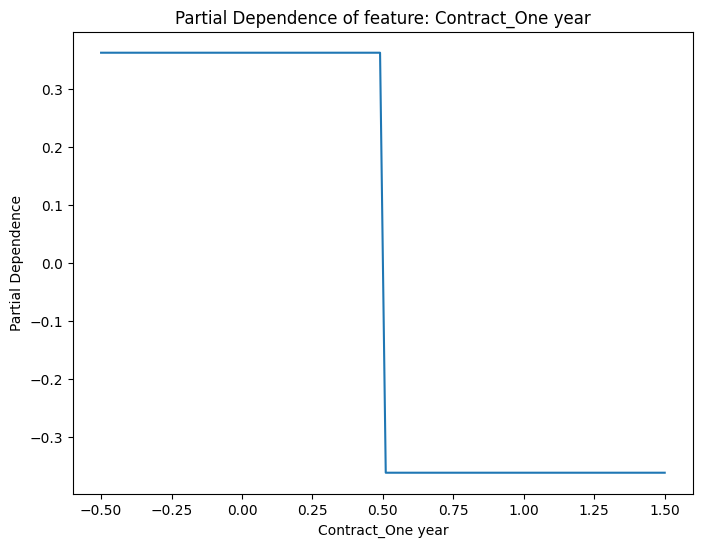

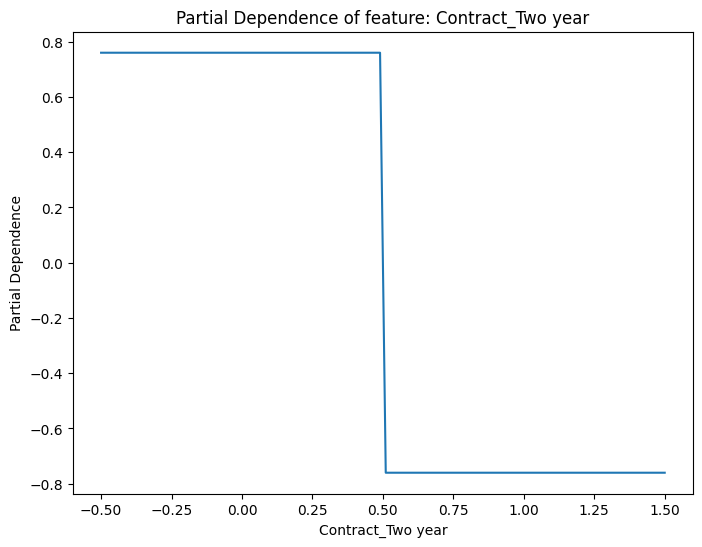

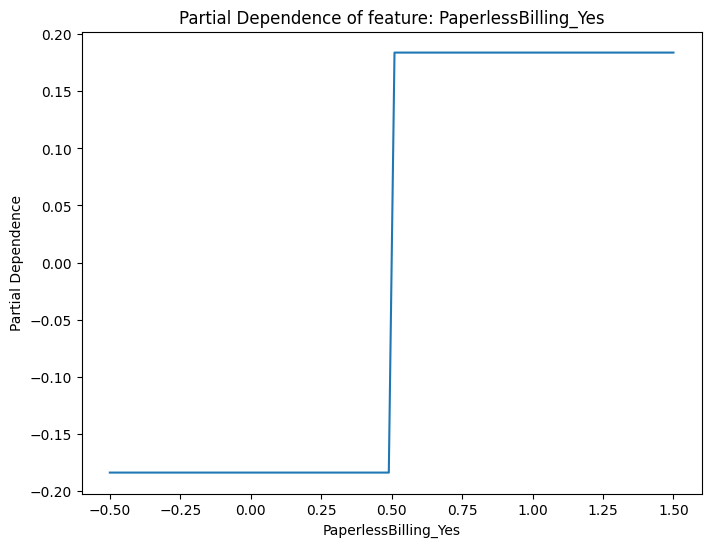

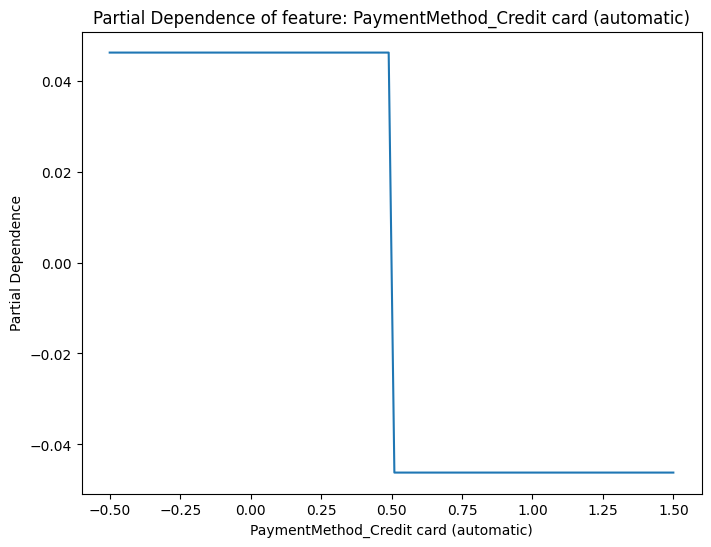

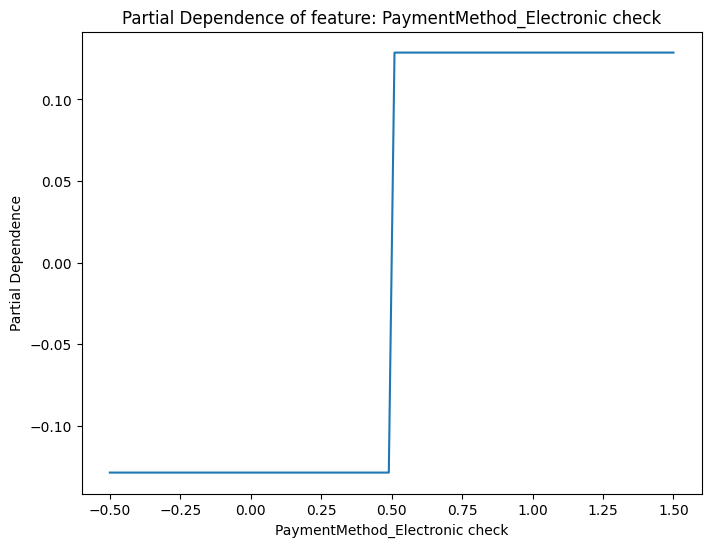

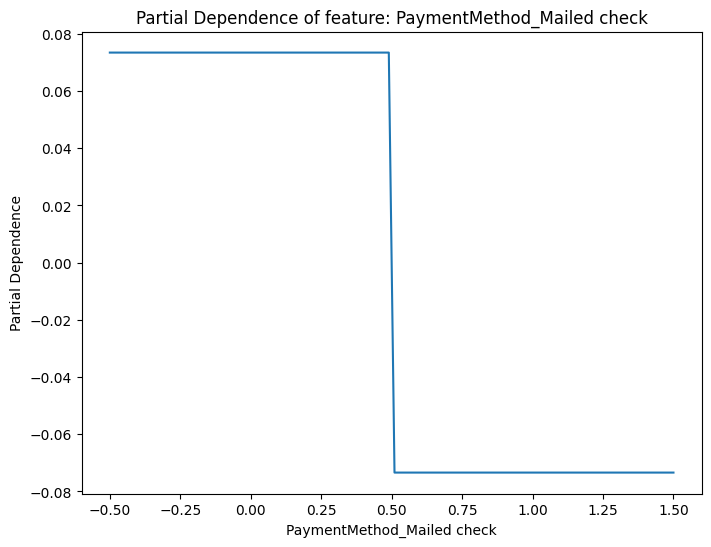

In [ ]:
from pygam import LogisticGAM, s, f
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Step 1: Define numerical and categorical columns
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                   'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                   'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                   'PaperlessBilling', 'PaymentMethod']

# Step 2: Apply OneHotEncoder with drop='first' to avoid multicollinearity
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_cats = encoder.fit_transform(df[categorical_cols])
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)

# Create a new dataframe with encoded variables
encoded_df = pd.DataFrame(encoded_cats, columns=encoded_feature_names)

# Combine encoded categorical variables with numerical variables
combined_df = pd.concat([df[numerical_cols], encoded_df, df['Churn']], axis=1)

# Prepare feature matrix X and target variable y
X = combined_df.drop('Churn', axis=1)
y = combined_df['Churn']

# Step 3: Build the GAM model using smooth functions for numerical variables
# and factor functions for encoded categorical variables
gam_formula = s(0) + s(1) + s(2)  # Smooth terms for the numerical variables

# Dynamically add the encoded categorical terms
for i in range(len(numerical_cols), X.shape[1]):
    gam_formula += f(i)

# Fit the model with both numerical and categorical terms
gam = LogisticGAM(gam_formula).fit(X, y)

# Step 4: View the model summary
print(gam.summary())  # Show the usual summary

# Step 5: Map f(i) terms to the original categorical variable names
# Combine numerical and encoded feature names
feature_names = numerical_cols + list(encoded_feature_names)

# Print mapping between f(i) and feature names
print("\nFeature Mapping:")
for i, feature_name in enumerate(feature_names):  # Corrected: start from f(0)
    print(f"f({i}) corresponds to feature: '{feature_name}'")

# Step 6: Visualize the smooth functions for each numerical and categorical feature
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    XX = gam.generate_X_grid(term=i)

    # Visualize only smooth functions for numerical features
    plt.figure(figsize=(8, 6))
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    plt.title(f"Partial Dependence of feature: {feature_names[i]}")
    plt.xlabel(feature_names[i])
    plt.ylabel("Partial Dependence")
    plt.show()


This Logistic Generalized Additive Model (GAM) shows that several factors significantly influence customer churn. The model explains about 30.53% of the data's variance (Pseudo R-squared = 0.3053). Key findings include that longer contracts (one-year and two-year) are associated with a lower likelihood of churn, while lack of services such as online security, device protection, and tech support significantly increases the probability of churn. Moreover, customers using fiber optic internet and multiple phone lines show higher churn rates. In contrast, tenure (time with the company) has a nonlinear but significant impact on reducing churn probability over time. Not all factors, such as MonthlyCharges and gender, significantly affect churn according to this model.

5. Compariosn

Linear regression is simple to understand, but in this case difficult to interpret for Churn is a binary variable.

Logistic regression makes Churn explainable, and can identify positive or negative correlation base on coefficient while spot the factor that is more influencial. On the other hand, it captures only linear relationship, which is not sufficient in complex case.

GAM also solve the binary category problem, and allow non-linear relationship between variables. It also has the highest R-Square, which means it explain the data better. But compare to logistic, it's not direct or obvious in finding positive or negative correlation, or how influencial those factors can be. But still, its trend can still be observed with smooth curves.

In this case, I would recommend the company to choose GAM, since it can explain the data better while make the binary variable make sense. But still, other two may contribute to the understanding of correlation or influences those factors have.